In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.ESN_v3_AR import ESN as AR_RNN_ESN
from tools.AEESN_AR_v1 import AR_AERNN_ESN
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2022-12-24 22:00:35.400978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 22:00:35.401274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 22:00:35.437764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 22:00:35.438055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 22:00:35.438294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 22:00:35.439966: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-24 22:00:35.440551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 22:00:35.440789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 22:00:35.441028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful N

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_031'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_rnn_014'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_RNN_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in AR_RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in AR_RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in AR_RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        normalization_type = params_AR_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in AR_RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    covmat_lmda = tparams_dict['covmat_lmda']
    try:
        lambda_reg = tparams_dict['lambda_reg']
    except:
        lambda_reg = 1e-6
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_031
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

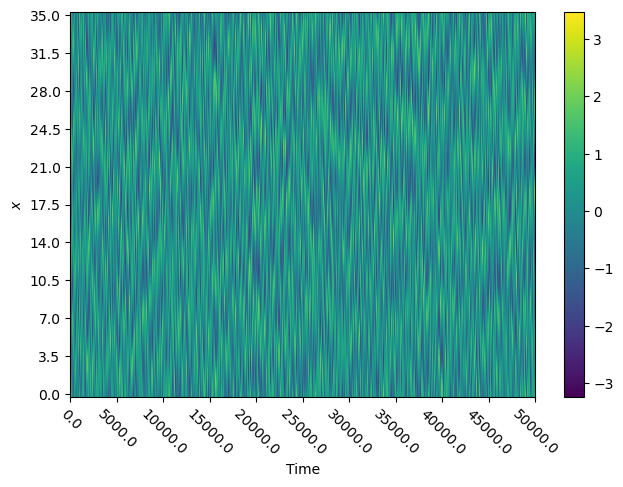

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

In [16]:
all_data.shape

(500026, 64)

# Autoencoder

In [17]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [18]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# ESN

In [19]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([5, 10, 30, 50, 100])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN_ESN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [20]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [1e-5],
        [1e-5],
        [2e-6],
        [1e-6],
        [5e-7],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
    ]
    patience = [
        [100],
        [100],
        [100],
        [100],
        [100],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 32
    
    train_alpha = [True]
    train_omega_in = [True]
    train_rho_res = [True]
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
        'lambda_reg':lambda_reg,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [21]:
rnn_kwargs = {}
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_ESN_weights.hdf5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'
    
    rnn_kwargs = {
        'train_alpha':train_alpha,
        'train_omega_in':train_omega_in,
        'train_rho_res':train_rho_res,
    }



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None
ListWrapper([True])
ListWrapper([True])
ListWrapper([True])


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
76/76 [==============================] - ETA: 0s - loss: 0.0275 - mse: 4.1357e-04 - NMSE: 0.0037 - covmat_fro_loss: 2.3840e-04 - global_gradnorm: 0.6739 - rho_res_0: 0.5998 - alpha_0: 0.9996 - omega_in_0: 0.9999 - tot_time: 0h 0m 39.6s

Epoch 1: val_NMSE improved from inf to 0.00371, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpo

Epoch 9/1000
76/76 [==============================] - ETA: 0s - loss: 0.0271 - mse: 3.6335e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2526e-04 - global_gradnorm: 0.5978 - rho_res_0: 0.5967 - alpha_0: 0.9939 - omega_in_0: 0.9993 - tot_time: 0h 4m 60.0s

Epoch 9: val_NMSE improved from 0.00350 to 0.00344, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 432ms/step - loss: 0.0271 - mse: 3.6335e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2521e-04 - global_gradnorm: 0.5970 - rho_res_0: 0.5967 - alpha_0: 0.9939 - omega_in_0: 0.9993 - val_loss: 0.0272 - val_mse: 3.8258e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5966 - val_alpha_0: 0.9936 - val_omega_in_0: 0.9992
Epoch 10/1000

Epoch 18/1000
76/76 [==============================] - ETA: 0s - loss: 0.0268 - mse: 3.3920e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.1849e-04 - global_gradnorm: 0.5706 - rho_res_0: 0.5940 - alpha_0: 0.9877 - omega_in_0: 0.9988 - tot_time: 0h 9m 52.9s

Epoch 18: val_NMSE did not improve from 0.00329
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0268 - mse: 3.3920e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.1865e-04 - global_gradnorm: 0.5704 - rho_res_0: 0.5940 - alpha_0: 0.9877 - omega_in_0: 0.9988 - val_loss: 0.0270 - val_mse: 3.6703e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5938 - val_alpha_0: 0.9874 - val_omega_in_0: 0.9988
Epoch 19/1000
76/76 [==============================] - ETA: 0s - loss: 0.0267 - mse: 3.3704e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1786e

76/76 [==============================] - ETA: 0s - loss: 0.0266 - mse: 3.2298e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1388e-04 - global_gradnorm: 0.5436 - rho_res_0: 0.5917 - alpha_0: 0.9816 - omega_in_0: 0.9985 - tot_time: 0h 14m 43.7s

Epoch 27: val_NMSE improved from 0.00316 to 0.00304, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 432ms/step - loss: 0.0266 - mse: 3.2298e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1374e-04 - global_gradnorm: 0.5438 - rho_res_0: 0.5917 - alpha_0: 0.9816 - omega_in_0: 0.9985 - val_loss: 0.0267 - val_mse: 3.3798e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5916 - val_alpha_0: 0.9813 - val_omega_in_0: 0.9985
Epoch 28/1000
76/76 [===

76/76 [==============================] - ETA: 0s - loss: 0.0263 - mse: 3.0711e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.0913e-04 - global_gradnorm: 0.5245 - rho_res_0: 0.5897 - alpha_0: 0.9755 - omega_in_0: 0.9984 - tot_time: 0h 19m 33.9s

Epoch 36: val_NMSE did not improve from 0.00304
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0263 - mse: 3.0711e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.0911e-04 - global_gradnorm: 0.5239 - rho_res_0: 0.5896 - alpha_0: 0.9755 - omega_in_0: 0.9984 - val_loss: 0.0266 - val_mse: 3.3938e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5896 - val_alpha_0: 0.9752 - val_omega_in_0: 0.9984
Epoch 37/1000
76/76 [==============================] - ETA: 0s - loss: 0.0263 - mse: 3.0517e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0866e-04 - global_

Epoch 45/1000
76/76 [==============================] - ETA: 0s - loss: 0.0262 - mse: 2.9583e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0581e-04 - global_gradnorm: 0.5064 - rho_res_0: 0.5879 - alpha_0: 0.9694 - omega_in_0: 0.9983 - tot_time: 0h 24m 26.8s

Epoch 45: val_NMSE improved from 0.00293 to 0.00289, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 432ms/step - loss: 0.0262 - mse: 2.9583e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0577e-04 - global_gradnorm: 0.5064 - rho_res_0: 0.5879 - alpha_0: 0.9694 - omega_in_0: 0.9983 - val_loss: 0.0264 - val_mse: 3.2122e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5878 - val_alpha_0: 0.9690 - val_omega_in_0: 0.9983
Epoch 46/1

76/76 [==============================] - ETA: 0s - loss: 0.0260 - mse: 2.8582e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0261e-04 - global_gradnorm: 0.4927 - rho_res_0: 0.5863 - alpha_0: 0.9632 - omega_in_0: 0.9983 - tot_time: 0h 29m 17.4s

Epoch 54: val_NMSE did not improve from 0.00285
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0260 - mse: 2.8582e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0253e-04 - global_gradnorm: 0.4923 - rho_res_0: 0.5863 - alpha_0: 0.9632 - omega_in_0: 0.9983 - val_loss: 0.0262 - val_mse: 3.1849e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5862 - val_alpha_0: 0.9629 - val_omega_in_0: 0.9983
Epoch 55/1000
76/76 [==============================] - ETA: 0s - loss: 0.0260 - mse: 2.8496e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0260e-04 - global_

76/76 [==============================] - ETA: 0s - loss: 0.0258 - mse: 2.7445e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9897e-04 - global_gradnorm: 0.4648 - rho_res_0: 0.5849 - alpha_0: 0.9570 - omega_in_0: 0.9983 - tot_time: 0h 34m 7.0s

Epoch 63: val_NMSE did not improve from 0.00274
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0258 - mse: 2.7445e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9906e-04 - global_gradnorm: 0.4662 - rho_res_0: 0.5849 - alpha_0: 0.9570 - omega_in_0: 0.9983 - val_loss: 0.0261 - val_mse: 3.0652e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5848 - val_alpha_0: 0.9567 - val_omega_in_0: 0.9983
Epoch 64/1000
76/76 [==============================] - ETA: 0s - loss: 0.0258 - mse: 2.7497e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9915e-04 - global_g

76/76 [==============================] - ETA: 0s - loss: 0.0256 - mse: 2.6588e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9619e-04 - global_gradnorm: 0.4523 - rho_res_0: 0.5837 - alpha_0: 0.9508 - omega_in_0: 0.9984 - tot_time: 0h 38m 57.4s

Epoch 72: val_NMSE improved from 0.00271 to 0.00270, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 434ms/step - loss: 0.0256 - mse: 2.6588e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9617e-04 - global_gradnorm: 0.4533 - rho_res_0: 0.5837 - alpha_0: 0.9508 - omega_in_0: 0.9984 - val_loss: 0.0259 - val_mse: 2.9982e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5836 - val_alpha_0: 0.9505 - val_omega_in_0: 0.9984
Epoch 73/1000
76/76 [===

Epoch 81/1000
76/76 [==============================] - ETA: 0s - loss: 0.0254 - mse: 2.5697e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9333e-04 - global_gradnorm: 0.4395 - rho_res_0: 0.5826 - alpha_0: 0.9446 - omega_in_0: 0.9986 - tot_time: 0h 43m 50.6s

Epoch 81: val_NMSE did not improve from 0.00260
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0254 - mse: 2.5697e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9351e-04 - global_gradnorm: 0.4398 - rho_res_0: 0.5826 - alpha_0: 0.9446 - omega_in_0: 0.9986 - val_loss: 0.0258 - val_mse: 2.9335e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5826 - val_alpha_0: 0.9443 - val_omega_in_0: 0.9986
Epoch 82/1000
76/76 [==============================] - ETA: 0s - loss: 0.0254 - mse: 2.5619e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9305

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 438ms/step - loss: 0.0253 - mse: 2.5196e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9174e-04 - global_gradnorm: 0.4380 - rho_res_0: 0.5818 - alpha_0: 0.9384 - omega_in_0: 0.9987 - val_loss: 0.0256 - val_mse: 2.8492e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5817 - val_alpha_0: 0.9380 - val_omega_in_0: 0.9987
Epoch 91/1000
76/76 [==============================] - ETA: 0s - loss: 0.0253 - mse: 2.5144e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9160e-04 - global_gradnorm: 0.4352 - rho_res_0: 0.5817 - alpha_0: 0.9377 - omega_in_0: 0.9988 - tot_time: 0h 49m 13.2s

Epoch 91: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5

Epoch 100/1000
76/76 [==============================] - ETA: 0s - loss: 0.0251 - mse: 2.4407e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8899e-04 - global_gradnorm: 0.4231 - rho_res_0: 0.5810 - alpha_0: 0.9314 - omega_in_0: 0.9990 - tot_time: 0h 54m 2.7s

Epoch 100: val_NMSE did not improve from 0.00252
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0251 - mse: 2.4407e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8901e-04 - global_gradnorm: 0.4236 - rho_res_0: 0.5810 - alpha_0: 0.9314 - omega_in_0: 0.9990 - val_loss: 0.0254 - val_mse: 2.8236e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5809 - val_alpha_0: 0.9311 - val_omega_in_0: 0.9990
Epoch 101/1000
76/76 [==============================] - ETA: 0s - loss: 0.0251 - mse: 2.4214e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.88

76/76 [==============================] - ETA: 0s - loss: 0.0250 - mse: 2.3772e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8672e-04 - global_gradnorm: 0.4074 - rho_res_0: 0.5805 - alpha_0: 0.9252 - omega_in_0: 0.9992 - tot_time: 0h 58m 52.6s

Epoch 109: val_NMSE improved from 0.00247 to 0.00245, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 433ms/step - loss: 0.0250 - mse: 2.3772e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8645e-04 - global_gradnorm: 0.4068 - rho_res_0: 0.5805 - alpha_0: 0.9252 - omega_in_0: 0.9992 - val_loss: 0.0253 - val_mse: 2.7234e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5804 - val_alpha_0: 0.9248 - val_omega_in_0: 0.9992
Epoch 110/1000
76/76 [=

Epoch 118/1000
76/76 [==============================] - ETA: 0s - loss: 0.0248 - mse: 2.3241e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8505e-04 - global_gradnorm: 0.4047 - rho_res_0: 0.5801 - alpha_0: 0.9189 - omega_in_0: 0.9995 - tot_time: 1h 3m 46.5s

Epoch 118: val_NMSE did not improve from 0.00242
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0248 - mse: 2.3241e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8517e-04 - global_gradnorm: 0.4047 - rho_res_0: 0.5801 - alpha_0: 0.9189 - omega_in_0: 0.9995 - val_loss: 0.0252 - val_mse: 2.7295e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5801 - val_alpha_0: 0.9185 - val_omega_in_0: 0.9995
Epoch 119/1000
76/76 [==============================] - ETA: 0s - loss: 0.0248 - mse: 2.3142e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.84

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0247 - mse: 2.2696e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8289e-04 - global_gradnorm: 0.3943 - rho_res_0: 0.5799 - alpha_0: 0.9126 - omega_in_0: 0.9998 - val_loss: 0.0250 - val_mse: 2.6591e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5799 - val_alpha_0: 0.9123 - val_omega_in_0: 0.9998
Epoch 128/1000
76/76 [==============================] - ETA: 0s - loss: 0.0247 - mse: 2.2817e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8335e-04 - global_gradnorm: 0.4004 - rho_res_0: 0.5799 - alpha_0: 0.9119 - omega_in_0: 0.9998 - tot_time: 1h 9m 7.5s

Epoch 128: val_NMSE improved from 0.00239 to 0.00233, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving 

Epoch 137/1000
76/76 [==============================] - ETA: 0s - loss: 0.0245 - mse: 2.2110e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8060e-04 - global_gradnorm: 0.3879 - rho_res_0: 0.5798 - alpha_0: 0.9056 - omega_in_0: 1.0001 - tot_time: 1h 13m 57.8s

Epoch 137: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 423ms/step - loss: 0.0245 - mse: 2.2110e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8069e-04 - global_gradnorm: 0.3881 - rho_res_0: 0.5798 - alpha_0: 0.9056 - omega_in_0: 1.0001 - val_loss: 0.0248 - val_mse: 2.5969e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5798 - val_alpha_0: 0.9053 - val_omega_in_0: 1.0001
Epoch 138/1000
76/76 [==============================] - ETA: 0s - loss: 0.0245 - mse: 2.2096e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8

76/76 [==============================] - ETA: 0s - loss: 0.0244 - mse: 2.1614e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7887e-04 - global_gradnorm: 0.3789 - rho_res_0: 0.5799 - alpha_0: 0.8994 - omega_in_0: 1.0005 - tot_time: 1h 18m 50.2s

Epoch 146: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0244 - mse: 2.1614e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7901e-04 - global_gradnorm: 0.3791 - rho_res_0: 0.5799 - alpha_0: 0.8994 - omega_in_0: 1.0005 - val_loss: 0.0247 - val_mse: 2.5521e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5798 - val_alpha_0: 0.8990 - val_omega_in_0: 1.0005
Epoch 147/1000
76/76 [==============================] - ETA: 0s - loss: 0.0243 - mse: 2.1544e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7865e-04 - globa

76/76 [==============================] - ETA: 0s - loss: 0.0242 - mse: 2.1102e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7721e-04 - global_gradnorm: 0.3671 - rho_res_0: 0.5801 - alpha_0: 0.8931 - omega_in_0: 1.0008 - tot_time: 1h 23m 40.8s

Epoch 155: val_NMSE did not improve from 0.00223
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 423ms/step - loss: 0.0242 - mse: 2.1102e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7727e-04 - global_gradnorm: 0.3675 - rho_res_0: 0.5801 - alpha_0: 0.8931 - omega_in_0: 1.0008 - val_loss: 0.0245 - val_mse: 2.4941e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5801 - val_alpha_0: 0.8928 - val_omega_in_0: 1.0008
Epoch 156/1000
76/76 [==============================] - ETA: 0s - loss: 0.0242 - mse: 2.1005e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7666e-04 - globa

76/76 [==============================] - ETA: 0s - loss: 0.0241 - mse: 2.0708e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7565e-04 - global_gradnorm: 0.3621 - rho_res_0: 0.5804 - alpha_0: 0.8868 - omega_in_0: 1.0012 - tot_time: 1h 28m 31.4s

Epoch 164: val_NMSE improved from 0.00219 to 0.00217, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 434ms/step - loss: 0.0241 - mse: 2.0708e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7545e-04 - global_gradnorm: 0.3616 - rho_res_0: 0.5804 - alpha_0: 0.8868 - omega_in_0: 1.0012 - val_loss: 0.0243 - val_mse: 2.4108e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5804 - val_alpha_0: 0.8865 - val_omega_in_0: 1.0012
Epoch 165/1000
76/76 [=

76/76 [==============================] - ETA: 0s - loss: 0.0239 - mse: 2.0211e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7359e-04 - global_gradnorm: 0.3549 - rho_res_0: 0.5809 - alpha_0: 0.8806 - omega_in_0: 1.0016 - tot_time: 1h 33m 21.6s

Epoch 173: val_NMSE improved from 0.00216 to 0.00215, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 437ms/step - loss: 0.0239 - mse: 2.0211e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7354e-04 - global_gradnorm: 0.3546 - rho_res_0: 0.5809 - alpha_0: 0.8806 - omega_in_0: 1.0016 - val_loss: 0.0242 - val_mse: 2.3872e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5808 - val_alpha_0: 0.8803 - val_omega_in_0: 1.0016
Epoch 174/1000
76/76 [=

76/76 [==============================] - ETA: 0s - loss: 0.0238 - mse: 1.9993e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7273e-04 - global_gradnorm: 0.3569 - rho_res_0: 0.5813 - alpha_0: 0.8743 - omega_in_0: 1.0020 - tot_time: 1h 38m 12.0s

Epoch 182: val_NMSE did not improve from 0.00213
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0238 - mse: 1.9993e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7263e-04 - global_gradnorm: 0.3572 - rho_res_0: 0.5813 - alpha_0: 0.8743 - omega_in_0: 1.0020 - val_loss: 0.0241 - val_mse: 2.3922e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5814 - val_alpha_0: 0.8740 - val_omega_in_0: 1.0020
Epoch 183/1000
76/76 [==============================] - ETA: 0s - loss: 0.0237 - mse: 1.9859e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7218e-04 - globa

76/76 [==============================] - ETA: 0s - loss: 0.0236 - mse: 1.9448e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7065e-04 - global_gradnorm: 0.3409 - rho_res_0: 0.5820 - alpha_0: 0.8681 - omega_in_0: 1.0024 - tot_time: 1h 43m 2.4s

Epoch 191: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0236 - mse: 1.9448e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7093e-04 - global_gradnorm: 0.3417 - rho_res_0: 0.5820 - alpha_0: 0.8681 - omega_in_0: 1.0024 - val_loss: 0.0240 - val_mse: 2.3520e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5820 - val_alpha_0: 0.8678 - val_omega_in_0: 1.0024
Epoch 192/1000
76/76 [==============================] - ETA: 0s - loss: 0.0236 - mse: 1.9693e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7164e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0235 - mse: 1.9214e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6966e-04 - global_gradnorm: 0.3403 - rho_res_0: 0.5827 - alpha_0: 0.8619 - omega_in_0: 1.0028 - tot_time: 1h 47m 53.5s

Epoch 200: val_NMSE did not improve from 0.00203
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0235 - mse: 1.9214e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6967e-04 - global_gradnorm: 0.3399 - rho_res_0: 0.5827 - alpha_0: 0.8619 - omega_in_0: 1.0028 - val_loss: 0.0238 - val_mse: 2.2967e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5827 - val_alpha_0: 0.8615 - val_omega_in_0: 1.0029
Epoch 201/1000
76/76 [==============================] - ETA: 0s - loss: 0.0235 - mse: 1.9156e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6942e-04 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0233 - mse: 1.8751e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6776e-04 - global_gradnorm: 0.3308 - rho_res_0: 0.5835 - alpha_0: 0.8556 - omega_in_0: 1.0033 - val_loss: 0.0237 - val_mse: 2.2967e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5836 - val_alpha_0: 0.8553 - val_omega_in_0: 1.0033
Epoch 210/1000
76/76 [==============================] - ETA: 0s - loss: 0.0233 - mse: 1.8700e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6777e-04 - global_gradnorm: 0.3267 - rho_res_0: 0.5836 - alpha_0: 0.8550 - omega_in_0: 1.0033 - tot_time: 1h 53m 14.8s

Epoch 210: val_NMSE did not improve from 0.00203
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint

Epoch 219/1000
76/76 [==============================] - ETA: 0s - loss: 0.0232 - mse: 1.8373e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6620e-04 - global_gradnorm: 0.3272 - rho_res_0: 0.5845 - alpha_0: 0.8488 - omega_in_0: 1.0038 - tot_time: 1h 58m 4.2s

Epoch 219: val_NMSE did not improve from 0.00198
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0232 - mse: 1.8373e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6606e-04 - global_gradnorm: 0.3277 - rho_res_0: 0.5845 - alpha_0: 0.8488 - omega_in_0: 1.0038 - val_loss: 0.0235 - val_mse: 2.2558e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5845 - val_alpha_0: 0.8484 - val_omega_in_0: 1.0038
Epoch 220/1000
76/76 [==============================] - ETA: 0s - loss: 0.0232 - mse: 1.8286e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.65

76/76 [==============================] - ETA: 0s - loss: 0.0230 - mse: 1.8119e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6528e-04 - global_gradnorm: 0.3204 - rho_res_0: 0.5854 - alpha_0: 0.8426 - omega_in_0: 1.0043 - tot_time: 2h 2m 54.0s

Epoch 228: val_NMSE did not improve from 0.00196
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0230 - mse: 1.8119e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6528e-04 - global_gradnorm: 0.3206 - rho_res_0: 0.5854 - alpha_0: 0.8426 - omega_in_0: 1.0043 - val_loss: 0.0234 - val_mse: 2.2009e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5854 - val_alpha_0: 0.8422 - val_omega_in_0: 1.0043
Epoch 229/1000
76/76 [==============================] - ETA: 0s - loss: 0.0230 - mse: 1.8131e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6530e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 433ms/step - loss: 0.0229 - mse: 1.7708e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6357e-04 - global_gradnorm: 0.3159 - rho_res_0: 0.5864 - alpha_0: 0.8364 - omega_in_0: 1.0047 - val_loss: 0.0232 - val_mse: 2.1621e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5865 - val_alpha_0: 0.8361 - val_omega_in_0: 1.0048
Epoch 238/1000
76/76 [==============================] - ETA: 0s - loss: 0.0229 - mse: 1.7691e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6337e-04 - global_gradnorm: 0.3099 - rho_res_0: 0.5866 - alpha_0: 0.8358 - omega_in_0: 1.0048 - tot_time: 2h 8m 16.3s

Epoch 238: val_NMSE did not improve from 0.00195
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-

Epoch 247/1000
76/76 [==============================] - ETA: 0s - loss: 0.0227 - mse: 1.7429e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6245e-04 - global_gradnorm: 0.3071 - rho_res_0: 0.5876 - alpha_0: 0.8296 - omega_in_0: 1.0053 - tot_time: 2h 13m 7.3s

Epoch 247: val_NMSE did not improve from 0.00189
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0227 - mse: 1.7429e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6252e-04 - global_gradnorm: 0.3072 - rho_res_0: 0.5876 - alpha_0: 0.8296 - omega_in_0: 1.0053 - val_loss: 0.0231 - val_mse: 2.1417e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5876 - val_alpha_0: 0.8293 - val_omega_in_0: 1.0053
Epoch 248/1000
76/76 [==============================] - ETA: 0s - loss: 0.0227 - mse: 1.7289e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.61

76/76 [==============================] - ETA: 0s - loss: 0.0226 - mse: 1.7243e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6167e-04 - global_gradnorm: 0.3089 - rho_res_0: 0.5887 - alpha_0: 0.8235 - omega_in_0: 1.0058 - tot_time: 2h 17m 57.4s

Epoch 256: val_NMSE did not improve from 0.00187
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0226 - mse: 1.7243e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6177e-04 - global_gradnorm: 0.3090 - rho_res_0: 0.5887 - alpha_0: 0.8235 - omega_in_0: 1.0058 - val_loss: 0.0229 - val_mse: 2.0974e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5888 - val_alpha_0: 0.8232 - val_omega_in_0: 1.0058
Epoch 257/1000
76/76 [==============================] - ETA: 0s - loss: 0.0226 - mse: 1.7100e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6095e-04 - globa

76/76 [==============================] - ETA: 0s - loss: 0.0225 - mse: 1.6778e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5952e-04 - global_gradnorm: 0.2967 - rho_res_0: 0.5899 - alpha_0: 0.8175 - omega_in_0: 1.0063 - tot_time: 2h 22m 47.7s

Epoch 265: val_NMSE did not improve from 0.00184
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0225 - mse: 1.6778e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5957e-04 - global_gradnorm: 0.2968 - rho_res_0: 0.5899 - alpha_0: 0.8175 - omega_in_0: 1.0063 - val_loss: 0.0228 - val_mse: 2.0736e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5899 - val_alpha_0: 0.8171 - val_omega_in_0: 1.0063
Epoch 266/1000
76/76 [==============================] - ETA: 0s - loss: 0.0224 - mse: 1.6819e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5972e-04 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0223 - mse: 1.6487e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5838e-04 - global_gradnorm: 0.2977 - rho_res_0: 0.5910 - alpha_0: 0.8114 - omega_in_0: 1.0068 - val_loss: 0.0226 - val_mse: 2.0266e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5911 - val_alpha_0: 0.8111 - val_omega_in_0: 1.0068
Epoch 275/1000
76/76 [==============================] - ETA: 0s - loss: 0.0223 - mse: 1.6485e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5841e-04 - global_gradnorm: 0.2883 - rho_res_0: 0.5912 - alpha_0: 0.8107 - omega_in_0: 1.0068 - tot_time: 2h 28m 9.1s

Epoch 275: val_NMSE improved from 0.00182 to 0.00181, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving

Epoch 284/1000
76/76 [==============================] - ETA: 0s - loss: 0.0222 - mse: 1.6124e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5671e-04 - global_gradnorm: 0.2803 - rho_res_0: 0.5925 - alpha_0: 0.8047 - omega_in_0: 1.0074 - tot_time: 2h 33m 0.6s

Epoch 284: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0222 - mse: 1.6124e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5678e-04 - global_gradnorm: 0.2805 - rho_res_0: 0.5925 - alpha_0: 0.8047 - omega_in_0: 1.0074 - val_loss: 0.0225 - val_mse: 2.0061e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5925 - val_alpha_0: 0.8044 - val_omega_in_0: 1.0074
Epoch 285/1000
76/76 [==============================] - ETA: 0s - loss: 0.0221 - mse: 1.6032e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.56

76/76 [==============================] - ETA: 0s - loss: 0.0220 - mse: 1.5950e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5586e-04 - global_gradnorm: 0.2826 - rho_res_0: 0.5938 - alpha_0: 0.7987 - omega_in_0: 1.0079 - tot_time: 2h 37m 51.6s

Epoch 293: val_NMSE did not improve from 0.00175
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0220 - mse: 1.5950e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5582e-04 - global_gradnorm: 0.2826 - rho_res_0: 0.5938 - alpha_0: 0.7987 - omega_in_0: 1.0079 - val_loss: 0.0223 - val_mse: 1.9668e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5938 - val_alpha_0: 0.7984 - val_omega_in_0: 1.0079
Epoch 294/1000
76/76 [==============================] - ETA: 0s - loss: 0.0220 - mse: 1.5882e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5560e-04 - globa

Epoch 303/1000
76/76 [==============================] - ETA: 0s - loss: 0.0219 - mse: 1.5777e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5524e-04 - global_gradnorm: 0.2803 - rho_res_0: 0.5952 - alpha_0: 0.7921 - omega_in_0: 1.0085 - tot_time: 2h 43m 11.9s

Epoch 303: val_NMSE improved from 0.00175 to 0.00174, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 434ms/step - loss: 0.0219 - mse: 1.5777e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5527e-04 - global_gradnorm: 0.2808 - rho_res_0: 0.5952 - alpha_0: 0.7921 - omega_in_0: 1.0085 - val_loss: 0.0222 - val_mse: 1.9388e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5953 - val_alpha_0: 0.7918 - val_omega_in_0: 1.0085
Epoch 30

76/76 [==============================] - ETA: 0s - loss: 0.0218 - mse: 1.5549e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5418e-04 - global_gradnorm: 0.2762 - rho_res_0: 0.5965 - alpha_0: 0.7862 - omega_in_0: 1.0091 - tot_time: 2h 48m 1.9s

Epoch 312: val_NMSE improved from 0.00174 to 0.00174, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 432ms/step - loss: 0.0218 - mse: 1.5549e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5426e-04 - global_gradnorm: 0.2766 - rho_res_0: 0.5965 - alpha_0: 0.7862 - omega_in_0: 1.0091 - val_loss: 0.0221 - val_mse: 1.9365e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5966 - val_alpha_0: 0.7859 - val_omega_in_0: 1.0091
Epoch 313/1000
76/76 [==

76/76 [==============================] - ETA: 0s - loss: 0.0216 - mse: 1.5254e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5285e-04 - global_gradnorm: 0.2722 - rho_res_0: 0.5978 - alpha_0: 0.7803 - omega_in_0: 1.0096 - tot_time: 2h 52m 52.7s

Epoch 321: val_NMSE did not improve from 0.00172
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0216 - mse: 1.5254e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5293e-04 - global_gradnorm: 0.2727 - rho_res_0: 0.5978 - alpha_0: 0.7803 - omega_in_0: 1.0096 - val_loss: 0.0220 - val_mse: 1.9462e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5979 - val_alpha_0: 0.7800 - val_omega_in_0: 1.0096
Epoch 322/1000
76/76 [==============================] - ETA: 0s - loss: 0.0216 - mse: 1.5182e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5254e-04 - globa

76/76 [==============================] - ETA: 0s - loss: 0.0215 - mse: 1.5243e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5281e-04 - global_gradnorm: 0.2807 - rho_res_0: 0.5991 - alpha_0: 0.7745 - omega_in_0: 1.0102 - tot_time: 2h 57m 43.6s

Epoch 330: val_NMSE did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0215 - mse: 1.5243e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5276e-04 - global_gradnorm: 0.2806 - rho_res_0: 0.5991 - alpha_0: 0.7745 - omega_in_0: 1.0102 - val_loss: 0.0218 - val_mse: 1.9070e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5992 - val_alpha_0: 0.7742 - val_omega_in_0: 1.0103
Epoch 331/1000
76/76 [==============================] - ETA: 0s - loss: 0.0215 - mse: 1.4964e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5149e-04 - globa

76/76 [==============================] - ETA: 0s - loss: 0.0214 - mse: 1.4783e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5072e-04 - global_gradnorm: 0.2630 - rho_res_0: 0.6005 - alpha_0: 0.7687 - omega_in_0: 1.0108 - tot_time: 3h 2m 34.9s

Epoch 339: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0214 - mse: 1.4783e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5082e-04 - global_gradnorm: 0.2626 - rho_res_0: 0.6005 - alpha_0: 0.7687 - omega_in_0: 1.0108 - val_loss: 0.0217 - val_mse: 1.8823e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6005 - val_alpha_0: 0.7684 - val_omega_in_0: 1.0108
Epoch 340/1000
76/76 [==============================] - ETA: 0s - loss: 0.0214 - mse: 1.4872e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5108e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0212 - mse: 1.4677e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5020e-04 - global_gradnorm: 0.2617 - rho_res_0: 0.6018 - alpha_0: 0.7630 - omega_in_0: 1.0114 - val_loss: 0.0216 - val_mse: 1.8645e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6019 - val_alpha_0: 0.7627 - val_omega_in_0: 1.0114
Epoch 349/1000
76/76 [==============================] - ETA: 0s - loss: 0.0212 - mse: 1.4697e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5024e-04 - global_gradnorm: 0.2710 - rho_res_0: 0.6020 - alpha_0: 0.7624 - omega_in_0: 1.0115 - tot_time: 3h 7m 56.1s

Epoch 349: val_NMSE did not improve from 0.00164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-

Epoch 358/1000
76/76 [==============================] - ETA: 0s - loss: 0.0211 - mse: 1.4464e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4917e-04 - global_gradnorm: 0.2606 - rho_res_0: 0.6032 - alpha_0: 0.7567 - omega_in_0: 1.0121 - tot_time: 3h 12m 45.1s

Epoch 358: val_NMSE did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0211 - mse: 1.4464e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4935e-04 - global_gradnorm: 0.2605 - rho_res_0: 0.6032 - alpha_0: 0.7567 - omega_in_0: 1.0121 - val_loss: 0.0214 - val_mse: 1.8495e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6033 - val_alpha_0: 0.7564 - val_omega_in_0: 1.0121
Epoch 359/1000
76/76 [==============================] - ETA: 0s - loss: 0.0211 - mse: 1.4522e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4

76/76 [==============================] - ETA: 0s - loss: 0.0210 - mse: 1.4262e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4813e-04 - global_gradnorm: 0.2567 - rho_res_0: 0.6045 - alpha_0: 0.7511 - omega_in_0: 1.0127 - tot_time: 3h 17m 35.1s

Epoch 367: val_NMSE did not improve from 0.00159
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 423ms/step - loss: 0.0210 - mse: 1.4262e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4806e-04 - global_gradnorm: 0.2564 - rho_res_0: 0.6045 - alpha_0: 0.7511 - omega_in_0: 1.0127 - val_loss: 0.0213 - val_mse: 1.8416e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6046 - val_alpha_0: 0.7508 - val_omega_in_0: 1.0127
Epoch 368/1000
76/76 [==============================] - ETA: 0s - loss: 0.0210 - mse: 1.4265e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4815e-04 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0208 - mse: 1.3983e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4704e-04 - global_gradnorm: 0.2497 - rho_res_0: 0.6059 - alpha_0: 0.7455 - omega_in_0: 1.0133 - val_loss: 0.0212 - val_mse: 1.8199e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6059 - val_alpha_0: 0.7452 - val_omega_in_0: 1.0134
Epoch 377/1000
76/76 [==============================] - ETA: 0s - loss: 0.0208 - mse: 1.4029e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4705e-04 - global_gradnorm: 0.2539 - rho_res_0: 0.6060 - alpha_0: 0.7449 - omega_in_0: 1.0134 - tot_time: 3h 22m 56.5s

Epoch 377: val_NMSE did not improve from 0.00158
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint

Epoch 386/1000
76/76 [==============================] - ETA: 0s - loss: 0.0207 - mse: 1.3807e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4590e-04 - global_gradnorm: 0.2476 - rho_res_0: 0.6074 - alpha_0: 0.7395 - omega_in_0: 1.0141 - tot_time: 3h 27m 44.6s

Epoch 386: val_NMSE did not improve from 0.00158
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0207 - mse: 1.3807e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4584e-04 - global_gradnorm: 0.2473 - rho_res_0: 0.6074 - alpha_0: 0.7395 - omega_in_0: 1.0141 - val_loss: 0.0210 - val_mse: 1.7796e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6075 - val_alpha_0: 0.7392 - val_omega_in_0: 1.0141
Epoch 387/1000
76/76 [==============================] - ETA: 0s - loss: 0.0207 - mse: 1.3720e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4

76/76 [==============================] - ETA: 0s - loss: 0.0206 - mse: 1.3826e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4610e-04 - global_gradnorm: 0.2510 - rho_res_0: 0.6087 - alpha_0: 0.7341 - omega_in_0: 1.0147 - tot_time: 3h 32m 34.6s

Epoch 395: val_NMSE did not improve from 0.00157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0206 - mse: 1.3826e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4608e-04 - global_gradnorm: 0.2510 - rho_res_0: 0.6087 - alpha_0: 0.7341 - omega_in_0: 1.0147 - val_loss: 0.0209 - val_mse: 1.7783e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6088 - val_alpha_0: 0.7338 - val_omega_in_0: 1.0147
Epoch 396/1000
76/76 [==============================] - ETA: 0s - loss: 0.0206 - mse: 1.3661e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4523e-04 - globa

76/76 [==============================] - ETA: 0s - loss: 0.0205 - mse: 1.3513e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4447e-04 - global_gradnorm: 0.2453 - rho_res_0: 0.6100 - alpha_0: 0.7288 - omega_in_0: 1.0153 - tot_time: 3h 37m 24.8s

Epoch 404: val_NMSE improved from 0.00156 to 0.00156, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 435ms/step - loss: 0.0205 - mse: 1.3513e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4446e-04 - global_gradnorm: 0.2451 - rho_res_0: 0.6100 - alpha_0: 0.7288 - omega_in_0: 1.0153 - val_loss: 0.0208 - val_mse: 1.7307e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6101 - val_alpha_0: 0.7285 - val_omega_in_0: 1.0154
Epoch 405/1000
76/76 [=

76/76 [==============================] - ETA: 0s - loss: 0.0203 - mse: 1.3338e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4372e-04 - global_gradnorm: 0.2406 - rho_res_0: 0.6113 - alpha_0: 0.7236 - omega_in_0: 1.0160 - tot_time: 3h 42m 15.1s

Epoch 413: val_NMSE improved from 0.00153 to 0.00153, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 434ms/step - loss: 0.0203 - mse: 1.3338e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4388e-04 - global_gradnorm: 0.2413 - rho_res_0: 0.6113 - alpha_0: 0.7236 - omega_in_0: 1.0160 - val_loss: 0.0206 - val_mse: 1.6959e-04 - val_NMSE: 0.0015 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6114 - val_alpha_0: 0.7233 - val_omega_in_0: 1.0160
Epoch 414/1000
76/76 [=

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0202 - mse: 1.3230e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4322e-04 - global_gradnorm: 0.2427 - rho_res_0: 0.6126 - alpha_0: 0.7185 - omega_in_0: 1.0167 - val_loss: 0.0205 - val_mse: 1.7128e-04 - val_NMSE: 0.0015 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6127 - val_alpha_0: 0.7182 - val_omega_in_0: 1.0167
Epoch 423/1000
76/76 [==============================] - ETA: 0s - loss: 0.0202 - mse: 1.3192e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4294e-04 - global_gradnorm: 0.2395 - rho_res_0: 0.6127 - alpha_0: 0.7179 - omega_in_0: 1.0167 - tot_time: 3h 47m 36.3s

Epoch 423: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint

Epoch 432/1000
76/76 [==============================] - ETA: 0s - loss: 0.0201 - mse: 1.3006e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4198e-04 - global_gradnorm: 0.2329 - rho_res_0: 0.6140 - alpha_0: 0.7130 - omega_in_0: 1.0174 - tot_time: 3h 52m 26.6s

Epoch 432: val_NMSE did not improve from 0.00151
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0201 - mse: 1.3006e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4198e-04 - global_gradnorm: 0.2335 - rho_res_0: 0.6140 - alpha_0: 0.7130 - omega_in_0: 1.0174 - val_loss: 0.0204 - val_mse: 1.7200e-04 - val_NMSE: 0.0015 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6140 - val_alpha_0: 0.7127 - val_omega_in_0: 1.0174
Epoch 433/1000
76/76 [==============================] - ETA: 0s - loss: 0.0201 - mse: 1.3050e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4

76/76 [==============================] - ETA: 0s - loss: 0.0200 - mse: 1.2995e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4190e-04 - global_gradnorm: 0.2395 - rho_res_0: 0.6152 - alpha_0: 0.7081 - omega_in_0: 1.0181 - tot_time: 3h 57m 18.3s

Epoch 441: val_NMSE did not improve from 0.00148
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0200 - mse: 1.2995e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4182e-04 - global_gradnorm: 0.2392 - rho_res_0: 0.6152 - alpha_0: 0.7081 - omega_in_0: 1.0181 - val_loss: 0.0203 - val_mse: 1.7163e-04 - val_NMSE: 0.0015 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6153 - val_alpha_0: 0.7078 - val_omega_in_0: 1.0182
Epoch 442/1000
76/76 [==============================] - ETA: 0s - loss: 0.0199 - mse: 1.2956e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4175e-04 - globa

Epoch 451/1000
76/76 [==============================] - ETA: 0s - loss: 0.0198 - mse: 1.2776e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.4082e-04 - global_gradnorm: 0.2298 - rho_res_0: 0.6165 - alpha_0: 0.7027 - omega_in_0: 1.0189 - tot_time: 4h 2m 38.3s

Epoch 451: val_NMSE did not improve from 0.00148
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0198 - mse: 1.2776e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.4071e-04 - global_gradnorm: 0.2299 - rho_res_0: 0.6165 - alpha_0: 0.7027 - omega_in_0: 1.0189 - val_loss: 0.0202 - val_mse: 1.6868e-04 - val_NMSE: 0.0015 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6166 - val_alpha_0: 0.7025 - val_omega_in_0: 1.0189
Epoch 452/1000
76/76 [==============================] - ETA: 0s - loss: 0.0198 - mse: 1.2695e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.40

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0197 - mse: 1.2712e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.4054e-04 - global_gradnorm: 0.2314 - rho_res_0: 0.6177 - alpha_0: 0.6981 - omega_in_0: 1.0195 - val_loss: 0.0200 - val_mse: 1.6476e-04 - val_NMSE: 0.0015 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6178 - val_alpha_0: 0.6978 - val_omega_in_0: 1.0196
Epoch 461/1000
76/76 [==============================] - ETA: 0s - loss: 0.0197 - mse: 1.2654e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.4012e-04 - global_gradnorm: 0.2277 - rho_res_0: 0.6178 - alpha_0: 0.6976 - omega_in_0: 1.0196 - tot_time: 4h 7m 59.3s

Epoch 461: val_NMSE did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-

Epoch 470/1000
76/76 [==============================] - ETA: 0s - loss: 0.0196 - mse: 1.2557e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3960e-04 - global_gradnorm: 0.2338 - rho_res_0: 0.6190 - alpha_0: 0.6931 - omega_in_0: 1.0203 - tot_time: 4h 12m 49.1s

Epoch 470: val_NMSE did not improve from 0.00145
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0196 - mse: 1.2557e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3973e-04 - global_gradnorm: 0.2339 - rho_res_0: 0.6190 - alpha_0: 0.6931 - omega_in_0: 1.0203 - val_loss: 0.0199 - val_mse: 1.6475e-04 - val_NMSE: 0.0015 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6191 - val_alpha_0: 0.6928 - val_omega_in_0: 1.0204
Epoch 471/1000
76/76 [==============================] - ETA: 0s - loss: 0.0196 - mse: 1.2514e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3

76/76 [==============================] - ETA: 0s - loss: 0.0195 - mse: 1.2431e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3904e-04 - global_gradnorm: 0.2258 - rho_res_0: 0.6201 - alpha_0: 0.6887 - omega_in_0: 1.0210 - tot_time: 4h 17m 38.7s

Epoch 479: val_NMSE did not improve from 0.00145
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0195 - mse: 1.2431e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3897e-04 - global_gradnorm: 0.2259 - rho_res_0: 0.6201 - alpha_0: 0.6887 - omega_in_0: 1.0210 - val_loss: 0.0198 - val_mse: 1.6501e-04 - val_NMSE: 0.0015 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6201 - val_alpha_0: 0.6884 - val_omega_in_0: 1.0211
Epoch 480/1000
76/76 [==============================] - ETA: 0s - loss: 0.0194 - mse: 1.2374e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3884e-04 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0193 - mse: 1.2329e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3847e-04 - global_gradnorm: 0.2251 - rho_res_0: 0.6212 - alpha_0: 0.6844 - omega_in_0: 1.0218 - val_loss: 0.0197 - val_mse: 1.6621e-04 - val_NMSE: 0.0015 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6212 - val_alpha_0: 0.6841 - val_omega_in_0: 1.0218
Epoch 489/1000
76/76 [==============================] - ETA: 0s - loss: 0.0193 - mse: 1.2253e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3817e-04 - global_gradnorm: 0.2251 - rho_res_0: 0.6213 - alpha_0: 0.6839 - omega_in_0: 1.0218 - tot_time: 4h 22m 59.8s

Epoch 489: val_NMSE did not improve from 0.00145
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint

Epoch 498/1000
76/76 [==============================] - ETA: 0s - loss: 0.0192 - mse: 1.2191e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3788e-04 - global_gradnorm: 0.2203 - rho_res_0: 0.6224 - alpha_0: 0.6798 - omega_in_0: 1.0226 - tot_time: 4h 27m 51.6s

Epoch 498: val_NMSE did not improve from 0.00142
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0192 - mse: 1.2191e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3800e-04 - global_gradnorm: 0.2207 - rho_res_0: 0.6224 - alpha_0: 0.6798 - omega_in_0: 1.0226 - val_loss: 0.0195 - val_mse: 1.5824e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6224 - val_alpha_0: 0.6796 - val_omega_in_0: 1.0226
Epoch 499/1000
76/76 [==============================] - ETA: 0s - loss: 0.0192 - mse: 1.2064e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0191 - mse: 1.2080e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3727e-04 - global_gradnorm: 0.2199 - rho_res_0: 0.6234 - alpha_0: 0.6759 - omega_in_0: 1.0233 - val_loss: 0.0194 - val_mse: 1.5993e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6234 - val_alpha_0: 0.6757 - val_omega_in_0: 1.0233
Epoch 508/1000
76/76 [==============================] - ETA: 0s - loss: 0.0191 - mse: 1.2106e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3743e-04 - global_gradnorm: 0.2229 - rho_res_0: 0.6235 - alpha_0: 0.6755 - omega_in_0: 1.0234 - tot_time: 4h 33m 12.5s

Epoch 508: val_NMSE did not improve from 0.00140
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint

Epoch 517/1000
76/76 [==============================] - ETA: 0s - loss: 0.0190 - mse: 1.1971e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3665e-04 - global_gradnorm: 0.2216 - rho_res_0: 0.6245 - alpha_0: 0.6717 - omega_in_0: 1.0241 - tot_time: 4h 38m 0.5s

Epoch 517: val_NMSE did not improve from 0.00140
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0190 - mse: 1.1971e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3667e-04 - global_gradnorm: 0.2216 - rho_res_0: 0.6245 - alpha_0: 0.6717 - omega_in_0: 1.0241 - val_loss: 0.0193 - val_mse: 1.5984e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6245 - val_alpha_0: 0.6715 - val_omega_in_0: 1.0242
Epoch 518/1000
76/76 [==============================] - ETA: 0s - loss: 0.0190 - mse: 1.2057e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.37

Epoch 527/1000
76/76 [==============================] - ETA: 0s - loss: 0.0189 - mse: 1.1850e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3598e-04 - global_gradnorm: 0.2164 - rho_res_0: 0.6256 - alpha_0: 0.6676 - omega_in_0: 1.0249 - tot_time: 4h 43m 20.6s

Epoch 527: val_NMSE did not improve from 0.00140
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0189 - mse: 1.1850e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3604e-04 - global_gradnorm: 0.2170 - rho_res_0: 0.6256 - alpha_0: 0.6676 - omega_in_0: 1.0249 - val_loss: 0.0192 - val_mse: 1.5813e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6256 - val_alpha_0: 0.6674 - val_omega_in_0: 1.0250
Epoch 528/1000
76/76 [==============================] - ETA: 0s - loss: 0.0188 - mse: 1.1902e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0187 - mse: 1.1774e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3549e-04 - global_gradnorm: 0.2137 - rho_res_0: 0.6266 - alpha_0: 0.6641 - omega_in_0: 1.0257 - val_loss: 0.0191 - val_mse: 1.5580e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6267 - val_alpha_0: 0.6640 - val_omega_in_0: 1.0257
Epoch 537/1000
76/76 [==============================] - ETA: 0s - loss: 0.0187 - mse: 1.1794e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3561e-04 - global_gradnorm: 0.2168 - rho_res_0: 0.6267 - alpha_0: 0.6638 - omega_in_0: 1.0258 - tot_time: 4h 48m 41.6s

Epoch 537: val_NMSE did not improve from 0.00140
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint

Epoch 546/1000
76/76 [==============================] - ETA: 0s - loss: 0.0186 - mse: 1.1724e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3532e-04 - global_gradnorm: 0.2155 - rho_res_0: 0.6276 - alpha_0: 0.6604 - omega_in_0: 1.0265 - tot_time: 4h 53m 30.6s

Epoch 546: val_NMSE did not improve from 0.00138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0186 - mse: 1.1724e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3540e-04 - global_gradnorm: 0.2156 - rho_res_0: 0.6276 - alpha_0: 0.6604 - omega_in_0: 1.0265 - val_loss: 0.0190 - val_mse: 1.5796e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6276 - val_alpha_0: 0.6602 - val_omega_in_0: 1.0265
Epoch 547/1000
76/76 [==============================] - ETA: 0s - loss: 0.0186 - mse: 1.1596e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3

Epoch 556/1000
76/76 [==============================] - ETA: 0s - loss: 0.0185 - mse: 1.1546e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3431e-04 - global_gradnorm: 0.2094 - rho_res_0: 0.6286 - alpha_0: 0.6569 - omega_in_0: 1.0273 - tot_time: 4h 58m 50.4s

Epoch 556: val_NMSE did not improve from 0.00138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0185 - mse: 1.1546e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3419e-04 - global_gradnorm: 0.2089 - rho_res_0: 0.6286 - alpha_0: 0.6569 - omega_in_0: 1.0273 - val_loss: 0.0188 - val_mse: 1.5564e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6286 - val_alpha_0: 0.6568 - val_omega_in_0: 1.0274
Epoch 557/1000
76/76 [==============================] - ETA: 0s - loss: 0.0185 - mse: 1.1535e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3

Epoch 566/1000
76/76 [==============================] - ETA: 0s - loss: 0.0184 - mse: 1.1491e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3393e-04 - global_gradnorm: 0.2125 - rho_res_0: 0.6295 - alpha_0: 0.6537 - omega_in_0: 1.0282 - tot_time: 5h 4m 10.1s

Epoch 566: val_NMSE improved from 0.00138 to 0.00137, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 433ms/step - loss: 0.0184 - mse: 1.1491e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3396e-04 - global_gradnorm: 0.2127 - rho_res_0: 0.6295 - alpha_0: 0.6537 - omega_in_0: 1.0282 - val_loss: 0.0187 - val_mse: 1.5259e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6295 - val_alpha_0: 0.6535 - val_omega_in_0: 1.0282
Epoch 567

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0183 - mse: 1.1448e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3375e-04 - global_gradnorm: 0.2143 - rho_res_0: 0.6303 - alpha_0: 0.6508 - omega_in_0: 1.0289 - val_loss: 0.0186 - val_mse: 1.5551e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6304 - val_alpha_0: 0.6507 - val_omega_in_0: 1.0289
Epoch 576/1000
76/76 [==============================] - ETA: 0s - loss: 0.0183 - mse: 1.1354e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3326e-04 - global_gradnorm: 0.2083 - rho_res_0: 0.6304 - alpha_0: 0.6505 - omega_in_0: 1.0290 - tot_time: 5h 9m 30.6s

Epoch 576: val_NMSE did not improve from 0.00137
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-

Epoch 585/1000
76/76 [==============================] - ETA: 0s - loss: 0.0182 - mse: 1.1385e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3341e-04 - global_gradnorm: 0.2095 - rho_res_0: 0.6312 - alpha_0: 0.6478 - omega_in_0: 1.0297 - tot_time: 5h 14m 21.7s

Epoch 585: val_NMSE did not improve from 0.00136
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0182 - mse: 1.1385e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3346e-04 - global_gradnorm: 0.2095 - rho_res_0: 0.6312 - alpha_0: 0.6478 - omega_in_0: 1.0297 - val_loss: 0.0185 - val_mse: 1.5322e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6312 - val_alpha_0: 0.6476 - val_omega_in_0: 1.0298
Epoch 586/1000
76/76 [==============================] - ETA: 0s - loss: 0.0182 - mse: 1.1433e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0180 - mse: 1.1232e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3254e-04 - global_gradnorm: 0.2037 - rho_res_0: 0.6320 - alpha_0: 0.6452 - omega_in_0: 1.0305 - val_loss: 0.0184 - val_mse: 1.5328e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6320 - val_alpha_0: 0.6451 - val_omega_in_0: 1.0306
Epoch 595/1000
76/76 [==============================] - ETA: 0s - loss: 0.0180 - mse: 1.1185e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3229e-04 - global_gradnorm: 0.2010 - rho_res_0: 0.6321 - alpha_0: 0.6449 - omega_in_0: 1.0306 - tot_time: 5h 19m 42.4s

Epoch 595: val_NMSE improved from 0.00135 to 0.00135, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - savin

Epoch 604/1000
76/76 [==============================] - ETA: 0s - loss: 0.0179 - mse: 1.1149e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3214e-04 - global_gradnorm: 0.2051 - rho_res_0: 0.6328 - alpha_0: 0.6424 - omega_in_0: 1.0314 - tot_time: 5h 24m 30.9s

Epoch 604: val_NMSE did not improve from 0.00135
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0179 - mse: 1.1149e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3213e-04 - global_gradnorm: 0.2053 - rho_res_0: 0.6328 - alpha_0: 0.6424 - omega_in_0: 1.0314 - val_loss: 0.0183 - val_mse: 1.5391e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6328 - val_alpha_0: 0.6423 - val_omega_in_0: 1.0314
Epoch 605/1000
76/76 [==============================] - ETA: 0s - loss: 0.0179 - mse: 1.1120e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0178 - mse: 1.1081e-04 - NMSE: 9.9733e-04 - covmat_fro_loss: 1.3173e-04 - global_gradnorm: 0.2055 - rho_res_0: 0.6334 - alpha_0: 0.6400 - omega_in_0: 1.0321 - val_loss: 0.0182 - val_mse: 1.5252e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6335 - val_alpha_0: 0.6399 - val_omega_in_0: 1.0321
Epoch 614/1000
76/76 [==============================] - ETA: 0s - loss: 0.0178 - mse: 1.1136e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3198e-04 - global_gradnorm: 0.2072 - rho_res_0: 0.6335 - alpha_0: 0.6397 - omega_in_0: 1.0322    - tot_time: 5h 29m 51.4s

Epoch 614: val_NMSE did not improve from 0.00135
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesChe

Epoch 623/1000
76/76 [==============================] - ETA: 0s - loss: 0.0177 - mse: 1.0995e-04 - NMSE: 9.8953e-04 - covmat_fro_loss: 1.3117e-04 - global_gradnorm: 0.2030 - rho_res_0: 0.6342 - alpha_0: 0.6376 - omega_in_0: 1.0329 - tot_time: 5h 34m 40.1s

Epoch 623: val_NMSE did not improve from 0.00134
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0177 - mse: 1.0995e-04 - NMSE: 9.8953e-04 - covmat_fro_loss: 1.3109e-04 - global_gradnorm: 0.2027 - rho_res_0: 0.6342 - alpha_0: 0.6376 - omega_in_0: 1.0329 - val_loss: 0.0181 - val_mse: 1.5113e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6343 - val_alpha_0: 0.6375 - val_omega_in_0: 1.0330
Epoch 624/1000
76/76 [==============================] - ETA: 0s - loss: 0.0177 - mse: 1.1008e-04 - NMSE: 9.9071e-04 - covmat_f

76/76 [==============================] - ETA: 0s - loss: 0.0176 - mse: 1.0940e-04 - NMSE: 9.8456e-04 - covmat_fro_loss: 1.3084e-04 - global_gradnorm: 0.1996 - rho_res_0: 0.6349 - alpha_0: 0.6355 - omega_in_0: 1.0337 - tot_time: 5h 39m 28.7s

Epoch 632: val_NMSE did not improve from 0.00134
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0176 - mse: 1.0940e-04 - NMSE: 9.8456e-04 - covmat_fro_loss: 1.3108e-04 - global_gradnorm: 0.2003 - rho_res_0: 0.6349 - alpha_0: 0.6355 - omega_in_0: 1.0337 - val_loss: 0.0180 - val_mse: 1.5118e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6349 - val_alpha_0: 0.6354 - val_omega_in_0: 1.0337
Epoch 633/1000
76/76 [==============================] - ETA: 0s - loss: 0.0176 - mse: 1.0953e-04 - NMSE: 9.8575e-04 - covmat_fro_loss: 1.3097

76/76 [==============================] - ETA: 0s - loss: 0.0175 - mse: 1.0937e-04 - NMSE: 9.8433e-04 - covmat_fro_loss: 1.3097e-04 - global_gradnorm: 0.2049 - rho_res_0: 0.6356 - alpha_0: 0.6336 - omega_in_0: 1.0344 - tot_time: 5h 44m 17.1s

Epoch 641: val_NMSE did not improve from 0.00133
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0175 - mse: 1.0937e-04 - NMSE: 9.8433e-04 - covmat_fro_loss: 1.3098e-04 - global_gradnorm: 0.2047 - rho_res_0: 0.6356 - alpha_0: 0.6336 - omega_in_0: 1.0344 - val_loss: 0.0179 - val_mse: 1.5195e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6356 - val_alpha_0: 0.6335 - val_omega_in_0: 1.0345
Epoch 642/1000
76/76 [==============================] - ETA: 0s - loss: 0.0175 - mse: 1.0928e-04 - NMSE: 9.8350e-04 - covmat_fro_loss: 1.3095

76/76 [==============================] - ETA: 0s - loss: 0.0174 - mse: 1.0945e-04 - NMSE: 9.8506e-04 - covmat_fro_loss: 1.3096e-04 - global_gradnorm: 0.2055 - rho_res_0: 0.6363 - alpha_0: 0.6317 - omega_in_0: 1.0352 - tot_time: 5h 49m 5.3s

Epoch 650: val_NMSE did not improve from 0.00133
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0174 - mse: 1.0945e-04 - NMSE: 9.8506e-04 - covmat_fro_loss: 1.3098e-04 - global_gradnorm: 0.2054 - rho_res_0: 0.6363 - alpha_0: 0.6317 - omega_in_0: 1.0352 - val_loss: 0.0177 - val_mse: 1.4778e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6364 - val_alpha_0: 0.6316 - val_omega_in_0: 1.0352
Epoch 651/1000
76/76 [==============================] - ETA: 0s - loss: 0.0174 - mse: 1.0807e-04 - NMSE: 9.7266e-04 - covmat_fro_loss: 1.3013e

Epoch 660/1000
76/76 [==============================] - ETA: 0s - loss: 0.0173 - mse: 1.0763e-04 - NMSE: 9.6866e-04 - covmat_fro_loss: 1.2990e-04 - global_gradnorm: 0.1971 - rho_res_0: 0.6369 - alpha_0: 0.6297 - omega_in_0: 1.0360 - tot_time: 5h 54m 24.6s

Epoch 660: val_NMSE did not improve from 0.00133
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0173 - mse: 1.0763e-04 - NMSE: 9.6866e-04 - covmat_fro_loss: 1.2995e-04 - global_gradnorm: 0.1973 - rho_res_0: 0.6369 - alpha_0: 0.6297 - omega_in_0: 1.0360 - val_loss: 0.0177 - val_mse: 1.5158e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6369 - val_alpha_0: 0.6296 - val_omega_in_0: 1.0360
Epoch 661/1000
76/76 [==============================] - ETA: 0s - loss: 0.0173 - mse: 1.0787e-04 - NMSE: 9.7084e-04 - covmat_f

Epoch 670/1000
76/76 [==============================] - ETA: 0s - loss: 0.0172 - mse: 1.0729e-04 - NMSE: 9.6560e-04 - covmat_fro_loss: 1.2968e-04 - global_gradnorm: 0.2015 - rho_res_0: 0.6376 - alpha_0: 0.6278 - omega_in_0: 1.0368 - tot_time: 5h 59m 44.0s

Epoch 670: val_NMSE did not improve from 0.00133
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0172 - mse: 1.0729e-04 - NMSE: 9.6560e-04 - covmat_fro_loss: 1.2976e-04 - global_gradnorm: 0.2014 - rho_res_0: 0.6376 - alpha_0: 0.6278 - omega_in_0: 1.0368 - val_loss: 0.0175 - val_mse: 1.4905e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6376 - val_alpha_0: 0.6277 - val_omega_in_0: 1.0369
Epoch 671/1000
76/76 [==============================] - ETA: 0s - loss: 0.0172 - mse: 1.0720e-04 - NMSE: 9.6476e-04 - covmat_f

76/76 [==============================] - ETA: 0s - loss: 0.0171 - mse: 1.0714e-04 - NMSE: 9.6426e-04 - covmat_fro_loss: 1.2955e-04 - global_gradnorm: 0.2015 - rho_res_0: 0.6382 - alpha_0: 0.6262 - omega_in_0: 1.0376 - tot_time: 6h 4m 33.1s

Epoch 679: val_NMSE did not improve from 0.00132
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0171 - mse: 1.0714e-04 - NMSE: 9.6426e-04 - covmat_fro_loss: 1.2955e-04 - global_gradnorm: 0.2018 - rho_res_0: 0.6382 - alpha_0: 0.6262 - omega_in_0: 1.0376 - val_loss: 0.0175 - val_mse: 1.5193e-04 - val_NMSE: 0.0014 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6382 - val_alpha_0: 0.6262 - val_omega_in_0: 1.0376
Epoch 680/1000
76/76 [==============================] - ETA: 0s - loss: 0.0171 - mse: 1.0687e-04 - NMSE: 9.6184e-04 - covmat_fro_loss: 1.2939e

76/76 [==============================] - ETA: 0s - loss: 0.0170 - mse: 1.0599e-04 - NMSE: 9.5391e-04 - covmat_fro_loss: 1.2895e-04 - global_gradnorm: 0.1949 - rho_res_0: 0.6388 - alpha_0: 0.6247 - omega_in_0: 1.0383 - tot_time: 6h 9m 22.1s

Epoch 688: val_NMSE did not improve from 0.00131
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0170 - mse: 1.0599e-04 - NMSE: 9.5391e-04 - covmat_fro_loss: 1.2895e-04 - global_gradnorm: 0.1947 - rho_res_0: 0.6388 - alpha_0: 0.6247 - omega_in_0: 1.0383 - val_loss: 0.0173 - val_mse: 1.4724e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6388 - val_alpha_0: 0.6246 - val_omega_in_0: 1.0384
Epoch 689/1000
76/76 [==============================] - ETA: 0s - loss: 0.0170 - mse: 1.0514e-04 - NMSE: 9.4626e-04 - covmat_fro_loss: 1.2851e

Epoch 698/1000
76/76 [==============================] - ETA: 0s - loss: 0.0169 - mse: 1.0564e-04 - NMSE: 9.5073e-04 - covmat_fro_loss: 1.2868e-04 - global_gradnorm: 0.1978 - rho_res_0: 0.6393 - alpha_0: 0.6231 - omega_in_0: 1.0391 - tot_time: 6h 14m 41.5s

Epoch 698: val_NMSE did not improve from 0.00131
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0169 - mse: 1.0564e-04 - NMSE: 9.5073e-04 - covmat_fro_loss: 1.2875e-04 - global_gradnorm: 0.1979 - rho_res_0: 0.6393 - alpha_0: 0.6231 - omega_in_0: 1.0391 - val_loss: 0.0173 - val_mse: 1.4869e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6394 - val_alpha_0: 0.6230 - val_omega_in_0: 1.0392
Epoch 699/1000
76/76 [==============================] - ETA: 0s - loss: 0.0169 - mse: 1.0657e-04 - NMSE: 9.5915e-04 - covmat_f

76/76 [==============================] - ETA: 0s - loss: 0.0168 - mse: 1.0517e-04 - NMSE: 9.4653e-04 - covmat_fro_loss: 1.2853e-04 - global_gradnorm: 0.1959 - rho_res_0: 0.6399 - alpha_0: 0.6216 - omega_in_0: 1.0399 - tot_time: 6h 19m 30.2s

Epoch 707: val_NMSE did not improve from 0.00131
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 422ms/step - loss: 0.0168 - mse: 1.0517e-04 - NMSE: 9.4653e-04 - covmat_fro_loss: 1.2848e-04 - global_gradnorm: 0.1960 - rho_res_0: 0.6399 - alpha_0: 0.6216 - omega_in_0: 1.0399 - val_loss: 0.0172 - val_mse: 1.4934e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6399 - val_alpha_0: 0.6216 - val_omega_in_0: 1.0399
Epoch 708/1000
76/76 [==============================] - ETA: 0s - loss: 0.0168 - mse: 1.0604e-04 - NMSE: 9.5438e-04 - covmat_fro_loss: 1.2906

Epoch 717/1000
76/76 [==============================] - ETA: 0s - loss: 0.0167 - mse: 1.0403e-04 - NMSE: 9.3623e-04 - covmat_fro_loss: 1.2771e-04 - global_gradnorm: 0.1917 - rho_res_0: 0.6404 - alpha_0: 0.6201 - omega_in_0: 1.0407 - tot_time: 6h 24m 49.8s

Epoch 717: val_NMSE did not improve from 0.00131
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0167 - mse: 1.0403e-04 - NMSE: 9.3623e-04 - covmat_fro_loss: 1.2781e-04 - global_gradnorm: 0.1918 - rho_res_0: 0.6404 - alpha_0: 0.6201 - omega_in_0: 1.0407 - val_loss: 0.0171 - val_mse: 1.4739e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6405 - val_alpha_0: 0.6200 - val_omega_in_0: 1.0407
Epoch 718/1000
76/76 [==============================] - ETA: 0s - loss: 0.0167 - mse: 1.0534e-04 - NMSE: 9.4809e-04 - covmat_f

76/76 [==============================] - ETA: 0s - loss: 0.0166 - mse: 1.0471e-04 - NMSE: 9.4242e-04 - covmat_fro_loss: 1.2814e-04 - global_gradnorm: 0.1998 - rho_res_0: 0.6409 - alpha_0: 0.6189 - omega_in_0: 1.0414 - tot_time: 6h 29m 40.1s

Epoch 726: val_NMSE did not improve from 0.00129
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0166 - mse: 1.0471e-04 - NMSE: 9.4242e-04 - covmat_fro_loss: 1.2810e-04 - global_gradnorm: 0.1997 - rho_res_0: 0.6409 - alpha_0: 0.6189 - omega_in_0: 1.0414 - val_loss: 0.0169 - val_mse: 1.4547e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6410 - val_alpha_0: 0.6188 - val_omega_in_0: 1.0415
Epoch 727/1000
76/76 [==============================] - ETA: 0s - loss: 0.0166 - mse: 1.0433e-04 - NMSE: 9.3896e-04 - covmat_fro_loss: 1.2798

76/76 [==============================] - ETA: 0s - loss: 0.0165 - mse: 1.0410e-04 - NMSE: 9.3690e-04 - covmat_fro_loss: 1.2775e-04 - global_gradnorm: 0.1971 - rho_res_0: 0.6414 - alpha_0: 0.6176 - omega_in_0: 1.0421 - tot_time: 6h 34m 28.8s

Epoch 735: val_NMSE did not improve from 0.00129
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0165 - mse: 1.0410e-04 - NMSE: 9.3690e-04 - covmat_fro_loss: 1.2763e-04 - global_gradnorm: 0.1972 - rho_res_0: 0.6414 - alpha_0: 0.6176 - omega_in_0: 1.0421 - val_loss: 0.0168 - val_mse: 1.4431e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6414 - val_alpha_0: 0.6175 - val_omega_in_0: 1.0422
Epoch 736/1000
76/76 [==============================] - ETA: 0s - loss: 0.0165 - mse: 1.0306e-04 - NMSE: 9.2756e-04 - covmat_fro_loss: 1.2716

Epoch 745/1000
76/76 [==============================] - ETA: 0s - loss: 0.0164 - mse: 1.0286e-04 - NMSE: 9.2571e-04 - covmat_fro_loss: 1.2700e-04 - global_gradnorm: 0.1893 - rho_res_0: 0.6420 - alpha_0: 0.6163 - omega_in_0: 1.0430 - tot_time: 6h 39m 48.6s

Epoch 745: val_NMSE did not improve from 0.00129
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0164 - mse: 1.0286e-04 - NMSE: 9.2571e-04 - covmat_fro_loss: 1.2706e-04 - global_gradnorm: 0.1896 - rho_res_0: 0.6420 - alpha_0: 0.6163 - omega_in_0: 1.0430 - val_loss: 0.0168 - val_mse: 1.4602e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6420 - val_alpha_0: 0.6162 - val_omega_in_0: 1.0430
Epoch 746/1000
76/76 [==============================] - ETA: 0s - loss: 0.0164 - mse: 1.0374e-04 - NMSE: 9.3364e-04 - covmat_f

Epoch 755/1000
76/76 [==============================] - ETA: 0s - loss: 0.0163 - mse: 1.0169e-04 - NMSE: 9.1518e-04 - covmat_fro_loss: 1.2636e-04 - global_gradnorm: 0.1874 - rho_res_0: 0.6425 - alpha_0: 0.6150 - omega_in_0: 1.0438 - tot_time: 6h 45m 8.1s

Epoch 755: val_NMSE did not improve from 0.00129
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0163 - mse: 1.0169e-04 - NMSE: 9.1518e-04 - covmat_fro_loss: 1.2644e-04 - global_gradnorm: 0.1874 - rho_res_0: 0.6425 - alpha_0: 0.6150 - omega_in_0: 1.0438 - val_loss: 0.0167 - val_mse: 1.4535e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6425 - val_alpha_0: 0.6149 - val_omega_in_0: 1.0438
Epoch 756/1000
76/76 [==============================] - ETA: 0s - loss: 0.0163 - mse: 1.0272e-04 - NMSE: 9.2447e-04 - covmat_fr

Epoch 765/1000
76/76 [==============================] - ETA: 0s - loss: 0.0162 - mse: 1.0206e-04 - NMSE: 9.1855e-04 - covmat_fro_loss: 1.2655e-04 - global_gradnorm: 0.1928 - rho_res_0: 0.6430 - alpha_0: 0.6138 - omega_in_0: 1.0446 - tot_time: 6h 50m 26.8s

Epoch 765: val_NMSE did not improve from 0.00129
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0162 - mse: 1.0206e-04 - NMSE: 9.1855e-04 - covmat_fro_loss: 1.2660e-04 - global_gradnorm: 0.1925 - rho_res_0: 0.6430 - alpha_0: 0.6138 - omega_in_0: 1.0446 - val_loss: 0.0166 - val_mse: 1.4536e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6430 - val_alpha_0: 0.6138 - val_omega_in_0: 1.0446
Epoch 766/1000
76/76 [==============================] - ETA: 0s - loss: 0.0162 - mse: 1.0213e-04 - NMSE: 9.1918e-04 - covmat_f

76/76 [==============================] - ETA: 0s - loss: 0.0161 - mse: 1.0103e-04 - NMSE: 9.0930e-04 - covmat_fro_loss: 1.2597e-04 - global_gradnorm: 0.1892 - rho_res_0: 0.6434 - alpha_0: 0.6128 - omega_in_0: 1.0453 - tot_time: 6h 55m 18.0s

Epoch 774: val_NMSE did not improve from 0.00128
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0161 - mse: 1.0103e-04 - NMSE: 9.0930e-04 - covmat_fro_loss: 1.2600e-04 - global_gradnorm: 0.1893 - rho_res_0: 0.6434 - alpha_0: 0.6128 - omega_in_0: 1.0453 - val_loss: 0.0165 - val_mse: 1.4274e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6435 - val_alpha_0: 0.6127 - val_omega_in_0: 1.0453
Epoch 775/1000
76/76 [==============================] - ETA: 0s - loss: 0.0161 - mse: 1.0127e-04 - NMSE: 9.1145e-04 - covmat_fro_loss: 1.2604

Epoch 784/1000
76/76 [==============================] - ETA: 0s - loss: 0.0160 - mse: 1.0176e-04 - NMSE: 9.1582e-04 - covmat_fro_loss: 1.2646e-04 - global_gradnorm: 0.1936 - rho_res_0: 0.6439 - alpha_0: 0.6117 - omega_in_0: 1.0461 - tot_time: 7h 0m 39.1s

Epoch 784: val_NMSE did not improve from 0.00128
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0160 - mse: 1.0176e-04 - NMSE: 9.1582e-04 - covmat_fro_loss: 1.2651e-04 - global_gradnorm: 0.1936 - rho_res_0: 0.6439 - alpha_0: 0.6117 - omega_in_0: 1.0461 - val_loss: 0.0164 - val_mse: 1.4641e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6439 - val_alpha_0: 0.6116 - val_omega_in_0: 1.0461
Epoch 785/1000
76/76 [==============================] - ETA: 0s - loss: 0.0160 - mse: 1.0111e-04 - NMSE: 9.1003e-04 - covmat_fr

76/76 [==============================] - ETA: 0s - loss: 0.0159 - mse: 1.0097e-04 - NMSE: 9.0873e-04 - covmat_fro_loss: 1.2596e-04 - global_gradnorm: 0.1917 - rho_res_0: 0.6443 - alpha_0: 0.6107 - omega_in_0: 1.0468 - tot_time: 7h 5m 30.9s

Epoch 793: val_NMSE did not improve from 0.00128
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0159 - mse: 1.0097e-04 - NMSE: 9.0873e-04 - covmat_fro_loss: 1.2601e-04 - global_gradnorm: 0.1917 - rho_res_0: 0.6443 - alpha_0: 0.6107 - omega_in_0: 1.0468 - val_loss: 0.0163 - val_mse: 1.4322e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6443 - val_alpha_0: 0.6107 - val_omega_in_0: 1.0468
Epoch 794/1000
76/76 [==============================] - ETA: 0s - loss: 0.0159 - mse: 1.0086e-04 - NMSE: 9.0773e-04 - covmat_fro_loss: 1.2588e

76/76 [==============================] - ETA: 0s - loss: 0.0158 - mse: 1.0028e-04 - NMSE: 9.0249e-04 - covmat_fro_loss: 1.2553e-04 - global_gradnorm: 0.1884 - rho_res_0: 0.6447 - alpha_0: 0.6098 - omega_in_0: 1.0475 - tot_time: 7h 10m 19.6s

Epoch 802: val_NMSE did not improve from 0.00127
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0158 - mse: 1.0028e-04 - NMSE: 9.0249e-04 - covmat_fro_loss: 1.2553e-04 - global_gradnorm: 0.1887 - rho_res_0: 0.6447 - alpha_0: 0.6098 - omega_in_0: 1.0475 - val_loss: 0.0162 - val_mse: 1.4617e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6448 - val_alpha_0: 0.6098 - val_omega_in_0: 1.0475
Epoch 803/1000
76/76 [==============================] - ETA: 0s - loss: 0.0158 - mse: 1.0094e-04 - NMSE: 9.0844e-04 - covmat_fro_loss: 1.2587

Epoch 812/1000
76/76 [==============================] - ETA: 0s - loss: 0.0157 - mse: 1.0065e-04 - NMSE: 9.0585e-04 - covmat_fro_loss: 1.2571e-04 - global_gradnorm: 0.1908 - rho_res_0: 0.6452 - alpha_0: 0.6089 - omega_in_0: 1.0483 - tot_time: 7h 15m 38.5s

Epoch 812: val_NMSE improved from 0.00127 to 0.00127, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 432ms/step - loss: 0.0157 - mse: 1.0065e-04 - NMSE: 9.0585e-04 - covmat_fro_loss: 1.2579e-04 - global_gradnorm: 0.1906 - rho_res_0: 0.6452 - alpha_0: 0.6089 - omega_in_0: 1.0483 - val_loss: 0.0161 - val_mse: 1.4132e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6452 - val_alpha_0: 0.6088 - val_omega_in_0: 1.0483


76/76 [==============================] - ETA: 0s - loss: 0.0157 - mse: 1.0003e-04 - NMSE: 9.0029e-04 - covmat_fro_loss: 1.2541e-04 - global_gradnorm: 0.1909 - rho_res_0: 0.6456 - alpha_0: 0.6080 - omega_in_0: 1.0490 - tot_time: 7h 20m 27.3s

Epoch 821: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0157 - mse: 1.0003e-04 - NMSE: 9.0029e-04 - covmat_fro_loss: 1.2546e-04 - global_gradnorm: 0.1915 - rho_res_0: 0.6456 - alpha_0: 0.6080 - omega_in_0: 1.0490 - val_loss: 0.0160 - val_mse: 1.4161e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6456 - val_alpha_0: 0.6080 - val_omega_in_0: 1.0490
Epoch 822/1000
76/76 [==============================] - ETA: 0s - loss: 0.0156 - mse: 9.9687e-05 - NMSE: 8.9718e-04 - covmat_fro_loss: 1.2522

Epoch 831/1000
76/76 [==============================] - ETA: 0s - loss: 0.0156 - mse: 9.9186e-05 - NMSE: 8.9267e-04 - covmat_fro_loss: 1.2482e-04 - global_gradnorm: 0.1877 - rho_res_0: 0.6461 - alpha_0: 0.6072 - omega_in_0: 1.0498 - tot_time: 7h 25m 46.2s

Epoch 831: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0156 - mse: 9.9186e-05 - NMSE: 8.9267e-04 - covmat_fro_loss: 1.2480e-04 - global_gradnorm: 0.1879 - rho_res_0: 0.6461 - alpha_0: 0.6072 - omega_in_0: 1.0498 - val_loss: 0.0159 - val_mse: 1.4267e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6461 - val_alpha_0: 0.6072 - val_omega_in_0: 1.0498
Epoch 832/1000
76/76 [==============================] - ETA: 0s - loss: 0.0155 - mse: 9.9147e-05 - NMSE: 8.9232e-04 - covmat_f

Epoch 841/1000
76/76 [==============================] - ETA: 0s - loss: 0.0155 - mse: 9.8539e-05 - NMSE: 8.8685e-04 - covmat_fro_loss: 1.2444e-04 - global_gradnorm: 0.1846 - rho_res_0: 0.6465 - alpha_0: 0.6063 - omega_in_0: 1.0505 - tot_time: 7h 31m 5.2s

Epoch 841: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0155 - mse: 9.8539e-05 - NMSE: 8.8685e-04 - covmat_fro_loss: 1.2437e-04 - global_gradnorm: 0.1846 - rho_res_0: 0.6465 - alpha_0: 0.6063 - omega_in_0: 1.0505 - val_loss: 0.0158 - val_mse: 1.4381e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6465 - val_alpha_0: 0.6063 - val_omega_in_0: 1.0506
Epoch 842/1000
76/76 [==============================] - ETA: 0s - loss: 0.0154 - mse: 9.8714e-05 - NMSE: 8.8843e-04 - covmat_fr

Epoch 851/1000
76/76 [==============================] - ETA: 0s - loss: 0.0154 - mse: 9.8708e-05 - NMSE: 8.8837e-04 - covmat_fro_loss: 1.2454e-04 - global_gradnorm: 0.1869 - rho_res_0: 0.6469 - alpha_0: 0.6056 - omega_in_0: 1.0513 - tot_time: 7h 36m 23.6s

Epoch 851: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 418ms/step - loss: 0.0154 - mse: 9.8708e-05 - NMSE: 8.8837e-04 - covmat_fro_loss: 1.2454e-04 - global_gradnorm: 0.1867 - rho_res_0: 0.6469 - alpha_0: 0.6056 - omega_in_0: 1.0513 - val_loss: 0.0157 - val_mse: 1.4114e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6469 - val_alpha_0: 0.6055 - val_omega_in_0: 1.0514
Epoch 852/1000
76/76 [==============================] - ETA: 0s - loss: 0.0153 - mse: 9.7848e-05 - NMSE: 8.8063e-04 - covmat_f

Epoch 861/1000
76/76 [==============================] - ETA: 0s - loss: 0.0153 - mse: 9.8132e-05 - NMSE: 8.8318e-04 - covmat_fro_loss: 1.2429e-04 - global_gradnorm: 0.1869 - rho_res_0: 0.6473 - alpha_0: 0.6047 - omega_in_0: 1.0521 - tot_time: 7h 41m 42.8s

Epoch 861: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0153 - mse: 9.8132e-05 - NMSE: 8.8318e-04 - covmat_fro_loss: 1.2435e-04 - global_gradnorm: 0.1869 - rho_res_0: 0.6473 - alpha_0: 0.6047 - omega_in_0: 1.0521 - val_loss: 0.0157 - val_mse: 1.4497e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6473 - val_alpha_0: 0.6047 - val_omega_in_0: 1.0522
Epoch 862/1000
76/76 [==============================] - ETA: 0s - loss: 0.0153 - mse: 9.7867e-05 - NMSE: 8.8081e-04 - covmat_f

Epoch 871/1000
76/76 [==============================] - ETA: 0s - loss: 0.0152 - mse: 9.7703e-05 - NMSE: 8.7933e-04 - covmat_fro_loss: 1.2381e-04 - global_gradnorm: 0.1866 - rho_res_0: 0.6477 - alpha_0: 0.6040 - omega_in_0: 1.0529 - tot_time: 7h 47m 1.5s

Epoch 871: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0152 - mse: 9.7703e-05 - NMSE: 8.7933e-04 - covmat_fro_loss: 1.2374e-04 - global_gradnorm: 0.1866 - rho_res_0: 0.6477 - alpha_0: 0.6040 - omega_in_0: 1.0529 - val_loss: 0.0156 - val_mse: 1.4244e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6477 - val_alpha_0: 0.6039 - val_omega_in_0: 1.0529
Epoch 872/1000
76/76 [==============================] - ETA: 0s - loss: 0.0152 - mse: 9.6849e-05 - NMSE: 8.7164e-04 - covmat_fr

Epoch 881/1000
76/76 [==============================] - ETA: 0s - loss: 0.0151 - mse: 9.7528e-05 - NMSE: 8.7775e-04 - covmat_fro_loss: 1.2384e-04 - global_gradnorm: 0.1891 - rho_res_0: 0.6481 - alpha_0: 0.6033 - omega_in_0: 1.0537 - tot_time: 7h 52m 20.3s

Epoch 881: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0151 - mse: 9.7528e-05 - NMSE: 8.7775e-04 - covmat_fro_loss: 1.2379e-04 - global_gradnorm: 0.1890 - rho_res_0: 0.6481 - alpha_0: 0.6033 - omega_in_0: 1.0537 - val_loss: 0.0154 - val_mse: 1.4041e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6481 - val_alpha_0: 0.6033 - val_omega_in_0: 1.0537
Epoch 882/1000
76/76 [==============================] - ETA: 0s - loss: 0.0151 - mse: 9.6865e-05 - NMSE: 8.7178e-04 - covmat_f

76/76 [==============================] - ETA: 0s - loss: 0.0150 - mse: 9.7253e-05 - NMSE: 8.7527e-04 - covmat_fro_loss: 1.2363e-04 - global_gradnorm: 0.1869 - rho_res_0: 0.6484 - alpha_0: 0.6026 - omega_in_0: 1.0544 - tot_time: 7h 57m 9.6s

Epoch 890: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0150 - mse: 9.7253e-05 - NMSE: 8.7527e-04 - covmat_fro_loss: 1.2362e-04 - global_gradnorm: 0.1871 - rho_res_0: 0.6484 - alpha_0: 0.6026 - omega_in_0: 1.0544 - val_loss: 0.0154 - val_mse: 1.4229e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6485 - val_alpha_0: 0.6026 - val_omega_in_0: 1.0544
Epoch 891/1000
76/76 [==============================] - ETA: 0s - loss: 0.0150 - mse: 9.6828e-05 - NMSE: 8.7146e-04 - covmat_fro_loss: 1.2331e

76/76 [==============================] - ETA: 0s - loss: 0.0149 - mse: 9.6654e-05 - NMSE: 8.6989e-04 - covmat_fro_loss: 1.2335e-04 - global_gradnorm: 0.1861 - rho_res_0: 0.6488 - alpha_0: 0.6020 - omega_in_0: 1.0550 - tot_time: 8h 1m 57.8s

Epoch 899: val_NMSE did not improve from 0.00125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0149 - mse: 9.6654e-05 - NMSE: 8.6989e-04 - covmat_fro_loss: 1.2359e-04 - global_gradnorm: 0.1862 - rho_res_0: 0.6488 - alpha_0: 0.6020 - omega_in_0: 1.0550 - val_loss: 0.0153 - val_mse: 1.4381e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6488 - val_alpha_0: 0.6020 - val_omega_in_0: 1.0551
Epoch 900/1000
76/76 [==============================] - ETA: 0s - loss: 0.0149 - mse: 9.6481e-05 - NMSE: 8.6833e-04 - covmat_fro_loss: 1.2321e

Epoch 909/1000
76/76 [==============================] - ETA: 0s - loss: 0.0148 - mse: 9.6172e-05 - NMSE: 8.6555e-04 - covmat_fro_loss: 1.2291e-04 - global_gradnorm: 0.1843 - rho_res_0: 0.6492 - alpha_0: 0.6014 - omega_in_0: 1.0558 - tot_time: 8h 7m 17.1s

Epoch 909: val_NMSE did not improve from 0.00125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0148 - mse: 9.6172e-05 - NMSE: 8.6555e-04 - covmat_fro_loss: 1.2297e-04 - global_gradnorm: 0.1846 - rho_res_0: 0.6492 - alpha_0: 0.6014 - omega_in_0: 1.0558 - val_loss: 0.0152 - val_mse: 1.4383e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6492 - val_alpha_0: 0.6013 - val_omega_in_0: 1.0558
Epoch 910/1000
76/76 [==============================] - ETA: 0s - loss: 0.0148 - mse: 9.6657e-05 - NMSE: 8.6991e-04 - covmat_fr

Epoch 919/1000
76/76 [==============================] - ETA: 0s - loss: 0.0147 - mse: 9.5850e-05 - NMSE: 8.6265e-04 - covmat_fro_loss: 1.2282e-04 - global_gradnorm: 0.1847 - rho_res_0: 0.6496 - alpha_0: 0.6007 - omega_in_0: 1.0566 - tot_time: 8h 12m 36.4s

Epoch 919: val_NMSE did not improve from 0.00125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0147 - mse: 9.5850e-05 - NMSE: 8.6265e-04 - covmat_fro_loss: 1.2287e-04 - global_gradnorm: 0.1844 - rho_res_0: 0.6496 - alpha_0: 0.6007 - omega_in_0: 1.0566 - val_loss: 0.0151 - val_mse: 1.4027e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6496 - val_alpha_0: 0.6007 - val_omega_in_0: 1.0566
Epoch 920/1000
76/76 [==============================] - ETA: 0s - loss: 0.0147 - mse: 9.5728e-05 - NMSE: 8.6156e-04 - covmat_f

76/76 [==============================] - ETA: 0s - loss: 0.0147 - mse: 9.5857e-05 - NMSE: 8.6271e-04 - covmat_fro_loss: 1.2276e-04 - global_gradnorm: 0.1871 - rho_res_0: 0.6499 - alpha_0: 0.6001 - omega_in_0: 1.0573 - tot_time: 8h 17m 24.6s

Epoch 928: val_NMSE did not improve from 0.00125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0147 - mse: 9.5857e-05 - NMSE: 8.6271e-04 - covmat_fro_loss: 1.2293e-04 - global_gradnorm: 0.1873 - rho_res_0: 0.6499 - alpha_0: 0.6001 - omega_in_0: 1.0573 - val_loss: 0.0150 - val_mse: 1.3903e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6499 - val_alpha_0: 0.6001 - val_omega_in_0: 1.0573
Epoch 929/1000
76/76 [==============================] - ETA: 0s - loss: 0.0146 - mse: 9.5405e-05 - NMSE: 8.5865e-04 - covmat_fro_loss: 1.2249

Epoch 938/1000
76/76 [==============================] - ETA: 0s - loss: 0.0146 - mse: 9.4685e-05 - NMSE: 8.5216e-04 - covmat_fro_loss: 1.2206e-04 - global_gradnorm: 0.1784 - rho_res_0: 0.6503 - alpha_0: 0.5996 - omega_in_0: 1.0580 - tot_time: 8h 22m 43.7s

Epoch 938: val_NMSE did not improve from 0.00125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0146 - mse: 9.4685e-05 - NMSE: 8.5216e-04 - covmat_fro_loss: 1.2194e-04 - global_gradnorm: 0.1783 - rho_res_0: 0.6503 - alpha_0: 0.5996 - omega_in_0: 1.0580 - val_loss: 0.0149 - val_mse: 1.4016e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6503 - val_alpha_0: 0.5996 - val_omega_in_0: 1.0581
Epoch 939/1000
76/76 [==============================] - ETA: 0s - loss: 0.0146 - mse: 9.5261e-05 - NMSE: 8.5734e-04 - covmat_f

Epoch 948/1000
76/76 [==============================] - ETA: 0s - loss: 0.0145 - mse: 9.4494e-05 - NMSE: 8.5044e-04 - covmat_fro_loss: 1.2192e-04 - global_gradnorm: 0.1804 - rho_res_0: 0.6506 - alpha_0: 0.5990 - omega_in_0: 1.0587 - tot_time: 8h 28m 3.0s

Epoch 948: val_NMSE improved from 0.00125 to 0.00124, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 437ms/step - loss: 0.0145 - mse: 9.4494e-05 - NMSE: 8.5044e-04 - covmat_fro_loss: 1.2195e-04 - global_gradnorm: 0.1807 - rho_res_0: 0.6506 - alpha_0: 0.5990 - omega_in_0: 1.0587 - val_loss: 0.0148 - val_mse: 1.3790e-04 - val_NMSE: 0.0012 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6507 - val_alpha_0: 0.5990 - val_omega_in_0: 1.0588
E

Epoch 957/1000
76/76 [==============================] - ETA: 0s - loss: 0.0144 - mse: 9.4585e-05 - NMSE: 8.5126e-04 - covmat_fro_loss: 1.2189e-04 - global_gradnorm: 0.1812 - rho_res_0: 0.6509 - alpha_0: 0.5985 - omega_in_0: 1.0594 - tot_time: 8h 32m 53.5s

Epoch 957: val_NMSE did not improve from 0.00122
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0144 - mse: 9.4585e-05 - NMSE: 8.5126e-04 - covmat_fro_loss: 1.2188e-04 - global_gradnorm: 0.1812 - rho_res_0: 0.6509 - alpha_0: 0.5985 - omega_in_0: 1.0594 - val_loss: 0.0148 - val_mse: 1.3782e-04 - val_NMSE: 0.0012 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6510 - val_alpha_0: 0.5985 - val_omega_in_0: 1.0594
Epoch 958/1000
76/76 [==============================] - ETA: 0s - loss: 0.0144 - mse: 9.4443e-05 - NMSE: 8.4998e-04 - covmat_f

Epoch 967/1000
76/76 [==============================] - ETA: 0s - loss: 0.0143 - mse: 9.4281e-05 - NMSE: 8.4853e-04 - covmat_fro_loss: 1.2177e-04 - global_gradnorm: 0.1850 - rho_res_0: 0.6514 - alpha_0: 0.5980 - omega_in_0: 1.0601 - tot_time: 8h 38m 12.7s

Epoch 967: val_NMSE did not improve from 0.00122
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0143 - mse: 9.4281e-05 - NMSE: 8.4853e-04 - covmat_fro_loss: 1.2167e-04 - global_gradnorm: 0.1850 - rho_res_0: 0.6514 - alpha_0: 0.5980 - omega_in_0: 1.0601 - val_loss: 0.0147 - val_mse: 1.4369e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6514 - val_alpha_0: 0.5980 - val_omega_in_0: 1.0602
Epoch 968/1000
76/76 [==============================] - ETA: 0s - loss: 0.0143 - mse: 9.4120e-05 - NMSE: 8.4708e-04 - covmat_f

Epoch 977/1000
76/76 [==============================] - ETA: 0s - loss: 0.0142 - mse: 9.4887e-05 - NMSE: 8.5398e-04 - covmat_fro_loss: 1.2212e-04 - global_gradnorm: 0.1880 - rho_res_0: 0.6517 - alpha_0: 0.5975 - omega_in_0: 1.0609 - tot_time: 8h 43m 31.9s

Epoch 977: val_NMSE did not improve from 0.00122
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0142 - mse: 9.4887e-05 - NMSE: 8.5398e-04 - covmat_fro_loss: 1.2213e-04 - global_gradnorm: 0.1878 - rho_res_0: 0.6517 - alpha_0: 0.5975 - omega_in_0: 1.0609 - val_loss: 0.0146 - val_mse: 1.3907e-04 - val_NMSE: 0.0013 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6517 - val_alpha_0: 0.5975 - val_omega_in_0: 1.0609
Epoch 978/1000
76/76 [==============================] - ETA: 0s - loss: 0.0142 - mse: 9.4404e-05 - NMSE: 8.4963e-04 - covmat_f

Epoch 987/1000
76/76 [==============================] - ETA: 0s - loss: 0.0141 - mse: 9.3980e-05 - NMSE: 8.4582e-04 - covmat_fro_loss: 1.2162e-04 - global_gradnorm: 0.1853 - rho_res_0: 0.6520 - alpha_0: 0.5970 - omega_in_0: 1.0616 - tot_time: 8h 48m 51.1s

Epoch 987: val_NMSE did not improve from 0.00122
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 420ms/step - loss: 0.0141 - mse: 9.3980e-05 - NMSE: 8.4582e-04 - covmat_fro_loss: 1.2162e-04 - global_gradnorm: 0.1850 - rho_res_0: 0.6520 - alpha_0: 0.5970 - omega_in_0: 1.0616 - val_loss: 0.0145 - val_mse: 1.3685e-04 - val_NMSE: 0.0012 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6521 - val_alpha_0: 0.5970 - val_omega_in_0: 1.0616
Epoch 988/1000
76/76 [==============================] - ETA: 0s - loss: 0.0141 - mse: 9.3975e-05 - NMSE: 8.4578e-04 - covmat_f

Epoch 997/1000
76/76 [==============================] - ETA: 0s - loss: 0.0141 - mse: 9.3739e-05 - NMSE: 8.4365e-04 - covmat_fro_loss: 1.2144e-04 - global_gradnorm: 0.1803 - rho_res_0: 0.6524 - alpha_0: 0.5965 - omega_in_0: 1.0623 - tot_time: 8h 54m 10.4s

Epoch 997: val_NMSE did not improve from 0.00122
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 421ms/step - loss: 0.0141 - mse: 9.3739e-05 - NMSE: 8.4365e-04 - covmat_fro_loss: 1.2142e-04 - global_gradnorm: 0.1801 - rho_res_0: 0.6524 - alpha_0: 0.5965 - omega_in_0: 1.0623 - val_loss: 0.0144 - val_mse: 1.3870e-04 - val_NMSE: 0.0012 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6524 - val_alpha_0: 0.5965 - val_omega_in_0: 1.0623
Epoch 998/1000
76/76 [==============================] - ETA: 0s - loss: 0.0140 - mse: 9.2622e-05 - NMSE: 8.3360e-04 - covmat_f

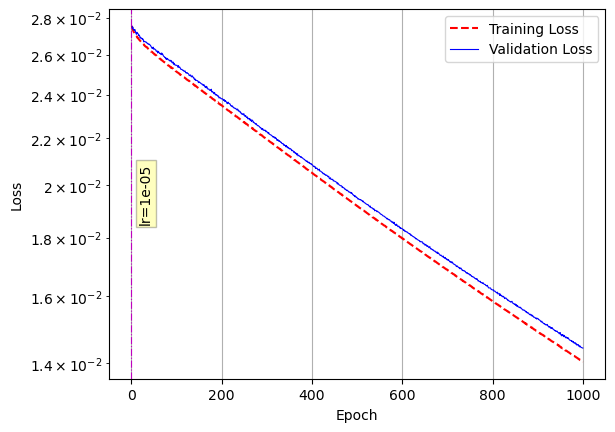

<Figure size 640x480 with 0 Axes>

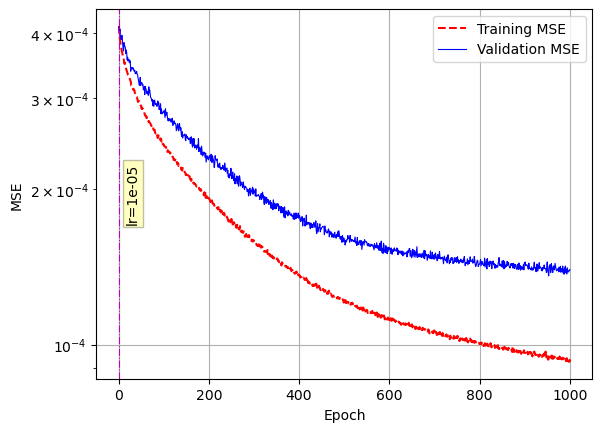

<Figure size 640x480 with 0 Axes>

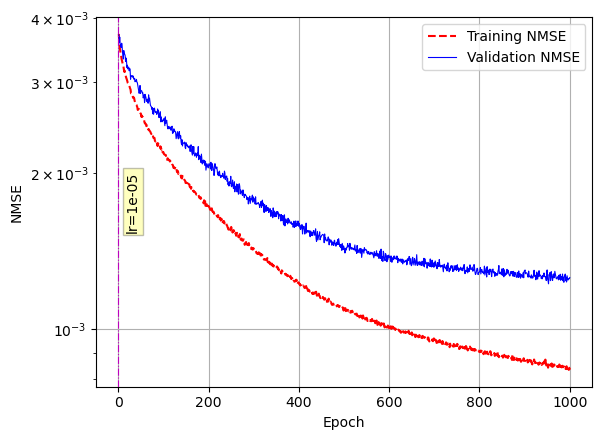

<Figure size 640x480 with 0 Axes>

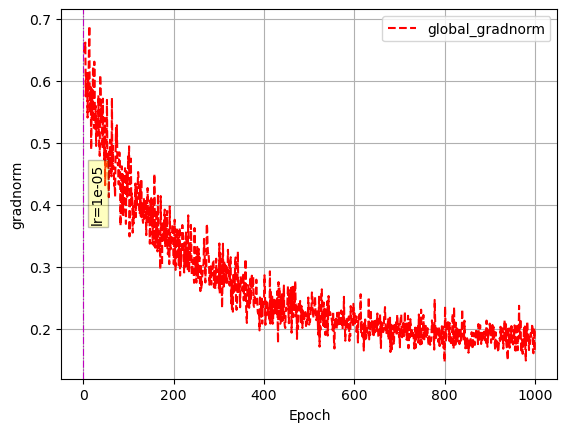

<Figure size 640x480 with 0 Axes>

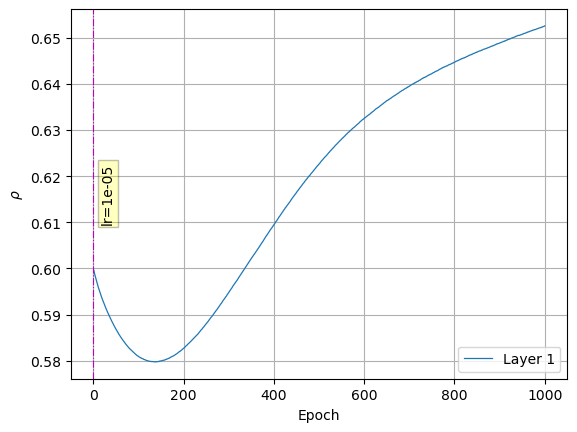

<Figure size 640x480 with 0 Axes>

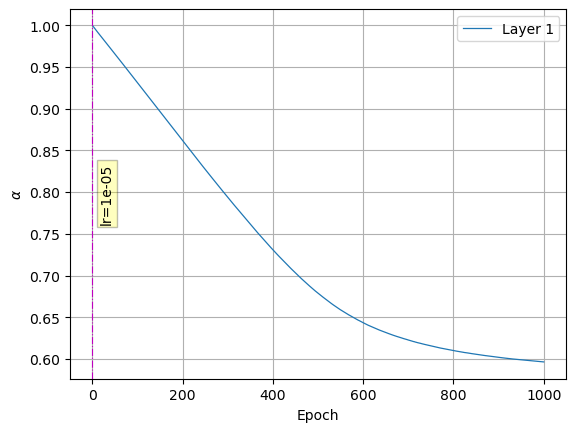

<Figure size 640x480 with 0 Axes>

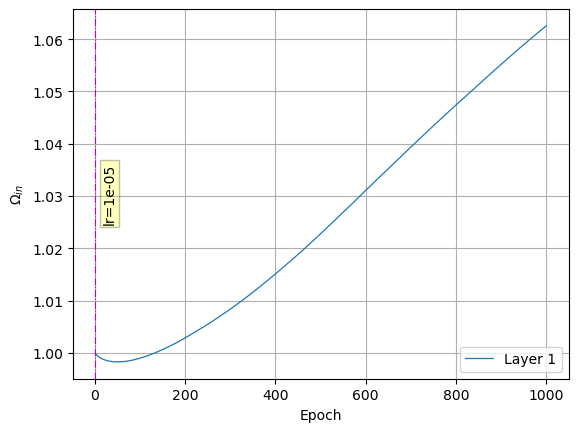



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.75
ListWrapper([True])
ListWrapper([True])
ListWrapper([True])


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 0.0207 - mse: 9.4102e-04 - NMSE: 0.0085 - covmat_fro_loss: 6.6477e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6522 - alpha_0: 0.5960 - omega_in_0: 1.0623 - tot_time: 0h 0m 44.8s

Epoch 1: val_NMSE improved from inf to 0.00564, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpo

Epoch 9/1000
71/71 [==============================] - ETA: 0s - loss: 0.0159 - mse: 3.3775e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9691e-04 - global_gradnorm: 0.7300 - rho_res_0: 0.6484 - alpha_0: 0.5935 - omega_in_0: 1.0608 - tot_time: 0h 5m 8.3s

Epoch 9: val_NMSE did not improve from 0.00341
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0159 - mse: 3.3775e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9659e-04 - global_gradnorm: 0.7296 - rho_res_0: 0.6484 - alpha_0: 0.5935 - omega_in_0: 1.0608 - val_loss: 0.0162 - val_mse: 3.8153e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6482 - val_alpha_0: 0.5934 - val_omega_in_0: 1.0607
Epoch 10/1000
71/71 [==============================] - ETA: 0s - loss: 0.0158 - mse: 3.3002e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9285e-0

Epoch 18/1000
71/71 [==============================] - ETA: 0s - loss: 0.0156 - mse: 3.0614e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7900e-04 - global_gradnorm: 0.7142 - rho_res_0: 0.6448 - alpha_0: 0.5917 - omega_in_0: 1.0600 - tot_time: 0h 10m 4.9s

Epoch 18: val_NMSE did not improve from 0.00313
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0156 - mse: 3.0614e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7902e-04 - global_gradnorm: 0.7147 - rho_res_0: 0.6448 - alpha_0: 0.5917 - omega_in_0: 1.0600 - val_loss: 0.0161 - val_mse: 3.6671e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6446 - val_alpha_0: 0.5916 - val_omega_in_0: 1.0599
Epoch 19/1000
71/71 [==============================] - ETA: 0s - loss: 0.0156 - mse: 3.0071e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7531

71/71 [==============================] - ETA: 0s - loss: 0.0154 - mse: 2.8016e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6358e-04 - global_gradnorm: 0.6681 - rho_res_0: 0.6413 - alpha_0: 0.5899 - omega_in_0: 1.0594 - tot_time: 0h 14m 58.3s

Epoch 27: val_NMSE improved from 0.00302 to 0.00296, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 469ms/step - loss: 0.0154 - mse: 2.8016e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6342e-04 - global_gradnorm: 0.6672 - rho_res_0: 0.6413 - alpha_0: 0.5899 - omega_in_0: 1.0594 - val_loss: 0.0158 - val_mse: 3.2869e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6411 - val_alpha_0: 0.5898 - val_omega_in_0: 1.0594
Epoch 28/1000
71/71 [=

Epoch 36/1000
71/71 [==============================] - ETA: 0s - loss: 0.0153 - mse: 2.6554e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5472e-04 - global_gradnorm: 0.6429 - rho_res_0: 0.6378 - alpha_0: 0.5880 - omega_in_0: 1.0590 - tot_time: 0h 19m 52.8s

Epoch 36: val_NMSE improved from 0.00289 to 0.00282, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 466ms/step - loss: 0.0153 - mse: 2.6554e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5482e-04 - global_gradnorm: 0.6431 - rho_res_0: 0.6378 - alpha_0: 0.5880 - omega_in_0: 1.0590 - val_loss: 0.0156 - val_mse: 3.1362e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6376 - val_alpha_0: 0.5879 - val_omega_in_0: 1.0589
Epoch 37

71/71 [==============================] - ETA: 0s - loss: 0.0152 - mse: 2.5574e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4878e-04 - global_gradnorm: 0.6288 - rho_res_0: 0.6345 - alpha_0: 0.5862 - omega_in_0: 1.0587 - tot_time: 0h 24m 45.7s

Epoch 45: val_NMSE did not improve from 0.00273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 456ms/step - loss: 0.0152 - mse: 2.5574e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4865e-04 - global_gradnorm: 0.6285 - rho_res_0: 0.6345 - alpha_0: 0.5862 - omega_in_0: 1.0587 - val_loss: 0.0156 - val_mse: 3.1380e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6343 - val_alpha_0: 0.5861 - val_omega_in_0: 1.0587
Epoch 46/1000
71/71 [==============================] - ETA: 0s - loss: 0.0152 - mse: 2.5598e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4872e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0151 - mse: 2.4715e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4342e-04 - global_gradnorm: 0.6268 - rho_res_0: 0.6313 - alpha_0: 0.5846 - omega_in_0: 1.0586 - val_loss: 0.0156 - val_mse: 3.0712e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6312 - val_alpha_0: 0.5845 - val_omega_in_0: 1.0586
Epoch 55/1000
71/71 [==============================] - ETA: 0s - loss: 0.0151 - mse: 2.4566e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4258e-04 - global_gradnorm: 0.6310 - rho_res_0: 0.6310 - alpha_0: 0.5844 - omega_in_0: 1.0586 - tot_time: 0h 30m 10.3s

Epoch 55: val_NMSE did not improve from 0.00270
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-

Epoch 64/1000
71/71 [==============================] - ETA: 0s - loss: 0.0150 - mse: 2.3612e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3540e-04 - global_gradnorm: 0.5986 - rho_res_0: 0.6281 - alpha_0: 0.5829 - omega_in_0: 1.0586 - tot_time: 0h 35m 3.3s

Epoch 64: val_NMSE improved from 0.00262 to 0.00262, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 34s 473ms/step - loss: 0.0150 - mse: 2.3612e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3523e-04 - global_gradnorm: 0.5993 - rho_res_0: 0.6281 - alpha_0: 0.5829 - omega_in_0: 1.0586 - val_loss: 0.0154 - val_mse: 2.9058e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6280 - val_alpha_0: 0.5829 - val_omega_in_0: 1.0586
Epoch 65/

71/71 [==============================] - ETA: 0s - loss: 0.0149 - mse: 2.2840e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3036e-04 - global_gradnorm: 0.5820 - rho_res_0: 0.6255 - alpha_0: 0.5816 - omega_in_0: 1.0587 - tot_time: 0h 39m 56.0s

Epoch 73: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 456ms/step - loss: 0.0149 - mse: 2.2840e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3056e-04 - global_gradnorm: 0.5828 - rho_res_0: 0.6255 - alpha_0: 0.5816 - omega_in_0: 1.0587 - val_loss: 0.0154 - val_mse: 2.9166e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6254 - val_alpha_0: 0.5815 - val_omega_in_0: 1.0587
Epoch 74/1000
71/71 [==============================] - ETA: 0s - loss: 0.0149 - mse: 2.3097e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3227e-04 - global

71/71 [==============================] - ETA: 0s - loss: 0.0149 - mse: 2.2488e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2822e-04 - global_gradnorm: 0.5910 - rho_res_0: 0.6232 - alpha_0: 0.5805 - omega_in_0: 1.0589 - tot_time: 0h 44m 48.2s

Epoch 82: val_NMSE improved from 0.00255 to 0.00253, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 466ms/step - loss: 0.0149 - mse: 2.2488e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2854e-04 - global_gradnorm: 0.5920 - rho_res_0: 0.6232 - alpha_0: 0.5805 - omega_in_0: 1.0589 - val_loss: 0.0153 - val_mse: 2.8067e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6230 - val_alpha_0: 0.5804 - val_omega_in_0: 1.0589
Epoch 83/1000
71/71 [=

71/71 [==============================] - ETA: 0s - loss: 0.0148 - mse: 2.2053e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2490e-04 - global_gradnorm: 0.5690 - rho_res_0: 0.6211 - alpha_0: 0.5794 - omega_in_0: 1.0591 - tot_time: 0h 49m 41.4s

Epoch 91: val_NMSE improved from 0.00251 to 0.00251, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 466ms/step - loss: 0.0148 - mse: 2.2053e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2491e-04 - global_gradnorm: 0.5688 - rho_res_0: 0.6211 - alpha_0: 0.5794 - omega_in_0: 1.0591 - val_loss: 0.0153 - val_mse: 2.7837e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6210 - val_alpha_0: 0.5793 - val_omega_in_0: 1.0591
Epoch 92/1000
71/71 [=

71/71 [==============================] - ETA: 0s - loss: 0.0148 - mse: 2.1757e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2319e-04 - global_gradnorm: 0.5646 - rho_res_0: 0.6193 - alpha_0: 0.5785 - omega_in_0: 1.0594 - tot_time: 0h 54m 33.4s

Epoch 100: val_NMSE did not improve from 0.00250
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0148 - mse: 2.1757e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2319e-04 - global_gradnorm: 0.5652 - rho_res_0: 0.6193 - alpha_0: 0.5785 - omega_in_0: 1.0594 - val_loss: 0.0153 - val_mse: 2.8470e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6193 - val_alpha_0: 0.5785 - val_omega_in_0: 1.0594
Epoch 101/1000
71/71 [==============================] - ETA: 0s - loss: 0.0148 - mse: 2.1693e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2311e-04 - glob

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0147 - mse: 2.1092e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1858e-04 - global_gradnorm: 0.5478 - rho_res_0: 0.6179 - alpha_0: 0.5776 - omega_in_0: 1.0597 - val_loss: 0.0152 - val_mse: 2.7893e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6178 - val_alpha_0: 0.5776 - val_omega_in_0: 1.0597
Epoch 110/1000
71/71 [==============================] - ETA: 0s - loss: 0.0147 - mse: 2.1225e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1974e-04 - global_gradnorm: 0.5510 - rho_res_0: 0.6178 - alpha_0: 0.5775 - omega_in_0: 1.0597 - tot_time: 0h 59m 58.1s

Epoch 110: val_NMSE improved from 0.00248 to 0.00246, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-10_outsteps
 - sav

Epoch 119/1000
71/71 [==============================] - ETA: 0s - loss: 0.0147 - mse: 2.1122e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1913e-04 - global_gradnorm: 0.5581 - rho_res_0: 0.6166 - alpha_0: 0.5767 - omega_in_0: 1.0600 - tot_time: 1h 4m 50.5s

Epoch 119: val_NMSE improved from 0.00244 to 0.00242, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 467ms/step - loss: 0.0147 - mse: 2.1122e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1889e-04 - global_gradnorm: 0.5564 - rho_res_0: 0.6166 - alpha_0: 0.5767 - omega_in_0: 1.0600 - val_loss: 0.0151 - val_mse: 2.6937e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6165 - val_alpha_0: 0.5767 - val_omega_in_0: 1.0601
Epoch 1

71/71 [==============================] - ETA: 0s - loss: 0.0146 - mse: 2.0442e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1382e-04 - global_gradnorm: 0.5333 - rho_res_0: 0.6155 - alpha_0: 0.5759 - omega_in_0: 1.0604 - tot_time: 1h 9m 42.5s

Epoch 128: val_NMSE did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0146 - mse: 2.0442e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1405e-04 - global_gradnorm: 0.5334 - rho_res_0: 0.6155 - alpha_0: 0.5759 - omega_in_0: 1.0604 - val_loss: 0.0151 - val_mse: 2.7434e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6155 - val_alpha_0: 0.5759 - val_omega_in_0: 1.0604
Epoch 129/1000
71/71 [==============================] - ETA: 0s - loss: 0.0146 - mse: 2.0535e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1448e-04 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 456ms/step - loss: 0.0145 - mse: 2.0022e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1103e-04 - global_gradnorm: 0.5196 - rho_res_0: 0.6148 - alpha_0: 0.5752 - omega_in_0: 1.0607 - val_loss: 0.0151 - val_mse: 2.7162e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6148 - val_alpha_0: 0.5752 - val_omega_in_0: 1.0607
Epoch 138/1000
71/71 [==============================] - ETA: 0s - loss: 0.0146 - mse: 2.0256e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1294e-04 - global_gradnorm: 0.5417 - rho_res_0: 0.6147 - alpha_0: 0.5751 - omega_in_0: 1.0607 - tot_time: 1h 15m 6.3s

Epoch 138: val_NMSE did not improve from 0.00240
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint

Epoch 147/1000
71/71 [==============================] - ETA: 0s - loss: 0.0145 - mse: 1.9818e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0960e-04 - global_gradnorm: 0.5193 - rho_res_0: 0.6140 - alpha_0: 0.5743 - omega_in_0: 1.0611 - tot_time: 1h 19m 59.2s

Epoch 147: val_NMSE did not improve from 0.00237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0145 - mse: 1.9818e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0948e-04 - global_gradnorm: 0.5189 - rho_res_0: 0.6140 - alpha_0: 0.5743 - omega_in_0: 1.0611 - val_loss: 0.0150 - val_mse: 2.6744e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6140 - val_alpha_0: 0.5743 - val_omega_in_0: 1.0611
Epoch 148/1000
71/71 [==============================] - ETA: 0s - loss: 0.0145 - mse: 1.9722e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0145 - mse: 1.9793e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0973e-04 - global_gradnorm: 0.5258 - rho_res_0: 0.6135 - alpha_0: 0.5736 - omega_in_0: 1.0614 - val_loss: 0.0150 - val_mse: 2.6659e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6135 - val_alpha_0: 0.5735 - val_omega_in_0: 1.0615
Epoch 157/1000
71/71 [==============================] - ETA: 0s - loss: 0.0145 - mse: 1.9505e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0714e-04 - global_gradnorm: 0.5158 - rho_res_0: 0.6134 - alpha_0: 0.5735 - omega_in_0: 1.0615 - tot_time: 1h 25m 23.0s

Epoch 157: val_NMSE did not improve from 0.00236
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoin

Epoch 166/1000
71/71 [==============================] - ETA: 0s - loss: 0.0144 - mse: 1.9616e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0804e-04 - global_gradnorm: 0.5252 - rho_res_0: 0.6130 - alpha_0: 0.5728 - omega_in_0: 1.0618 - tot_time: 1h 30m 15.4s

Epoch 166: val_NMSE did not improve from 0.00230
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0144 - mse: 1.9616e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0819e-04 - global_gradnorm: 0.5258 - rho_res_0: 0.6130 - alpha_0: 0.5728 - omega_in_0: 1.0618 - val_loss: 0.0150 - val_mse: 2.6338e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6130 - val_alpha_0: 0.5727 - val_omega_in_0: 1.0618
Epoch 167/1000
71/71 [==============================] - ETA: 0s - loss: 0.0144 - mse: 1.9697e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.

Epoch 176/1000
71/71 [==============================] - ETA: 0s - loss: 0.0144 - mse: 1.9267e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0555e-04 - global_gradnorm: 0.5218 - rho_res_0: 0.6126 - alpha_0: 0.5720 - omega_in_0: 1.0622 - tot_time: 1h 35m 39.1s

Epoch 176: val_NMSE did not improve from 0.00230
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0144 - mse: 1.9267e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0569e-04 - global_gradnorm: 0.5221 - rho_res_0: 0.6126 - alpha_0: 0.5720 - omega_in_0: 1.0622 - val_loss: 0.0149 - val_mse: 2.5664e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6126 - val_alpha_0: 0.5720 - val_omega_in_0: 1.0622
Epoch 177/1000
71/71 [==============================] - ETA: 0s - loss: 0.0144 - mse: 1.9167e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 34s 478ms/step - loss: 0.0143 - mse: 1.8694e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0125e-04 - global_gradnorm: 0.4872 - rho_res_0: 0.6124 - alpha_0: 0.5714 - omega_in_0: 1.0626 - val_loss: 0.0149 - val_mse: 2.5592e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6123 - val_alpha_0: 0.5713 - val_omega_in_0: 1.0626
Epoch 186/1000
71/71 [==============================] - ETA: 0s - loss: 0.0143 - mse: 1.8945e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0303e-04 - global_gradnorm: 0.5045 - rho_res_0: 0.6123 - alpha_0: 0.5713 - omega_in_0: 1.0626 - tot_time: 1h 41m 3.7s

Epoch 186: val_NMSE did not improve from 0.00230
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint

Epoch 195/1000
71/71 [==============================] - ETA: 0s - loss: 0.0143 - mse: 1.8729e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0122e-04 - global_gradnorm: 0.4979 - rho_res_0: 0.6121 - alpha_0: 0.5706 - omega_in_0: 1.0630 - tot_time: 1h 45m 54.9s

Epoch 195: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0143 - mse: 1.8729e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0178e-04 - global_gradnorm: 0.4986 - rho_res_0: 0.6121 - alpha_0: 0.5706 - omega_in_0: 1.0630 - val_loss: 0.0149 - val_mse: 2.6196e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6120 - val_alpha_0: 0.5705 - val_omega_in_0: 1.0630
Epoch 196/1000
71/71 [==============================] - ETA: 0s - loss: 0.0143 - mse: 1.8601e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0143 - mse: 1.8752e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0133e-04 - global_gradnorm: 0.5082 - rho_res_0: 0.6119 - alpha_0: 0.5700 - omega_in_0: 1.0633 - val_loss: 0.0148 - val_mse: 2.5997e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6118 - val_alpha_0: 0.5700 - val_omega_in_0: 1.0634
Epoch 205/1000
71/71 [==============================] - ETA: 0s - loss: 0.0143 - mse: 1.8678e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0102e-04 - global_gradnorm: 0.5078 - rho_res_0: 0.6118 - alpha_0: 0.5699 - omega_in_0: 1.0634 - tot_time: 1h 51m 18.2s

Epoch 205: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoin

Epoch 214/1000
71/71 [==============================] - ETA: 0s - loss: 0.0142 - mse: 1.8449e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9903e-04 - global_gradnorm: 0.5085 - rho_res_0: 0.6117 - alpha_0: 0.5693 - omega_in_0: 1.0638 - tot_time: 1h 56m 8.5s

Epoch 214: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0142 - mse: 1.8449e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9928e-04 - global_gradnorm: 0.5085 - rho_res_0: 0.6117 - alpha_0: 0.5693 - omega_in_0: 1.0638 - val_loss: 0.0148 - val_mse: 2.5796e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6117 - val_alpha_0: 0.5693 - val_omega_in_0: 1.0638
Epoch 215/1000
71/71 [==============================] - ETA: 0s - loss: 0.0142 - mse: 1.8325e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 456ms/step - loss: 0.0142 - mse: 1.8298e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9798e-04 - global_gradnorm: 0.4977 - rho_res_0: 0.6115 - alpha_0: 0.5687 - omega_in_0: 1.0641 - val_loss: 0.0148 - val_mse: 2.6072e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6115 - val_alpha_0: 0.5686 - val_omega_in_0: 1.0642
Epoch 224/1000
71/71 [==============================] - ETA: 0s - loss: 0.0142 - mse: 1.8177e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9715e-04 - global_gradnorm: 0.4922 - rho_res_0: 0.6115 - alpha_0: 0.5685 - omega_in_0: 1.0642 - tot_time: 2h 1m 32.2s

Epoch 224: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint

Epoch 233/1000
71/71 [==============================] - ETA: 0s - loss: 0.0141 - mse: 1.7922e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9514e-04 - global_gradnorm: 0.4867 - rho_res_0: 0.6114 - alpha_0: 0.5680 - omega_in_0: 1.0645 - tot_time: 2h 6m 23.7s

Epoch 233: val_NMSE did not improve from 0.00224
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0141 - mse: 1.7922e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9499e-04 - global_gradnorm: 0.4865 - rho_res_0: 0.6114 - alpha_0: 0.5680 - omega_in_0: 1.0645 - val_loss: 0.0148 - val_mse: 2.5753e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6114 - val_alpha_0: 0.5679 - val_omega_in_0: 1.0645
Epoch 234/1000
71/71 [==============================] - ETA: 0s - loss: 0.0141 - mse: 1.7914e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0141 - mse: 1.7829e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9426e-04 - global_gradnorm: 0.4847 - rho_res_0: 0.6113 - alpha_0: 0.5673 - omega_in_0: 1.0649 - val_loss: 0.0147 - val_mse: 2.5139e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6113 - val_alpha_0: 0.5673 - val_omega_in_0: 1.0650
Epoch 243/1000
71/71 [==============================] - ETA: 0s - loss: 0.0141 - mse: 1.7667e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9288e-04 - global_gradnorm: 0.4738 - rho_res_0: 0.6113 - alpha_0: 0.5673 - omega_in_0: 1.0650 - tot_time: 2h 11m 47.4s

Epoch 243: val_NMSE did not improve from 0.00223
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoin

Epoch 252/1000
71/71 [==============================] - ETA: 0s - loss: 0.0141 - mse: 1.7618e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9273e-04 - global_gradnorm: 0.4843 - rho_res_0: 0.6112 - alpha_0: 0.5667 - omega_in_0: 1.0653 - tot_time: 2h 16m 37.9s

Epoch 252: val_NMSE did not improve from 0.00223
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0141 - mse: 1.7618e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9255e-04 - global_gradnorm: 0.4841 - rho_res_0: 0.6112 - alpha_0: 0.5667 - omega_in_0: 1.0653 - val_loss: 0.0146 - val_mse: 2.4986e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6113 - val_alpha_0: 0.5667 - val_omega_in_0: 1.0653
Epoch 253/1000
71/71 [==============================] - ETA: 0s - loss: 0.0141 - mse: 1.7650e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 467ms/step - loss: 0.0140 - mse: 1.7543e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9197e-04 - global_gradnorm: 0.4800 - rho_res_0: 0.6112 - alpha_0: 0.5661 - omega_in_0: 1.0657 - val_loss: 0.0146 - val_mse: 2.4631e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6112 - val_alpha_0: 0.5661 - val_omega_in_0: 1.0657
Epoch 262/1000
71/71 [==============================] - ETA: 0s - loss: 0.0140 - mse: 1.7453e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9139e-04 - global_gradnorm: 0.4791 - rho_res_0: 0.6112 - alpha_0: 0.5661 - omega_in_0: 1.0657 - tot_time: 2h 22m 1.7s

Epoch 262: val_NMSE did not improve from 0.00222
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint

Epoch 271/1000
71/71 [==============================] - ETA: 0s - loss: 0.0140 - mse: 1.7356e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9083e-04 - global_gradnorm: 0.4801 - rho_res_0: 0.6111 - alpha_0: 0.5655 - omega_in_0: 1.0661 - tot_time: 2h 26m 52.3s

Epoch 271: val_NMSE did not improve from 0.00222
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0140 - mse: 1.7356e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9074e-04 - global_gradnorm: 0.4801 - rho_res_0: 0.6111 - alpha_0: 0.5655 - omega_in_0: 1.0661 - val_loss: 0.0146 - val_mse: 2.4684e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6111 - val_alpha_0: 0.5655 - val_omega_in_0: 1.0662
Epoch 272/1000
71/71 [==============================] - ETA: 0s - loss: 0.0140 - mse: 1.7246e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0140 - mse: 1.7226e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.8983e-04 - global_gradnorm: 0.4764 - rho_res_0: 0.6111 - alpha_0: 0.5649 - omega_in_0: 1.0665 - val_loss: 0.0146 - val_mse: 2.5186e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6111 - val_alpha_0: 0.5649 - val_omega_in_0: 1.0665
Epoch 281/1000
71/71 [==============================] - ETA: 0s - loss: 0.0140 - mse: 1.7344e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9061e-04 - global_gradnorm: 0.4798 - rho_res_0: 0.6111 - alpha_0: 0.5649 - omega_in_0: 1.0666 - tot_time: 2h 32m 16.0s

Epoch 281: val_NMSE did not improve from 0.00220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoin

Epoch 290/1000
71/71 [==============================] - ETA: 0s - loss: 0.0139 - mse: 1.7089e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8852e-04 - global_gradnorm: 0.4721 - rho_res_0: 0.6111 - alpha_0: 0.5643 - omega_in_0: 1.0669 - tot_time: 2h 37m 6.7s

Epoch 290: val_NMSE did not improve from 0.00220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0139 - mse: 1.7089e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8878e-04 - global_gradnorm: 0.4728 - rho_res_0: 0.6111 - alpha_0: 0.5643 - omega_in_0: 1.0669 - val_loss: 0.0145 - val_mse: 2.4582e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6111 - val_alpha_0: 0.5643 - val_omega_in_0: 1.0670
Epoch 291/1000
71/71 [==============================] - ETA: 0s - loss: 0.0139 - mse: 1.6912e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8

Epoch 300/1000
71/71 [==============================] - ETA: 0s - loss: 0.0139 - mse: 1.7079e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8857e-04 - global_gradnorm: 0.4804 - rho_res_0: 0.6111 - alpha_0: 0.5638 - omega_in_0: 1.0674 - tot_time: 2h 42m 29.5s

Epoch 300: val_NMSE did not improve from 0.00220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0139 - mse: 1.7079e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8864e-04 - global_gradnorm: 0.4808 - rho_res_0: 0.6111 - alpha_0: 0.5638 - omega_in_0: 1.0674 - val_loss: 0.0146 - val_mse: 2.5517e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6111 - val_alpha_0: 0.5637 - val_omega_in_0: 1.0674
Epoch 301/1000
71/71 [==============================] - ETA: 0s - loss: 0.0139 - mse: 1.6881e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 456ms/step - loss: 0.0138 - mse: 1.6767e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8580e-04 - global_gradnorm: 0.4625 - rho_res_0: 0.6111 - alpha_0: 0.5632 - omega_in_0: 1.0678 - val_loss: 0.0145 - val_mse: 2.5112e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6111 - val_alpha_0: 0.5632 - val_omega_in_0: 1.0678
Epoch 310/1000
71/71 [==============================] - ETA: 0s - loss: 0.0138 - mse: 1.6707e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8514e-04 - global_gradnorm: 0.4618 - rho_res_0: 0.6111 - alpha_0: 0.5632 - omega_in_0: 1.0678 - tot_time: 2h 47m 53.1s

Epoch 310: val_NMSE did not improve from 0.00218
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoin

Epoch 319/1000
71/71 [==============================] - ETA: 0s - loss: 0.0138 - mse: 1.6704e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8527e-04 - global_gradnorm: 0.4658 - rho_res_0: 0.6111 - alpha_0: 0.5626 - omega_in_0: 1.0682 - tot_time: 2h 52m 44.5s

Epoch 319: val_NMSE did not improve from 0.00218
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0138 - mse: 1.6704e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8534e-04 - global_gradnorm: 0.4657 - rho_res_0: 0.6111 - alpha_0: 0.5626 - omega_in_0: 1.0682 - val_loss: 0.0145 - val_mse: 2.4844e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6111 - val_alpha_0: 0.5626 - val_omega_in_0: 1.0682
Epoch 320/1000
71/71 [==============================] - ETA: 0s - loss: 0.0138 - mse: 1.6695e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.

Epoch 329/1000
71/71 [==============================] - ETA: 0s - loss: 0.0138 - mse: 1.6650e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8478e-04 - global_gradnorm: 0.4697 - rho_res_0: 0.6111 - alpha_0: 0.5620 - omega_in_0: 1.0686 - tot_time: 2h 58m 7.3s

Epoch 329: val_NMSE did not improve from 0.00218
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0138 - mse: 1.6650e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8518e-04 - global_gradnorm: 0.4707 - rho_res_0: 0.6111 - alpha_0: 0.5620 - omega_in_0: 1.0686 - val_loss: 0.0145 - val_mse: 2.5358e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6111 - val_alpha_0: 0.5621 - val_omega_in_0: 1.0686
Epoch 330/1000
71/71 [==============================] - ETA: 0s - loss: 0.0138 - mse: 1.6547e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0138 - mse: 1.6593e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8462e-04 - global_gradnorm: 0.4738 - rho_res_0: 0.6112 - alpha_0: 0.5616 - omega_in_0: 1.0690 - val_loss: 0.0144 - val_mse: 2.4619e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6112 - val_alpha_0: 0.5615 - val_omega_in_0: 1.0690
Epoch 339/1000
71/71 [==============================] - ETA: 0s - loss: 0.0137 - mse: 1.6402e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8287e-04 - global_gradnorm: 0.4599 - rho_res_0: 0.6112 - alpha_0: 0.5615 - omega_in_0: 1.0691 - tot_time: 3h 3m 30.7s

Epoch 339: val_NMSE did not improve from 0.00213
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint

Epoch 348/1000
71/71 [==============================] - ETA: 0s - loss: 0.0137 - mse: 1.6315e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8220e-04 - global_gradnorm: 0.4592 - rho_res_0: 0.6112 - alpha_0: 0.5610 - omega_in_0: 1.0694 - tot_time: 3h 8m 21.2s

Epoch 348: val_NMSE did not improve from 0.00213
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0137 - mse: 1.6315e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8210e-04 - global_gradnorm: 0.4593 - rho_res_0: 0.6112 - alpha_0: 0.5610 - omega_in_0: 1.0694 - val_loss: 0.0143 - val_mse: 2.4355e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6112 - val_alpha_0: 0.5610 - val_omega_in_0: 1.0695
Epoch 349/1000
71/71 [==============================] - ETA: 0s - loss: 0.0137 - mse: 1.6183e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8

Epoch 358/1000
71/71 [==============================] - ETA: 0s - loss: 0.0137 - mse: 1.6170e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8114e-04 - global_gradnorm: 0.4561 - rho_res_0: 0.6113 - alpha_0: 0.5605 - omega_in_0: 1.0699 - tot_time: 3h 13m 44.1s

Epoch 358: val_NMSE did not improve from 0.00213
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0137 - mse: 1.6170e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8128e-04 - global_gradnorm: 0.4553 - rho_res_0: 0.6112 - alpha_0: 0.5605 - omega_in_0: 1.0699 - val_loss: 0.0144 - val_mse: 2.5320e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6112 - val_alpha_0: 0.5604 - val_omega_in_0: 1.0699
Epoch 359/1000
71/71 [==============================] - ETA: 0s - loss: 0.0137 - mse: 1.6175e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.

Epoch 368/1000
71/71 [==============================] - ETA: 0s - loss: 0.0136 - mse: 1.6086e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.8010e-04 - global_gradnorm: 0.4543 - rho_res_0: 0.6113 - alpha_0: 0.5599 - omega_in_0: 1.0703 - tot_time: 3h 19m 7.1s

Epoch 368: val_NMSE did not improve from 0.00213
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0136 - mse: 1.6086e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.8030e-04 - global_gradnorm: 0.4556 - rho_res_0: 0.6113 - alpha_0: 0.5599 - omega_in_0: 1.0703 - val_loss: 0.0143 - val_mse: 2.4058e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6114 - val_alpha_0: 0.5599 - val_omega_in_0: 1.0703
Epoch 369/1000
71/71 [==============================] - ETA: 0s - loss: 0.0136 - mse: 1.5945e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7

Epoch 378/1000
71/71 [==============================] - ETA: 0s - loss: 0.0136 - mse: 1.5973e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7962e-04 - global_gradnorm: 0.4507 - rho_res_0: 0.6114 - alpha_0: 0.5595 - omega_in_0: 1.0708 - tot_time: 3h 24m 30.1s

Epoch 378: val_NMSE did not improve from 0.00213
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0136 - mse: 1.5973e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7963e-04 - global_gradnorm: 0.4502 - rho_res_0: 0.6114 - alpha_0: 0.5595 - omega_in_0: 1.0708 - val_loss: 0.0143 - val_mse: 2.4625e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6114 - val_alpha_0: 0.5595 - val_omega_in_0: 1.0708
Epoch 379/1000
71/71 [==============================] - ETA: 0s - loss: 0.0136 - mse: 1.6021e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0136 - mse: 1.5699e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7680e-04 - global_gradnorm: 0.4442 - rho_res_0: 0.6115 - alpha_0: 0.5591 - omega_in_0: 1.0712 - val_loss: 0.0142 - val_mse: 2.4275e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6115 - val_alpha_0: 0.5591 - val_omega_in_0: 1.0712
Epoch 388/1000
71/71 [==============================] - ETA: 0s - loss: 0.0136 - mse: 1.5759e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7784e-04 - global_gradnorm: 0.4456 - rho_res_0: 0.6115 - alpha_0: 0.5590 - omega_in_0: 1.0712 - tot_time: 3h 29m 54.2s

Epoch 388: val_NMSE improved from 0.00212 to 0.00211, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-10_outsteps
 - sav

Epoch 397/1000
71/71 [==============================] - ETA: 0s - loss: 0.0135 - mse: 1.5688e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7699e-04 - global_gradnorm: 0.4439 - rho_res_0: 0.6115 - alpha_0: 0.5586 - omega_in_0: 1.0716 - tot_time: 3h 34m 46.8s

Epoch 397: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0135 - mse: 1.5688e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7681e-04 - global_gradnorm: 0.4433 - rho_res_0: 0.6115 - alpha_0: 0.5586 - omega_in_0: 1.0716 - val_loss: 0.0142 - val_mse: 2.4528e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6115 - val_alpha_0: 0.5586 - val_omega_in_0: 1.0716
Epoch 398/1000
71/71 [==============================] - ETA: 0s - loss: 0.0135 - mse: 1.5766e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.

Epoch 407/1000
71/71 [==============================] - ETA: 0s - loss: 0.0135 - mse: 1.5424e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7461e-04 - global_gradnorm: 0.4285 - rho_res_0: 0.6115 - alpha_0: 0.5582 - omega_in_0: 1.0720 - tot_time: 3h 40m 9.7s

Epoch 407: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0135 - mse: 1.5424e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7470e-04 - global_gradnorm: 0.4280 - rho_res_0: 0.6115 - alpha_0: 0.5582 - omega_in_0: 1.0720 - val_loss: 0.0142 - val_mse: 2.4253e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6116 - val_alpha_0: 0.5582 - val_omega_in_0: 1.0720
Epoch 408/1000
71/71 [==============================] - ETA: 0s - loss: 0.0135 - mse: 1.5595e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7

Epoch 417/1000
71/71 [==============================] - ETA: 0s - loss: 0.0135 - mse: 1.5584e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7567e-04 - global_gradnorm: 0.4496 - rho_res_0: 0.6116 - alpha_0: 0.5577 - omega_in_0: 1.0724 - tot_time: 3h 45m 32.5s

Epoch 417: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0135 - mse: 1.5584e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7567e-04 - global_gradnorm: 0.4492 - rho_res_0: 0.6116 - alpha_0: 0.5577 - omega_in_0: 1.0724 - val_loss: 0.0141 - val_mse: 2.3960e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6116 - val_alpha_0: 0.5577 - val_omega_in_0: 1.0724
Epoch 418/1000
71/71 [==============================] - ETA: 0s - loss: 0.0135 - mse: 1.5492e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.

Epoch 427/1000
71/71 [==============================] - ETA: 0s - loss: 0.0135 - mse: 1.5795e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7763e-04 - global_gradnorm: 0.4696 - rho_res_0: 0.6118 - alpha_0: 0.5574 - omega_in_0: 1.0729 - tot_time: 3h 50m 55.2s

Epoch 427: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0135 - mse: 1.5795e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7722e-04 - global_gradnorm: 0.4685 - rho_res_0: 0.6118 - alpha_0: 0.5574 - omega_in_0: 1.0729 - val_loss: 0.0141 - val_mse: 2.4367e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6118 - val_alpha_0: 0.5573 - val_omega_in_0: 1.0729
Epoch 428/1000
71/71 [==============================] - ETA: 0s - loss: 0.0134 - mse: 1.5143e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.

Epoch 437/1000
71/71 [==============================] - ETA: 0s - loss: 0.0134 - mse: 1.5221e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7292e-04 - global_gradnorm: 0.4333 - rho_res_0: 0.6117 - alpha_0: 0.5569 - omega_in_0: 1.0733 - tot_time: 3h 56m 18.9s

Epoch 437: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0134 - mse: 1.5221e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7298e-04 - global_gradnorm: 0.4342 - rho_res_0: 0.6117 - alpha_0: 0.5569 - omega_in_0: 1.0733 - val_loss: 0.0141 - val_mse: 2.4811e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6118 - val_alpha_0: 0.5569 - val_omega_in_0: 1.0733
Epoch 438/1000
71/71 [==============================] - ETA: 0s - loss: 0.0134 - mse: 1.5324e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.

71/71 [==============================] - ETA: 0s - loss: 0.0133 - mse: 1.5118e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7186e-04 - global_gradnorm: 0.4294 - rho_res_0: 0.6118 - alpha_0: 0.5565 - omega_in_0: 1.0737 - tot_time: 4h 1m 11.0s

Epoch 446: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0133 - mse: 1.5118e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7191e-04 - global_gradnorm: 0.4292 - rho_res_0: 0.6118 - alpha_0: 0.5565 - omega_in_0: 1.0737 - val_loss: 0.0140 - val_mse: 2.3728e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6118 - val_alpha_0: 0.5565 - val_omega_in_0: 1.0737
Epoch 447/1000
71/71 [==============================] - ETA: 0s - loss: 0.0133 - mse: 1.5193e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7255e-04 - globa

Epoch 456/1000
71/71 [==============================] - ETA: 0s - loss: 0.0133 - mse: 1.5086e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7151e-04 - global_gradnorm: 0.4242 - rho_res_0: 0.6119 - alpha_0: 0.5561 - omega_in_0: 1.0741 - tot_time: 4h 6m 33.6s

Epoch 456: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0133 - mse: 1.5086e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7150e-04 - global_gradnorm: 0.4247 - rho_res_0: 0.6119 - alpha_0: 0.5561 - omega_in_0: 1.0741 - val_loss: 0.0140 - val_mse: 2.3720e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6119 - val_alpha_0: 0.5561 - val_omega_in_0: 1.0741
Epoch 457/1000
71/71 [==============================] - ETA: 0s - loss: 0.0133 - mse: 1.5134e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7

Epoch 466/1000
71/71 [==============================] - ETA: 0s - loss: 0.0133 - mse: 1.5059e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7154e-04 - global_gradnorm: 0.4328 - rho_res_0: 0.6120 - alpha_0: 0.5557 - omega_in_0: 1.0745 - tot_time: 4h 11m 56.0s

Epoch 466: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0133 - mse: 1.5059e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7150e-04 - global_gradnorm: 0.4323 - rho_res_0: 0.6120 - alpha_0: 0.5557 - omega_in_0: 1.0745 - val_loss: 0.0139 - val_mse: 2.3476e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6120 - val_alpha_0: 0.5556 - val_omega_in_0: 1.0745
Epoch 467/1000
71/71 [==============================] - ETA: 0s - loss: 0.0133 - mse: 1.5060e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.

71/71 [==============================] - ETA: 0s - loss: 0.0133 - mse: 1.5007e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7124e-04 - global_gradnorm: 0.4337 - rho_res_0: 0.6121 - alpha_0: 0.5554 - omega_in_0: 1.0749 - tot_time: 4h 16m 48.7s

Epoch 475: val_NMSE did not improve from 0.00208
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0133 - mse: 1.5007e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7151e-04 - global_gradnorm: 0.4348 - rho_res_0: 0.6121 - alpha_0: 0.5554 - omega_in_0: 1.0749 - val_loss: 0.0139 - val_mse: 2.3739e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6121 - val_alpha_0: 0.5554 - val_omega_in_0: 1.0749
Epoch 476/1000
71/71 [==============================] - ETA: 0s - loss: 0.0132 - mse: 1.4887e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6958e-04 - glob

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0132 - mse: 1.4979e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.7025e-04 - global_gradnorm: 0.4307 - rho_res_0: 0.6122 - alpha_0: 0.5550 - omega_in_0: 1.0753 - val_loss: 0.0139 - val_mse: 2.3389e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6121 - val_alpha_0: 0.5549 - val_omega_in_0: 1.0753
Epoch 485/1000
71/71 [==============================] - ETA: 0s - loss: 0.0132 - mse: 1.4766e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6886e-04 - global_gradnorm: 0.4217 - rho_res_0: 0.6122 - alpha_0: 0.5549 - omega_in_0: 1.0753 - tot_time: 4h 22m 12.0s

Epoch 485: val_NMSE did not improve from 0.00207
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoin

Epoch 494/1000
71/71 [==============================] - ETA: 0s - loss: 0.0132 - mse: 1.5060e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7151e-04 - global_gradnorm: 0.4471 - rho_res_0: 0.6123 - alpha_0: 0.5546 - omega_in_0: 1.0757 - tot_time: 4h 27m 3.1s

Epoch 494: val_NMSE did not improve from 0.00205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0132 - mse: 1.5060e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7155e-04 - global_gradnorm: 0.4468 - rho_res_0: 0.6123 - alpha_0: 0.5546 - omega_in_0: 1.0757 - val_loss: 0.0138 - val_mse: 2.3199e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6122 - val_alpha_0: 0.5545 - val_omega_in_0: 1.0757
Epoch 495/1000
71/71 [==============================] - ETA: 0s - loss: 0.0132 - mse: 1.4878e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6

Epoch 504/1000
71/71 [==============================] - ETA: 0s - loss: 0.0132 - mse: 1.4697e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6806e-04 - global_gradnorm: 0.4254 - rho_res_0: 0.6123 - alpha_0: 0.5542 - omega_in_0: 1.0761 - tot_time: 4h 32m 25.7s

Epoch 504: val_NMSE improved from 0.00205 to 0.00204, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 465ms/step - loss: 0.0132 - mse: 1.4697e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6813e-04 - global_gradnorm: 0.4244 - rho_res_0: 0.6123 - alpha_0: 0.5542 - omega_in_0: 1.0761 - val_loss: 0.0138 - val_mse: 2.2711e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6123 - val_alpha_0: 0.5542 - val_omega_in_0: 1.0762
Epoch 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 456ms/step - loss: 0.0131 - mse: 1.4562e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6667e-04 - global_gradnorm: 0.4165 - rho_res_0: 0.6124 - alpha_0: 0.5539 - omega_in_0: 1.0765 - val_loss: 0.0138 - val_mse: 2.3618e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6124 - val_alpha_0: 0.5539 - val_omega_in_0: 1.0765
Epoch 514/1000
71/71 [==============================] - ETA: 0s - loss: 0.0131 - mse: 1.4551e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6671e-04 - global_gradnorm: 0.4189 - rho_res_0: 0.6124 - alpha_0: 0.5539 - omega_in_0: 1.0766 - tot_time: 4h 37m 49.0s

Epoch 514: val_NMSE did not improve from 0.00204
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoin

Epoch 523/1000
71/71 [==============================] - ETA: 0s - loss: 0.0131 - mse: 1.4435e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6605e-04 - global_gradnorm: 0.4108 - rho_res_0: 0.6125 - alpha_0: 0.5536 - omega_in_0: 1.0769 - tot_time: 4h 42m 39.2s

Epoch 523: val_NMSE did not improve from 0.00204
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0131 - mse: 1.4435e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6595e-04 - global_gradnorm: 0.4104 - rho_res_0: 0.6125 - alpha_0: 0.5536 - omega_in_0: 1.0769 - val_loss: 0.0138 - val_mse: 2.3075e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6125 - val_alpha_0: 0.5535 - val_omega_in_0: 1.0769
Epoch 524/1000
71/71 [==============================] - ETA: 0s - loss: 0.0131 - mse: 1.4599e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.

Epoch 533/1000
71/71 [==============================] - ETA: 0s - loss: 0.0131 - mse: 1.4574e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6692e-04 - global_gradnorm: 0.4264 - rho_res_0: 0.6125 - alpha_0: 0.5532 - omega_in_0: 1.0774 - tot_time: 4h 48m 1.8s

Epoch 533: val_NMSE did not improve from 0.00204
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0131 - mse: 1.4574e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6690e-04 - global_gradnorm: 0.4261 - rho_res_0: 0.6125 - alpha_0: 0.5532 - omega_in_0: 1.0774 - val_loss: 0.0137 - val_mse: 2.2711e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6125 - val_alpha_0: 0.5532 - val_omega_in_0: 1.0774
Epoch 534/1000
71/71 [==============================] - ETA: 0s - loss: 0.0130 - mse: 1.4270e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0130 - mse: 1.4382e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6529e-04 - global_gradnorm: 0.4158 - rho_res_0: 0.6126 - alpha_0: 0.5529 - omega_in_0: 1.0777 - val_loss: 0.0137 - val_mse: 2.3501e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6126 - val_alpha_0: 0.5529 - val_omega_in_0: 1.0778
Epoch 543/1000
71/71 [==============================] - ETA: 0s - loss: 0.0130 - mse: 1.4536e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6681e-04 - global_gradnorm: 0.4267 - rho_res_0: 0.6127 - alpha_0: 0.5529 - omega_in_0: 1.0778 - tot_time: 4h 53m 25.3s

Epoch 543: val_NMSE did not improve from 0.00204
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoin

Epoch 552/1000
71/71 [==============================] - ETA: 0s - loss: 0.0130 - mse: 1.4443e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6597e-04 - global_gradnorm: 0.4258 - rho_res_0: 0.6128 - alpha_0: 0.5526 - omega_in_0: 1.0782 - tot_time: 4h 58m 16.3s

Epoch 552: val_NMSE did not improve from 0.00203
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0130 - mse: 1.4443e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6619e-04 - global_gradnorm: 0.4257 - rho_res_0: 0.6128 - alpha_0: 0.5526 - omega_in_0: 1.0782 - val_loss: 0.0137 - val_mse: 2.3940e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6128 - val_alpha_0: 0.5525 - val_omega_in_0: 1.0782
Epoch 553/1000
71/71 [==============================] - ETA: 0s - loss: 0.0130 - mse: 1.4506e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.

Epoch 562/1000
71/71 [==============================] - ETA: 0s - loss: 0.0130 - mse: 1.4525e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6645e-04 - global_gradnorm: 0.4326 - rho_res_0: 0.6128 - alpha_0: 0.5523 - omega_in_0: 1.0786 - tot_time: 5h 3m 38.8s

Epoch 562: val_NMSE did not improve from 0.00203
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0130 - mse: 1.4525e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6628e-04 - global_gradnorm: 0.4336 - rho_res_0: 0.6128 - alpha_0: 0.5522 - omega_in_0: 1.0786 - val_loss: 0.0137 - val_mse: 2.3673e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6128 - val_alpha_0: 0.5522 - val_omega_in_0: 1.0786
Epoch 563/1000
71/71 [==============================] - ETA: 0s - loss: 0.0129 - mse: 1.4171e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6

Epoch 572/1000
71/71 [==============================] - ETA: 0s - loss: 0.0129 - mse: 1.4288e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6437e-04 - global_gradnorm: 0.4245 - rho_res_0: 0.6129 - alpha_0: 0.5519 - omega_in_0: 1.0790 - tot_time: 5h 9m 1.2s

Epoch 572: val_NMSE did not improve from 0.00203
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0129 - mse: 1.4288e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6413e-04 - global_gradnorm: 0.4240 - rho_res_0: 0.6129 - alpha_0: 0.5519 - omega_in_0: 1.0790 - val_loss: 0.0137 - val_mse: 2.3624e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6129 - val_alpha_0: 0.5519 - val_omega_in_0: 1.0790
Epoch 573/1000
71/71 [==============================] - ETA: 0s - loss: 0.0129 - mse: 1.4120e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.62

Epoch 582/1000
71/71 [==============================] - ETA: 0s - loss: 0.0129 - mse: 1.4403e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6529e-04 - global_gradnorm: 0.4262 - rho_res_0: 0.6130 - alpha_0: 0.5516 - omega_in_0: 1.0794 - tot_time: 5h 14m 23.6s

Epoch 582: val_NMSE did not improve from 0.00203
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0129 - mse: 1.4403e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6504e-04 - global_gradnorm: 0.4264 - rho_res_0: 0.6130 - alpha_0: 0.5516 - omega_in_0: 1.0794 - val_loss: 0.0136 - val_mse: 2.3049e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6130 - val_alpha_0: 0.5516 - val_omega_in_0: 1.0794
Epoch 583/1000
71/71 [==============================] - ETA: 0s - loss: 0.0129 - mse: 1.4316e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.

Epoch 592/1000
71/71 [==============================] - ETA: 0s - loss: 0.0129 - mse: 1.4065e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6228e-04 - global_gradnorm: 0.4132 - rho_res_0: 0.6131 - alpha_0: 0.5513 - omega_in_0: 1.0798 - tot_time: 5h 19m 46.0s

Epoch 592: val_NMSE did not improve from 0.00203
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0129 - mse: 1.4065e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6217e-04 - global_gradnorm: 0.4127 - rho_res_0: 0.6131 - alpha_0: 0.5513 - omega_in_0: 1.0798 - val_loss: 0.0136 - val_mse: 2.3375e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6131 - val_alpha_0: 0.5513 - val_omega_in_0: 1.0799
Epoch 593/1000
71/71 [==============================] - ETA: 0s - loss: 0.0129 - mse: 1.4247e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.

Epoch 602/1000
71/71 [==============================] - ETA: 0s - loss: 0.0128 - mse: 1.3948e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6113e-04 - global_gradnorm: 0.4064 - rho_res_0: 0.6132 - alpha_0: 0.5510 - omega_in_0: 1.0802 - tot_time: 5h 25m 8.3s

Epoch 602: val_NMSE did not improve from 0.00203
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0128 - mse: 1.3948e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6091e-04 - global_gradnorm: 0.4063 - rho_res_0: 0.6132 - alpha_0: 0.5510 - omega_in_0: 1.0802 - val_loss: 0.0135 - val_mse: 2.2909e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6132 - val_alpha_0: 0.5510 - val_omega_in_0: 1.0803
Epoch 603/1000
71/71 [==============================] - ETA: 0s - loss: 0.0128 - mse: 1.3803e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.6

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0128 - mse: 1.4041e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6202e-04 - global_gradnorm: 0.4202 - rho_res_0: 0.6133 - alpha_0: 0.5507 - omega_in_0: 1.0806 - val_loss: 0.0135 - val_mse: 2.2840e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6133 - val_alpha_0: 0.5507 - val_omega_in_0: 1.0807
Epoch 612/1000
71/71 [==============================] - ETA: 0s - loss: 0.0128 - mse: 1.3936e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6112e-04 - global_gradnorm: 0.4042 - rho_res_0: 0.6133 - alpha_0: 0.5507 - omega_in_0: 1.0807 - tot_time: 5h 30m 31.5s

Epoch 612: val_NMSE did not improve from 0.00199
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoin

Epoch 621/1000
71/71 [==============================] - ETA: 0s - loss: 0.0127 - mse: 1.3758e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5967e-04 - global_gradnorm: 0.4015 - rho_res_0: 0.6134 - alpha_0: 0.5505 - omega_in_0: 1.0811 - tot_time: 5h 35m 21.7s

Epoch 621: val_NMSE did not improve from 0.00199
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0127 - mse: 1.3758e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5979e-04 - global_gradnorm: 0.4024 - rho_res_0: 0.6134 - alpha_0: 0.5505 - omega_in_0: 1.0811 - val_loss: 0.0135 - val_mse: 2.3262e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6133 - val_alpha_0: 0.5504 - val_omega_in_0: 1.0811
Epoch 622/1000
71/71 [==============================] - ETA: 0s - loss: 0.0128 - mse: 1.4092e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.

Epoch 631/1000
71/71 [==============================] - ETA: 0s - loss: 0.0127 - mse: 1.3510e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5749e-04 - global_gradnorm: 0.3844 - rho_res_0: 0.6134 - alpha_0: 0.5502 - omega_in_0: 1.0815 - tot_time: 5h 40m 44.1s

Epoch 631: val_NMSE did not improve from 0.00199
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0127 - mse: 1.3510e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5757e-04 - global_gradnorm: 0.3840 - rho_res_0: 0.6134 - alpha_0: 0.5502 - omega_in_0: 1.0815 - val_loss: 0.0135 - val_mse: 2.3140e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6134 - val_alpha_0: 0.5501 - val_omega_in_0: 1.0815
Epoch 632/1000
71/71 [==============================] - ETA: 0s - loss: 0.0127 - mse: 1.3777e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0127 - mse: 1.3695e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5885e-04 - global_gradnorm: 0.4003 - rho_res_0: 0.6135 - alpha_0: 0.5499 - omega_in_0: 1.0818 - val_loss: 0.0134 - val_mse: 2.2643e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6135 - val_alpha_0: 0.5499 - val_omega_in_0: 1.0819
Epoch 641/1000
71/71 [==============================] - ETA: 0s - loss: 0.0127 - mse: 1.3475e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5703e-04 - global_gradnorm: 0.3877 - rho_res_0: 0.6135 - alpha_0: 0.5499 - omega_in_0: 1.0819 - tot_time: 5h 46m 7.4s

Epoch 641: val_NMSE did not improve from 0.00199
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint

Epoch 650/1000
71/71 [==============================] - ETA: 0s - loss: 0.0127 - mse: 1.3959e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6113e-04 - global_gradnorm: 0.4249 - rho_res_0: 0.6136 - alpha_0: 0.5496 - omega_in_0: 1.0823 - tot_time: 5h 50m 57.5s

Epoch 650: val_NMSE did not improve from 0.00199
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0127 - mse: 1.3959e-04 - NMSE: 0.0013 - covmat_fro_loss: 2.6113e-04 - global_gradnorm: 0.4241 - rho_res_0: 0.6136 - alpha_0: 0.5496 - omega_in_0: 1.0823 - val_loss: 0.0134 - val_mse: 2.2498e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6136 - val_alpha_0: 0.5496 - val_omega_in_0: 1.0823
Epoch 651/1000
71/71 [==============================] - ETA: 0s - loss: 0.0127 - mse: 1.3625e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.

Epoch 660/1000
71/71 [==============================] - ETA: 0s - loss: 0.0126 - mse: 1.3594e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5843e-04 - global_gradnorm: 0.4002 - rho_res_0: 0.6138 - alpha_0: 0.5494 - omega_in_0: 1.0827 - tot_time: 5h 56m 19.9s

Epoch 660: val_NMSE did not improve from 0.00199
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0126 - mse: 1.3594e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5856e-04 - global_gradnorm: 0.4002 - rho_res_0: 0.6138 - alpha_0: 0.5494 - omega_in_0: 1.0827 - val_loss: 0.0134 - val_mse: 2.2815e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6137 - val_alpha_0: 0.5493 - val_omega_in_0: 1.0827
Epoch 661/1000
71/71 [==============================] - ETA: 0s - loss: 0.0126 - mse: 1.3602e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.

Epoch 670/1000
71/71 [==============================] - ETA: 0s - loss: 0.0126 - mse: 1.3581e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5796e-04 - global_gradnorm: 0.4054 - rho_res_0: 0.6138 - alpha_0: 0.5492 - omega_in_0: 1.0831 - tot_time: 6h 1m 42.4s

Epoch 670: val_NMSE did not improve from 0.00199
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0126 - mse: 1.3581e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5811e-04 - global_gradnorm: 0.4051 - rho_res_0: 0.6138 - alpha_0: 0.5492 - omega_in_0: 1.0831 - val_loss: 0.0133 - val_mse: 2.3087e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6138 - val_alpha_0: 0.5491 - val_omega_in_0: 1.0831
Epoch 671/1000
71/71 [==============================] - ETA: 0s - loss: 0.0126 - mse: 1.3578e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5

Epoch 680/1000
71/71 [==============================] - ETA: 0s - loss: 0.0126 - mse: 1.3523e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5756e-04 - global_gradnorm: 0.3974 - rho_res_0: 0.6139 - alpha_0: 0.5488 - omega_in_0: 1.0835 - tot_time: 6h 7m 5.9s

Epoch 680: val_NMSE did not improve from 0.00199
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0126 - mse: 1.3523e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5734e-04 - global_gradnorm: 0.3966 - rho_res_0: 0.6139 - alpha_0: 0.5488 - omega_in_0: 1.0835 - val_loss: 0.0133 - val_mse: 2.2513e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6139 - val_alpha_0: 0.5488 - val_omega_in_0: 1.0835
Epoch 681/1000
71/71 [==============================] - ETA: 0s - loss: 0.0126 - mse: 1.3530e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.57

Epoch 690/1000
71/71 [==============================] - ETA: 0s - loss: 0.0125 - mse: 1.3666e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5859e-04 - global_gradnorm: 0.4143 - rho_res_0: 0.6140 - alpha_0: 0.5486 - omega_in_0: 1.0839 - tot_time: 6h 12m 28.2s

Epoch 690: val_NMSE did not improve from 0.00199
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0125 - mse: 1.3666e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5856e-04 - global_gradnorm: 0.4141 - rho_res_0: 0.6140 - alpha_0: 0.5486 - omega_in_0: 1.0839 - val_loss: 0.0133 - val_mse: 2.3074e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6140 - val_alpha_0: 0.5486 - val_omega_in_0: 1.0839
Epoch 691/1000
71/71 [==============================] - ETA: 0s - loss: 0.0125 - mse: 1.3416e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.

Epoch 700/1000
71/71 [==============================] - ETA: 0s - loss: 0.0125 - mse: 1.3405e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5626e-04 - global_gradnorm: 0.4044 - rho_res_0: 0.6141 - alpha_0: 0.5484 - omega_in_0: 1.0843 - tot_time: 6h 17m 50.9s

Epoch 700: val_NMSE did not improve from 0.00199
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0125 - mse: 1.3405e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5627e-04 - global_gradnorm: 0.4049 - rho_res_0: 0.6141 - alpha_0: 0.5484 - omega_in_0: 1.0843 - val_loss: 0.0132 - val_mse: 2.2535e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6141 - val_alpha_0: 0.5484 - val_omega_in_0: 1.0843
Epoch 701/1000
71/71 [==============================] - ETA: 0s - loss: 0.0125 - mse: 1.3240e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 456ms/step - loss: 0.0125 - mse: 1.3227e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5468e-04 - global_gradnorm: 0.3885 - rho_res_0: 0.6142 - alpha_0: 0.5482 - omega_in_0: 1.0847 - val_loss: 0.0132 - val_mse: 2.2297e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6142 - val_alpha_0: 0.5482 - val_omega_in_0: 1.0847
Epoch 710/1000
71/71 [==============================] - ETA: 0s - loss: 0.0125 - mse: 1.3321e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5535e-04 - global_gradnorm: 0.3969 - rho_res_0: 0.6142 - alpha_0: 0.5481 - omega_in_0: 1.0847 - tot_time: 6h 23m 14.6s

Epoch 710: val_NMSE did not improve from 0.00198
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoin

Epoch 719/1000
71/71 [==============================] - ETA: 0s - loss: 0.0124 - mse: 1.3345e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5529e-04 - global_gradnorm: 0.4016 - rho_res_0: 0.6143 - alpha_0: 0.5479 - omega_in_0: 1.0851 - tot_time: 6h 28m 4.9s

Epoch 719: val_NMSE did not improve from 0.00198
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0124 - mse: 1.3345e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5534e-04 - global_gradnorm: 0.4022 - rho_res_0: 0.6143 - alpha_0: 0.5479 - omega_in_0: 1.0851 - val_loss: 0.0132 - val_mse: 2.2855e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6143 - val_alpha_0: 0.5479 - val_omega_in_0: 1.0851
Epoch 720/1000
71/71 [==============================] - ETA: 0s - loss: 0.0124 - mse: 1.3412e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5

Epoch 729/1000
71/71 [==============================] - ETA: 0s - loss: 0.0124 - mse: 1.3322e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5545e-04 - global_gradnorm: 0.4031 - rho_res_0: 0.6144 - alpha_0: 0.5477 - omega_in_0: 1.0855 - tot_time: 6h 33m 27.3s

Epoch 729: val_NMSE did not improve from 0.00198
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 455ms/step - loss: 0.0124 - mse: 1.3322e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5547e-04 - global_gradnorm: 0.4028 - rho_res_0: 0.6144 - alpha_0: 0.5477 - omega_in_0: 1.0855 - val_loss: 0.0131 - val_mse: 2.2164e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6144 - val_alpha_0: 0.5477 - val_omega_in_0: 1.0856
Epoch 730/1000
71/71 [==============================] - ETA: 0s - loss: 0.0124 - mse: 1.3339e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0124 - mse: 1.3159e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5391e-04 - global_gradnorm: 0.3897 - rho_res_0: 0.6145 - alpha_0: 0.5475 - omega_in_0: 1.0859 - val_loss: 0.0131 - val_mse: 2.2810e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6146 - val_alpha_0: 0.5475 - val_omega_in_0: 1.0860
Epoch 739/1000
71/71 [==============================] - ETA: 0s - loss: 0.0124 - mse: 1.3105e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5339e-04 - global_gradnorm: 0.3917 - rho_res_0: 0.6146 - alpha_0: 0.5475 - omega_in_0: 1.0860 - tot_time: 6h 38m 50.7s

Epoch 739: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoin

Epoch 748/1000
71/71 [==============================] - ETA: 0s - loss: 0.0123 - mse: 1.3121e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5343e-04 - global_gradnorm: 0.3898 - rho_res_0: 0.6146 - alpha_0: 0.5473 - omega_in_0: 1.0863 - tot_time: 6h 43m 41.3s

Epoch 748: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 456ms/step - loss: 0.0123 - mse: 1.3121e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5360e-04 - global_gradnorm: 0.3905 - rho_res_0: 0.6146 - alpha_0: 0.5473 - omega_in_0: 1.0863 - val_loss: 0.0131 - val_mse: 2.2909e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6146 - val_alpha_0: 0.5472 - val_omega_in_0: 1.0863
Epoch 749/1000
71/71 [==============================] - ETA: 0s - loss: 0.0124 - mse: 1.3514e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.

Epoch 758/1000
71/71 [==============================] - ETA: 0s - loss: 0.0123 - mse: 1.3005e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5236e-04 - global_gradnorm: 0.3833 - rho_res_0: 0.6147 - alpha_0: 0.5470 - omega_in_0: 1.0867 - tot_time: 6h 49m 7.7s

Epoch 758: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0123 - mse: 1.3005e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5234e-04 - global_gradnorm: 0.3829 - rho_res_0: 0.6147 - alpha_0: 0.5470 - omega_in_0: 1.0867 - val_loss: 0.0130 - val_mse: 2.2459e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6147 - val_alpha_0: 0.5470 - val_omega_in_0: 1.0867
Epoch 759/1000
71/71 [==============================] - ETA: 0s - loss: 0.0123 - mse: 1.2922e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5

Epoch 768/1000
71/71 [==============================] - ETA: 0s - loss: 0.0123 - mse: 1.3058e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5284e-04 - global_gradnorm: 0.3928 - rho_res_0: 0.6148 - alpha_0: 0.5469 - omega_in_0: 1.0871 - tot_time: 6h 54m 30.8s

Epoch 768: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0123 - mse: 1.3058e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5311e-04 - global_gradnorm: 0.3944 - rho_res_0: 0.6148 - alpha_0: 0.5469 - omega_in_0: 1.0871 - val_loss: 0.0130 - val_mse: 2.2602e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6148 - val_alpha_0: 0.5469 - val_omega_in_0: 1.0871
Epoch 769/1000
71/71 [==============================] - ETA: 0s - loss: 0.0123 - mse: 1.3000e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.

Epoch 778/1000
71/71 [==============================] - ETA: 0s - loss: 0.0122 - mse: 1.2940e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5174e-04 - global_gradnorm: 0.3916 - rho_res_0: 0.6149 - alpha_0: 0.5467 - omega_in_0: 1.0875 - tot_time: 6h 59m 54.0s

Epoch 778: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0122 - mse: 1.2940e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5162e-04 - global_gradnorm: 0.3911 - rho_res_0: 0.6149 - alpha_0: 0.5467 - omega_in_0: 1.0875 - val_loss: 0.0130 - val_mse: 2.2229e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6149 - val_alpha_0: 0.5466 - val_omega_in_0: 1.0875
Epoch 779/1000
71/71 [==============================] - ETA: 0s - loss: 0.0122 - mse: 1.3024e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.

Epoch 788/1000
71/71 [==============================] - ETA: 0s - loss: 0.0122 - mse: 1.2977e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5231e-04 - global_gradnorm: 0.3954 - rho_res_0: 0.6150 - alpha_0: 0.5465 - omega_in_0: 1.0879 - tot_time: 7h 5m 16.0s

Epoch 788: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 453ms/step - loss: 0.0122 - mse: 1.2977e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5270e-04 - global_gradnorm: 0.3962 - rho_res_0: 0.6150 - alpha_0: 0.5465 - omega_in_0: 1.0879 - val_loss: 0.0129 - val_mse: 2.2189e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6150 - val_alpha_0: 0.5464 - val_omega_in_0: 1.0880
Epoch 789/1000
71/71 [==============================] - ETA: 0s - loss: 0.0122 - mse: 1.2967e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5

Epoch 798/1000
71/71 [==============================] - ETA: 0s - loss: 0.0122 - mse: 1.2818e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5062e-04 - global_gradnorm: 0.3799 - rho_res_0: 0.6151 - alpha_0: 0.5462 - omega_in_0: 1.0883 - tot_time: 7h 10m 38.1s

Epoch 798: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0122 - mse: 1.2818e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5073e-04 - global_gradnorm: 0.3800 - rho_res_0: 0.6151 - alpha_0: 0.5462 - omega_in_0: 1.0883 - val_loss: 0.0129 - val_mse: 2.2615e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6151 - val_alpha_0: 0.5462 - val_omega_in_0: 1.0884
Epoch 799/1000
71/71 [==============================] - ETA: 0s - loss: 0.0122 - mse: 1.2684e-04 - NMSE: 0.0011 - covmat_fro_loss: 2.

Epoch 808/1000
71/71 [==============================] - ETA: 0s - loss: 0.0121 - mse: 1.2843e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5074e-04 - global_gradnorm: 0.3796 - rho_res_0: 0.6152 - alpha_0: 0.5460 - omega_in_0: 1.0887 - tot_time: 7h 16m 0.1s

Epoch 808: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 453ms/step - loss: 0.0121 - mse: 1.2843e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5072e-04 - global_gradnorm: 0.3799 - rho_res_0: 0.6152 - alpha_0: 0.5460 - omega_in_0: 1.0887 - val_loss: 0.0129 - val_mse: 2.2105e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6152 - val_alpha_0: 0.5460 - val_omega_in_0: 1.0888
Epoch 809/1000
71/71 [==============================] - ETA: 0s - loss: 0.0121 - mse: 1.2700e-04 - NMSE: 0.0011 - covmat_fro_loss: 2.4

Epoch 818/1000
71/71 [==============================] - ETA: 0s - loss: 0.0121 - mse: 1.2864e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5107e-04 - global_gradnorm: 0.3884 - rho_res_0: 0.6153 - alpha_0: 0.5459 - omega_in_0: 1.0892 - tot_time: 7h 21m 21.9s

Epoch 818: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 453ms/step - loss: 0.0121 - mse: 1.2864e-04 - NMSE: 0.0012 - covmat_fro_loss: 2.5135e-04 - global_gradnorm: 0.3888 - rho_res_0: 0.6153 - alpha_0: 0.5459 - omega_in_0: 1.0892 - val_loss: 0.0129 - val_mse: 2.2288e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6153 - val_alpha_0: 0.5459 - val_omega_in_0: 1.0892
Epoch 819/1000
71/71 [==============================] - ETA: 0s - loss: 0.0121 - mse: 1.2755e-04 - NMSE: 0.0011 - covmat_fro_loss: 2.

Epoch 828/1000
71/71 [==============================] - ETA: 0s - loss: 0.0121 - mse: 1.2704e-04 - NMSE: 0.0011 - covmat_fro_loss: 2.4939e-04 - global_gradnorm: 0.3828 - rho_res_0: 0.6154 - alpha_0: 0.5457 - omega_in_0: 1.0896 - tot_time: 7h 26m 43.8s

Epoch 828: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 32s 454ms/step - loss: 0.0121 - mse: 1.2704e-04 - NMSE: 0.0011 - covmat_fro_loss: 2.4958e-04 - global_gradnorm: 0.3838 - rho_res_0: 0.6154 - alpha_0: 0.5457 - omega_in_0: 1.0896 - val_loss: 0.0128 - val_mse: 2.1693e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6154 - val_alpha_0: 0.5458 - val_omega_in_0: 1.0896
Epoch 829/1000
71/71 [==============================] - ETA: 0s - loss: 0.0121 - mse: 1.2635e-04 - NMSE: 0.0011 - covmat_fro_loss: 2.

<Figure size 640x480 with 0 Axes>

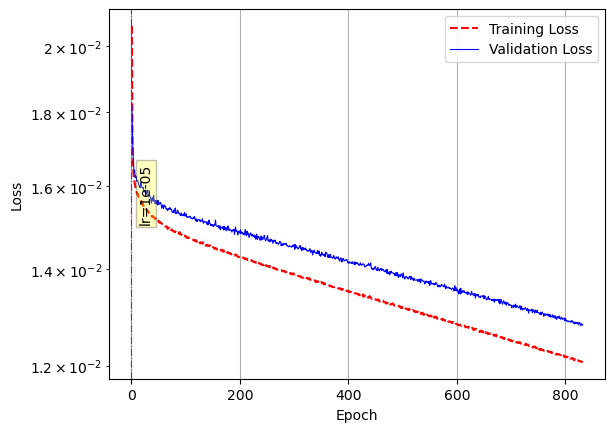

<Figure size 640x480 with 0 Axes>

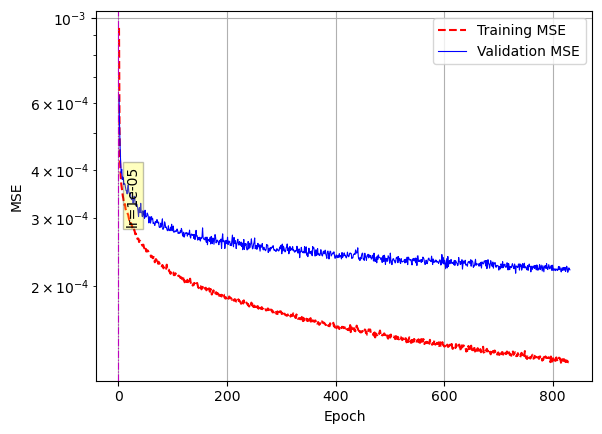

<Figure size 640x480 with 0 Axes>

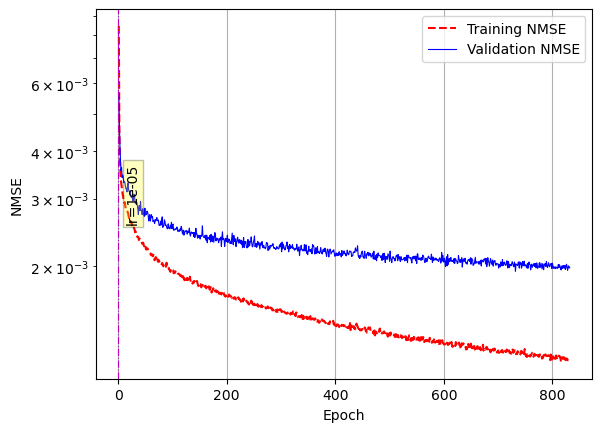

<Figure size 640x480 with 0 Axes>

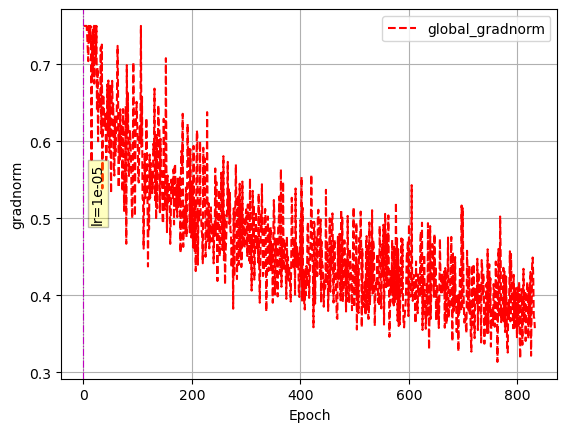

<Figure size 640x480 with 0 Axes>

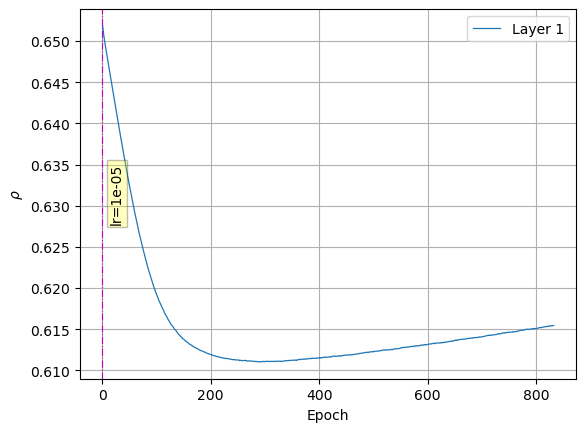

<Figure size 640x480 with 0 Axes>

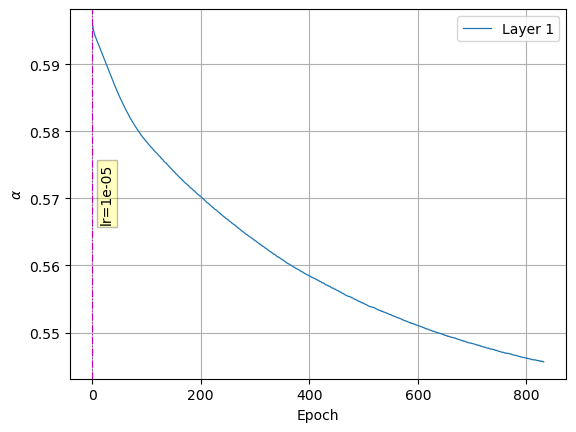

<Figure size 640x480 with 0 Axes>

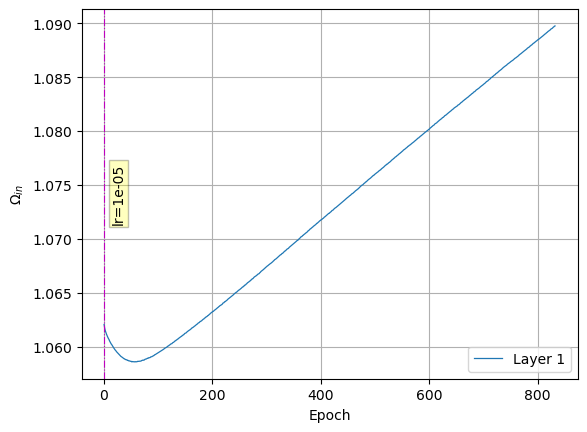



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.75
ListWrapper([True])
ListWrapper([True])
ListWrapper([True])


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
58/58 [==============================] - ETA: 0s - loss: 0.0457 - mse: 0.0057 - NMSE: 0.0516 - covmat_fro_loss: 0.0038 - global_gradnorm: 0.7500 - rho_res_0: 0.6144 - alpha_0: 0.5475 - omega_in_0: 1.0856 - tot_time: 0h 1m 11.4s

Epoch 1: val_NMSE improved from inf to 0.04372, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-30_o

Epoch 9/1000
58/58 [==============================] - ETA: 0s - loss: 0.0186 - mse: 0.0012 - NMSE: 0.0111 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.6137 - alpha_0: 0.5468 - omega_in_0: 1.0850 - tot_time: 0h 5m 55.4s

Epoch 9: val_NMSE improved from 0.01271 to 0.01271, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 611ms/step - loss: 0.0186 - mse: 0.0012 - NMSE: 0.0111 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.6137 - alpha_0: 0.5468 - omega_in_0: 1.0850 - val_loss: 0.0196 - val_mse: 0.0014 - val_NMSE: 0.0127 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6136 - val_alpha_0: 0.5468 - val_omega_in_0: 1.0850
Epoch 10/1000
58/58 [==========

Epoch 18/1000
58/58 [==============================] - ETA: 0s - loss: 0.0173 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.6131 - alpha_0: 0.5462 - omega_in_0: 1.0847 - tot_time: 0h 11m 11.1s

Epoch 18: val_NMSE did not improve from 0.01111
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 590ms/step - loss: 0.0173 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.6131 - alpha_0: 0.5462 - omega_in_0: 1.0847 - val_loss: 0.0187 - val_mse: 0.0013 - val_NMSE: 0.0113 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6131 - val_alpha_0: 0.5462 - val_omega_in_0: 1.0847
Epoch 19/1000
58/58 [==============================] - ETA: 0s - loss: 0.0173 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7

58/58 [==============================] - ETA: 0s - loss: 0.0169 - mse: 9.3698e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.6126 - alpha_0: 0.5458 - omega_in_0: 1.0845 - tot_time: 0h 16m 23.0s

Epoch 27: val_NMSE did not improve from 0.01054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 593ms/step - loss: 0.0169 - mse: 9.3698e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.6126 - alpha_0: 0.5458 - omega_in_0: 1.0845 - val_loss: 0.0185 - val_mse: 0.0012 - val_NMSE: 0.0110 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6126 - val_alpha_0: 0.5458 - val_omega_in_0: 1.0845
Epoch 28/1000
58/58 [==============================] - ETA: 0s - loss: 0.0169 - mse: 9.4167e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.750

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 593ms/step - loss: 0.0167 - mse: 9.0435e-04 - NMSE: 0.0081 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.6121 - alpha_0: 0.5455 - omega_in_0: 1.0843 - val_loss: 0.0184 - val_mse: 0.0012 - val_NMSE: 0.0108 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6121 - val_alpha_0: 0.5454 - val_omega_in_0: 1.0843
Epoch 37/1000
58/58 [==============================] - ETA: 0s - loss: 0.0167 - mse: 9.0085e-04 - NMSE: 0.0081 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.6121 - alpha_0: 0.5454 - omega_in_0: 1.0843 - tot_time: 0h 22m 8.4s

Epoch 37: val_NMSE did not improve from 0.01039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
5

Epoch 46/1000
58/58 [==============================] - ETA: 0s - loss: 0.0165 - mse: 8.6653e-04 - NMSE: 0.0078 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.6116 - alpha_0: 0.5450 - omega_in_0: 1.0841 - tot_time: 0h 27m 19.5s

Epoch 46: val_NMSE did not improve from 0.01023
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0165 - mse: 8.6653e-04 - NMSE: 0.0078 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.6116 - alpha_0: 0.5450 - omega_in_0: 1.0841 - val_loss: 0.0182 - val_mse: 0.0012 - val_NMSE: 0.0105 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6116 - val_alpha_0: 0.5450 - val_omega_in_0: 1.0841
Epoch 47/1000
58/58 [==============================] - ETA: 0s - loss: 0.0165 - mse: 8.6549e-04 - NMSE: 0.0078 - covmat_fro_loss: 0.0011 - global_g

Epoch 56/1000
58/58 [==============================] - ETA: 0s - loss: 0.0164 - mse: 8.4913e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6111 - alpha_0: 0.5447 - omega_in_0: 1.0839 - tot_time: 0h 33m 3.7s

Epoch 56: val_NMSE did not improve from 0.01018
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0164 - mse: 8.4913e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6111 - alpha_0: 0.5447 - omega_in_0: 1.0839 - val_loss: 0.0182 - val_mse: 0.0012 - val_NMSE: 0.0105 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6111 - val_alpha_0: 0.5446 - val_omega_in_0: 1.0839
Epoch 57/1000
58/58 [==============================] - ETA: 0s - loss: 0.0163 - mse: 8.3524e-04 - NMSE: 0.0075 - covmat_fro_loss: 0.0011 - global_gr

Epoch 66/1000
58/58 [==============================] - ETA: 0s - loss: 0.0162 - mse: 8.2058e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6106 - alpha_0: 0.5443 - omega_in_0: 1.0837 - tot_time: 0h 38m 46.9s

Epoch 66: val_NMSE did not improve from 0.01018
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0162 - mse: 8.2058e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6106 - alpha_0: 0.5443 - omega_in_0: 1.0837 - val_loss: 0.0181 - val_mse: 0.0011 - val_NMSE: 0.0103 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6106 - val_alpha_0: 0.5443 - val_omega_in_0: 1.0837
Epoch 67/1000
58/58 [==============================] - ETA: 0s - loss: 0.0162 - mse: 8.2211e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - global_g

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 593ms/step - loss: 0.0161 - mse: 8.0741e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6101 - alpha_0: 0.5439 - omega_in_0: 1.0835 - val_loss: 0.0179 - val_mse: 0.0011 - val_NMSE: 0.0101 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6101 - val_alpha_0: 0.5439 - val_omega_in_0: 1.0835
Epoch 76/1000
58/58 [==============================] - ETA: 0s - loss: 0.0161 - mse: 8.0099e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6101 - alpha_0: 0.5439 - omega_in_0: 1.0835 - tot_time: 0h 44m 31.1s

Epoch 76: val_NMSE did not improve from 0.00985
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps


Epoch 85/1000
58/58 [==============================] - ETA: 0s - loss: 0.0161 - mse: 7.9656e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6096 - alpha_0: 0.5436 - omega_in_0: 1.0833 - tot_time: 0h 49m 41.2s

Epoch 85: val_NMSE did not improve from 0.00984
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 589ms/step - loss: 0.0161 - mse: 7.9656e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6096 - alpha_0: 0.5436 - omega_in_0: 1.0833 - val_loss: 0.0180 - val_mse: 0.0011 - val_NMSE: 0.0103 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6096 - val_alpha_0: 0.5435 - val_omega_in_0: 1.0833
Epoch 86/1000
58/58 [==============================] - ETA: 0s - loss: 0.0160 - mse: 7.8887e-04 - NMSE: 0.0071 - covmat_fro_loss: 0.0011 - global_g

Epoch 95/1000
58/58 [==============================] - ETA: 0s - loss: 0.0160 - mse: 7.7916e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6091 - alpha_0: 0.5432 - omega_in_0: 1.0831 - tot_time: 0h 55m 25.3s

Epoch 95: val_NMSE did not improve from 0.00983
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 593ms/step - loss: 0.0160 - mse: 7.7916e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6091 - alpha_0: 0.5432 - omega_in_0: 1.0831 - val_loss: 0.0178 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6091 - val_alpha_0: 0.5431 - val_omega_in_0: 1.0831
Epoch 96/1000
58/58 [==============================] - ETA: 0s - loss: 0.0160 - mse: 7.8132e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0011 - global_g

Epoch 105/1000
58/58 [==============================] - ETA: 0s - loss: 0.0159 - mse: 7.6951e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6087 - alpha_0: 0.5428 - omega_in_0: 1.0829 - tot_time: 1h 1m 8.4s

Epoch 105: val_NMSE did not improve from 0.00983
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0159 - mse: 7.6951e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6087 - alpha_0: 0.5428 - omega_in_0: 1.0829 - val_loss: 0.0180 - val_mse: 0.0011 - val_NMSE: 0.0103 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6086 - val_alpha_0: 0.5428 - val_omega_in_0: 1.0829
Epoch 106/1000
58/58 [==============================] - ETA: 0s - loss: 0.0159 - mse: 7.6391e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_

Epoch 115/1000
58/58 [==============================] - ETA: 0s - loss: 0.0158 - mse: 7.5660e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6082 - alpha_0: 0.5425 - omega_in_0: 1.0827 - tot_time: 1h 6m 51.6s

Epoch 115: val_NMSE did not improve from 0.00983
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0158 - mse: 7.5660e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6082 - alpha_0: 0.5425 - omega_in_0: 1.0827 - val_loss: 0.0178 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6082 - val_alpha_0: 0.5424 - val_omega_in_0: 1.0827
Epoch 116/1000
58/58 [==============================] - ETA: 0s - loss: 0.0158 - mse: 7.5255e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 593ms/step - loss: 0.0158 - mse: 7.4818e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6078 - alpha_0: 0.5422 - omega_in_0: 1.0825 - val_loss: 0.0180 - val_mse: 0.0011 - val_NMSE: 0.0103 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6078 - val_alpha_0: 0.5421 - val_omega_in_0: 1.0825
Epoch 125/1000
58/58 [==============================] - ETA: 0s - loss: 0.0158 - mse: 7.4673e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6078 - alpha_0: 0.5421 - omega_in_0: 1.0825 - tot_time: 1h 12m 37.3s

Epoch 125: val_NMSE did not improve from 0.00975
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outstep

Epoch 134/1000
58/58 [==============================] - ETA: 0s - loss: 0.0157 - mse: 7.2797e-04 - NMSE: 0.0066 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6074 - alpha_0: 0.5418 - omega_in_0: 1.0823 - tot_time: 1h 17m 47.4s

Epoch 134: val_NMSE did not improve from 0.00970
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0157 - mse: 7.2797e-04 - NMSE: 0.0066 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6074 - alpha_0: 0.5418 - omega_in_0: 1.0823 - val_loss: 0.0179 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6074 - val_alpha_0: 0.5418 - val_omega_in_0: 1.0823
Epoch 135/1000
58/58 [==============================] - ETA: 0s - loss: 0.0157 - mse: 7.2691e-04 - NMSE: 0.0065 - covmat_fro_loss: 0.0011 - globa

Epoch 144/1000
58/58 [==============================] - ETA: 0s - loss: 0.0156 - mse: 7.2084e-04 - NMSE: 0.0065 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6070 - alpha_0: 0.5415 - omega_in_0: 1.0822 - tot_time: 1h 23m 30.5s

Epoch 144: val_NMSE did not improve from 0.00970
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0156 - mse: 7.2084e-04 - NMSE: 0.0065 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6070 - alpha_0: 0.5415 - omega_in_0: 1.0822 - val_loss: 0.0178 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6070 - val_alpha_0: 0.5415 - val_omega_in_0: 1.0822
Epoch 145/1000
58/58 [==============================] - ETA: 0s - loss: 0.0156 - mse: 7.1543e-04 - NMSE: 0.0064 - covmat_fro_loss: 0.0011 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0156 - mse: 7.1186e-04 - NMSE: 0.0064 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6067 - alpha_0: 0.5413 - omega_in_0: 1.0820 - val_loss: 0.0179 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6067 - val_alpha_0: 0.5413 - val_omega_in_0: 1.0820
Epoch 154/1000
58/58 [==============================] - ETA: 0s - loss: 0.0156 - mse: 7.1694e-04 - NMSE: 0.0065 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.7500 - rho_res_0: 0.6067 - alpha_0: 0.5412 - omega_in_0: 1.0820 - tot_time: 1h 29m 15.8s

Epoch 154: val_NMSE did not improve from 0.00954
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outstep

Epoch 163/1000
58/58 [==============================] - ETA: 0s - loss: 0.0155 - mse: 7.0305e-04 - NMSE: 0.0063 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6064 - alpha_0: 0.5410 - omega_in_0: 1.0819 - tot_time: 1h 34m 24.7s

Epoch 163: val_NMSE did not improve from 0.00954
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 594ms/step - loss: 0.0155 - mse: 7.0305e-04 - NMSE: 0.0063 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6064 - alpha_0: 0.5410 - omega_in_0: 1.0819 - val_loss: 0.0178 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6063 - val_alpha_0: 0.5410 - val_omega_in_0: 1.0819
Epoch 164/1000
58/58 [==============================] - ETA: 0s - loss: 0.0155 - mse: 7.0096e-04 - NMSE: 0.0063 - covmat_fro_loss: 0.0010 - globa

Epoch 173/1000
58/58 [==============================] - ETA: 0s - loss: 0.0155 - mse: 6.9586e-04 - NMSE: 0.0063 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6060 - alpha_0: 0.5407 - omega_in_0: 1.0818 - tot_time: 1h 40m 8.4s

Epoch 173: val_NMSE did not improve from 0.00953
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 594ms/step - loss: 0.0155 - mse: 6.9586e-04 - NMSE: 0.0063 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6060 - alpha_0: 0.5407 - omega_in_0: 1.0818 - val_loss: 0.0180 - val_mse: 0.0011 - val_NMSE: 0.0102 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6060 - val_alpha_0: 0.5407 - val_omega_in_0: 1.0818
Epoch 174/1000
58/58 [==============================] - ETA: 0s - loss: 0.0155 - mse: 6.9296e-04 - NMSE: 0.0062 - covmat_fro_loss: 0.0010 - global

Epoch 183/1000
58/58 [==============================] - ETA: 0s - loss: 0.0154 - mse: 6.8975e-04 - NMSE: 0.0062 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6057 - alpha_0: 0.5405 - omega_in_0: 1.0816 - tot_time: 1h 45m 53.2s

Epoch 183: val_NMSE did not improve from 0.00949
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0154 - mse: 6.8975e-04 - NMSE: 0.0062 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6057 - alpha_0: 0.5405 - omega_in_0: 1.0816 - val_loss: 0.0177 - val_mse: 0.0011 - val_NMSE: 0.0098 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6057 - val_alpha_0: 0.5405 - val_omega_in_0: 1.0816
Epoch 184/1000
58/58 [==============================] - ETA: 0s - loss: 0.0154 - mse: 6.8581e-04 - NMSE: 0.0062 - covmat_fro_loss: 0.0010 - globa

Epoch 193/1000
58/58 [==============================] - ETA: 0s - loss: 0.0154 - mse: 6.7723e-04 - NMSE: 0.0061 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6054 - alpha_0: 0.5402 - omega_in_0: 1.0815 - tot_time: 1h 51m 36.9s

Epoch 193: val_NMSE did not improve from 0.00949
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0154 - mse: 6.7723e-04 - NMSE: 0.0061 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6054 - alpha_0: 0.5402 - omega_in_0: 1.0815 - val_loss: 0.0177 - val_mse: 0.0011 - val_NMSE: 0.0098 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6054 - val_alpha_0: 0.5402 - val_omega_in_0: 1.0815
Epoch 194/1000
58/58 [==============================] - ETA: 0s - loss: 0.0154 - mse: 6.7847e-04 - NMSE: 0.0061 - covmat_fro_loss: 0.0010 - globa

Epoch 203/1000
58/58 [==============================] - ETA: 0s - loss: 0.0153 - mse: 6.7425e-04 - NMSE: 0.0061 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6051 - alpha_0: 0.5400 - omega_in_0: 1.0814 - tot_time: 1h 57m 20.0s

Epoch 203: val_NMSE did not improve from 0.00949
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0153 - mse: 6.7425e-04 - NMSE: 0.0061 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6051 - alpha_0: 0.5400 - omega_in_0: 1.0814 - val_loss: 0.0177 - val_mse: 0.0011 - val_NMSE: 0.0098 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6051 - val_alpha_0: 0.5400 - val_omega_in_0: 1.0814
Epoch 204/1000
58/58 [==============================] - ETA: 0s - loss: 0.0153 - mse: 6.7048e-04 - NMSE: 0.0060 - covmat_fro_loss: 0.0010 - globa

Epoch 213/1000
58/58 [==============================] - ETA: 0s - loss: 0.0153 - mse: 6.6331e-04 - NMSE: 0.0060 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6049 - alpha_0: 0.5397 - omega_in_0: 1.0813 - tot_time: 2h 3m 4.2s

Epoch 213: val_NMSE did not improve from 0.00945
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0153 - mse: 6.6331e-04 - NMSE: 0.0060 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6049 - alpha_0: 0.5397 - omega_in_0: 1.0813 - val_loss: 0.0176 - val_mse: 0.0011 - val_NMSE: 0.0097 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6048 - val_alpha_0: 0.5397 - val_omega_in_0: 1.0813
Epoch 214/1000
58/58 [==============================] - ETA: 0s - loss: 0.0153 - mse: 6.6329e-04 - NMSE: 0.0060 - covmat_fro_loss: 0.0010 - global_

Epoch 223/1000
58/58 [==============================] - ETA: 0s - loss: 0.0153 - mse: 6.6033e-04 - NMSE: 0.0059 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6046 - alpha_0: 0.5395 - omega_in_0: 1.0812 - tot_time: 2h 8m 46.9s

Epoch 223: val_NMSE did not improve from 0.00945
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0153 - mse: 6.6033e-04 - NMSE: 0.0059 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6046 - alpha_0: 0.5395 - omega_in_0: 1.0812 - val_loss: 0.0177 - val_mse: 0.0011 - val_NMSE: 0.0098 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6046 - val_alpha_0: 0.5395 - val_omega_in_0: 1.0812
Epoch 224/1000
58/58 [==============================] - ETA: 0s - loss: 0.0152 - mse: 6.5681e-04 - NMSE: 0.0059 - covmat_fro_loss: 0.0010 - global

Epoch 233/1000
58/58 [==============================] - ETA: 0s - loss: 0.0152 - mse: 6.4946e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6043 - alpha_0: 0.5393 - omega_in_0: 1.0811 - tot_time: 2h 14m 30.6s

Epoch 233: val_NMSE did not improve from 0.00942
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0152 - mse: 6.4946e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6043 - alpha_0: 0.5393 - omega_in_0: 1.0811 - val_loss: 0.0176 - val_mse: 0.0011 - val_NMSE: 0.0096 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6043 - val_alpha_0: 0.5393 - val_omega_in_0: 1.0811
Epoch 234/1000
58/58 [==============================] - ETA: 0s - loss: 0.0152 - mse: 6.5528e-04 - NMSE: 0.0059 - covmat_fro_loss: 0.0010 - globa

Epoch 243/1000
58/58 [==============================] - ETA: 0s - loss: 0.0152 - mse: 6.4018e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6041 - alpha_0: 0.5391 - omega_in_0: 1.0810 - tot_time: 2h 20m 14.1s

Epoch 243: val_NMSE did not improve from 0.00938
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0152 - mse: 6.4018e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6041 - alpha_0: 0.5391 - omega_in_0: 1.0810 - val_loss: 0.0175 - val_mse: 0.0010 - val_NMSE: 0.0094 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6041 - val_alpha_0: 0.5390 - val_omega_in_0: 1.0810
Epoch 244/1000
58/58 [==============================] - ETA: 0s - loss: 0.0152 - mse: 6.4350e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - globa

Epoch 253/1000
58/58 [==============================] - ETA: 0s - loss: 0.0152 - mse: 6.4160e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6039 - alpha_0: 0.5389 - omega_in_0: 1.0809 - tot_time: 2h 25m 56.9s

Epoch 253: val_NMSE did not improve from 0.00938
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0152 - mse: 6.4160e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6039 - alpha_0: 0.5389 - omega_in_0: 1.0809 - val_loss: 0.0175 - val_mse: 0.0010 - val_NMSE: 0.0094 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6039 - val_alpha_0: 0.5388 - val_omega_in_0: 1.0809
Epoch 254/1000
58/58 [==============================] - ETA: 0s - loss: 0.0152 - mse: 6.4256e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - globa

Epoch 263/1000
58/58 [==============================] - ETA: 0s - loss: 0.0151 - mse: 6.3993e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6037 - alpha_0: 0.5387 - omega_in_0: 1.0808 - tot_time: 2h 31m 39.2s

Epoch 263: val_NMSE did not improve from 0.00938
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0151 - mse: 6.3993e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.7500 - rho_res_0: 0.6037 - alpha_0: 0.5387 - omega_in_0: 1.0808 - val_loss: 0.0177 - val_mse: 0.0011 - val_NMSE: 0.0097 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6037 - val_alpha_0: 0.5386 - val_omega_in_0: 1.0808
Epoch 264/1000
58/58 [==============================] - ETA: 0s - loss: 0.0151 - mse: 6.3761e-04 - NMSE: 0.0057 - covmat_fro_loss: 9.9909e-04 - g

Epoch 273/1000
58/58 [==============================] - ETA: 0s - loss: 0.0151 - mse: 6.2940e-04 - NMSE: 0.0057 - covmat_fro_loss: 9.9714e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6034 - alpha_0: 0.5384 - omega_in_0: 1.0807 - tot_time: 2h 37m 21.4s

Epoch 273: val_NMSE did not improve from 0.00938
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0151 - mse: 6.2940e-04 - NMSE: 0.0057 - covmat_fro_loss: 9.9738e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6034 - alpha_0: 0.5384 - omega_in_0: 1.0807 - val_loss: 0.0177 - val_mse: 0.0011 - val_NMSE: 0.0097 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6034 - val_alpha_0: 0.5384 - val_omega_in_0: 1.0807
Epoch 274/1000
58/58 [==============================] - ETA: 0s - loss: 0.0151 - mse: 6.2855e-04 - NMSE: 0.0057 - covmat_fro_loss: 9.9524

Epoch 283/1000
58/58 [==============================] - ETA: 0s - loss: 0.0151 - mse: 6.2453e-04 - NMSE: 0.0056 - covmat_fro_loss: 9.9319e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6032 - alpha_0: 0.5383 - omega_in_0: 1.0806 - tot_time: 2h 43m 3.3s

Epoch 283: val_NMSE did not improve from 0.00938
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0151 - mse: 6.2453e-04 - NMSE: 0.0056 - covmat_fro_loss: 9.9230e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6032 - alpha_0: 0.5383 - omega_in_0: 1.0806 - val_loss: 0.0176 - val_mse: 0.0011 - val_NMSE: 0.0095 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6032 - val_alpha_0: 0.5382 - val_omega_in_0: 1.0806
Epoch 284/1000
58/58 [==============================] - ETA: 0s - loss: 0.0151 - mse: 6.2577e-04 - NMSE: 0.0056 - covmat_fro_loss: 9.9321e

58/58 [==============================] - ETA: 0s - loss: 0.0150 - mse: 6.1688e-04 - NMSE: 0.0056 - covmat_fro_loss: 9.8769e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6031 - alpha_0: 0.5381 - omega_in_0: 1.0806 - tot_time: 2h 48m 13.4s

Epoch 292: val_NMSE did not improve from 0.00934
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 590ms/step - loss: 0.0150 - mse: 6.1688e-04 - NMSE: 0.0056 - covmat_fro_loss: 9.8681e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6031 - alpha_0: 0.5381 - omega_in_0: 1.0806 - val_loss: 0.0174 - val_mse: 0.0010 - val_NMSE: 0.0094 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6031 - val_alpha_0: 0.5381 - val_omega_in_0: 1.0806
Epoch 293/1000
58/58 [==============================] - ETA: 0s - loss: 0.0150 - mse: 6.2211e-04 - NMSE: 0.0056 - covmat_fro_loss: 9.9080e-04 - global_g

Epoch 302/1000
58/58 [==============================] - ETA: 0s - loss: 0.0150 - mse: 6.1626e-04 - NMSE: 0.0055 - covmat_fro_loss: 9.8603e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6029 - alpha_0: 0.5379 - omega_in_0: 1.0805 - tot_time: 2h 53m 56.8s

Epoch 302: val_NMSE did not improve from 0.00924
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 589ms/step - loss: 0.0150 - mse: 6.1626e-04 - NMSE: 0.0055 - covmat_fro_loss: 9.8704e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6029 - alpha_0: 0.5379 - omega_in_0: 1.0805 - val_loss: 0.0176 - val_mse: 0.0011 - val_NMSE: 0.0095 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6029 - val_alpha_0: 0.5379 - val_omega_in_0: 1.0805
Epoch 303/1000
58/58 [==============================] - ETA: 0s - loss: 0.0150 - mse: 6.1448e-04 - NMSE: 0.0055 - covmat_fro_loss: 9.8325

Epoch 312/1000
58/58 [==============================] - ETA: 0s - loss: 0.0150 - mse: 6.0941e-04 - NMSE: 0.0055 - covmat_fro_loss: 9.7947e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6027 - alpha_0: 0.5377 - omega_in_0: 1.0804 - tot_time: 2h 59m 39.0s

Epoch 312: val_NMSE did not improve from 0.00924
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0150 - mse: 6.0941e-04 - NMSE: 0.0055 - covmat_fro_loss: 9.8000e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6027 - alpha_0: 0.5377 - omega_in_0: 1.0804 - val_loss: 0.0175 - val_mse: 0.0011 - val_NMSE: 0.0095 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6027 - val_alpha_0: 0.5377 - val_omega_in_0: 1.0804
Epoch 313/1000
58/58 [==============================] - ETA: 0s - loss: 0.0150 - mse: 6.0831e-04 - NMSE: 0.0055 - covmat_fro_loss: 9.7874

Epoch 322/1000
58/58 [==============================] - ETA: 0s - loss: 0.0149 - mse: 6.0294e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.7642e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6026 - alpha_0: 0.5376 - omega_in_0: 1.0804 - tot_time: 3h 5m 21.4s

Epoch 322: val_NMSE did not improve from 0.00924
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0149 - mse: 6.0294e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.7581e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6026 - alpha_0: 0.5376 - omega_in_0: 1.0804 - val_loss: 0.0175 - val_mse: 0.0011 - val_NMSE: 0.0095 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6026 - val_alpha_0: 0.5376 - val_omega_in_0: 1.0804
Epoch 323/1000
58/58 [==============================] - ETA: 0s - loss: 0.0149 - mse: 6.0242e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.7683e

Epoch 332/1000
58/58 [==============================] - ETA: 0s - loss: 0.0149 - mse: 5.9708e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.7133e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6024 - alpha_0: 0.5374 - omega_in_0: 1.0803 - tot_time: 3h 11m 3.5s

Epoch 332: val_NMSE did not improve from 0.00924
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 590ms/step - loss: 0.0149 - mse: 5.9708e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.7245e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6024 - alpha_0: 0.5374 - omega_in_0: 1.0803 - val_loss: 0.0175 - val_mse: 0.0011 - val_NMSE: 0.0095 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6024 - val_alpha_0: 0.5374 - val_omega_in_0: 1.0803
Epoch 333/1000
58/58 [==============================] - ETA: 0s - loss: 0.0149 - mse: 6.0255e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.7279e

Epoch 342/1000
58/58 [==============================] - ETA: 0s - loss: 0.0149 - mse: 6.0195e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.7462e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6022 - alpha_0: 0.5372 - omega_in_0: 1.0802 - tot_time: 3h 16m 45.8s

Epoch 342: val_NMSE did not improve from 0.00924
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 593ms/step - loss: 0.0149 - mse: 6.0195e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.7354e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6022 - alpha_0: 0.5372 - omega_in_0: 1.0802 - val_loss: 0.0174 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6022 - val_alpha_0: 0.5372 - val_omega_in_0: 1.0802
Epoch 343/1000
58/58 [==============================] - ETA: 0s - loss: 0.0149 - mse: 5.9442e-04 - NMSE: 0.0053 - covmat_fro_loss: 9.6845

58/58 [==============================] - ETA: 0s - loss: 0.0149 - mse: 5.9606e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.7128e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6021 - alpha_0: 0.5371 - omega_in_0: 1.0802 - tot_time: 3h 21m 56.3s

Epoch 351: val_NMSE did not improve from 0.00923
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0149 - mse: 5.9606e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.7098e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6021 - alpha_0: 0.5371 - omega_in_0: 1.0802 - val_loss: 0.0175 - val_mse: 0.0011 - val_NMSE: 0.0095 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6021 - val_alpha_0: 0.5371 - val_omega_in_0: 1.0802
Epoch 352/1000
58/58 [==============================] - ETA: 0s - loss: 0.0149 - mse: 5.9161e-04 - NMSE: 0.0053 - covmat_fro_loss: 9.6779e-04 - global_g

Epoch 361/1000
58/58 [==============================] - ETA: 0s - loss: 0.0149 - mse: 5.9036e-04 - NMSE: 0.0053 - covmat_fro_loss: 9.6558e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6020 - alpha_0: 0.5369 - omega_in_0: 1.0801 - tot_time: 3h 27m 38.7s

Epoch 361: val_NMSE improved from 0.00923 to 0.00923, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0149 - mse: 5.9036e-04 - NMSE: 0.0053 - covmat_fro_loss: 9.6472e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6020 - alpha_0: 0.5369 - omega_in_0: 1.0801 - val_loss: 0.0174 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6020 - val_alpha_0: 0.5369 - val_omega_in_0: 1.0801
Epoch 362/

58/58 [==============================] - ETA: 0s - loss: 0.0148 - mse: 5.8063e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.6047e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6019 - alpha_0: 0.5368 - omega_in_0: 1.0801 - tot_time: 3h 32m 48.8s

Epoch 370: val_NMSE did not improve from 0.00917
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0148 - mse: 5.8063e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.5963e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6019 - alpha_0: 0.5368 - omega_in_0: 1.0801 - val_loss: 0.0174 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6018 - val_alpha_0: 0.5368 - val_omega_in_0: 1.0801
Epoch 371/1000
58/58 [==============================] - ETA: 0s - loss: 0.0148 - mse: 5.8368e-04 - NMSE: 0.0053 - covmat_fro_loss: 9.6220e-04 - global_g

Epoch 380/1000
58/58 [==============================] - ETA: 0s - loss: 0.0148 - mse: 5.8146e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.6020e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6017 - alpha_0: 0.5366 - omega_in_0: 1.0800 - tot_time: 3h 38m 31.0s

Epoch 380: val_NMSE improved from 0.00917 to 0.00913, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 610ms/step - loss: 0.0148 - mse: 5.8146e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.6119e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6017 - alpha_0: 0.5366 - omega_in_0: 1.0800 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6017 - val_alpha_0: 0.5366 - val_omega_in_0: 1.0800
Epoch 381/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0148 - mse: 5.7745e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.5640e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6016 - alpha_0: 0.5365 - omega_in_0: 1.0800 - val_loss: 0.0174 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6016 - val_alpha_0: 0.5365 - val_omega_in_0: 1.0800
Epoch 390/1000
58/58 [==============================] - ETA: 0s - loss: 0.0148 - mse: 5.7576e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.5627e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6016 - alpha_0: 0.5365 - omega_in_0: 1.0800 - tot_time: 3h 44m 14.2s

Epoch 390: val_NMSE did not improve from 0.00913
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30

Epoch 399/1000
58/58 [==============================] - ETA: 0s - loss: 0.0147 - mse: 5.7229e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.5338e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6015 - alpha_0: 0.5364 - omega_in_0: 1.0800 - tot_time: 3h 49m 22.4s

Epoch 399: val_NMSE did not improve from 0.00913
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0147 - mse: 5.7229e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.5295e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6015 - alpha_0: 0.5364 - omega_in_0: 1.0800 - val_loss: 0.0174 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6015 - val_alpha_0: 0.5364 - val_omega_in_0: 1.0800
Epoch 400/1000
58/58 [==============================] - ETA: 0s - loss: 0.0148 - mse: 5.7884e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.5865

Epoch 409/1000
58/58 [==============================] - ETA: 0s - loss: 0.0147 - mse: 5.7134e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.5419e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6014 - alpha_0: 0.5362 - omega_in_0: 1.0799 - tot_time: 3h 55m 4.5s

Epoch 409: val_NMSE did not improve from 0.00913
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 590ms/step - loss: 0.0147 - mse: 5.7134e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.5513e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6014 - alpha_0: 0.5362 - omega_in_0: 1.0799 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6014 - val_alpha_0: 0.5362 - val_omega_in_0: 1.0799
Epoch 410/1000
58/58 [==============================] - ETA: 0s - loss: 0.0147 - mse: 5.6710e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.4912e

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 590ms/step - loss: 0.0147 - mse: 5.7151e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.5292e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6013 - alpha_0: 0.5361 - omega_in_0: 1.0799 - val_loss: 0.0175 - val_mse: 0.0010 - val_NMSE: 0.0094 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6013 - val_alpha_0: 0.5361 - val_omega_in_0: 1.0799
Epoch 419/1000
58/58 [==============================] - ETA: 0s - loss: 0.0147 - mse: 5.6447e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.4718e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6013 - alpha_0: 0.5361 - omega_in_0: 1.0799 - tot_time: 4h 0m 47.3s

Epoch 419: val_NMSE did not improve from 0.00905
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_

Epoch 428/1000
58/58 [==============================] - ETA: 0s - loss: 0.0147 - mse: 5.6045e-04 - NMSE: 0.0050 - covmat_fro_loss: 9.4444e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6012 - alpha_0: 0.5360 - omega_in_0: 1.0799 - tot_time: 4h 5m 55.2s

Epoch 428: val_NMSE did not improve from 0.00905
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0147 - mse: 5.6045e-04 - NMSE: 0.0050 - covmat_fro_loss: 9.4447e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6012 - alpha_0: 0.5360 - omega_in_0: 1.0799 - val_loss: 0.0176 - val_mse: 0.0011 - val_NMSE: 0.0096 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6012 - val_alpha_0: 0.5360 - val_omega_in_0: 1.0799
Epoch 429/1000
58/58 [==============================] - ETA: 0s - loss: 0.0147 - mse: 5.6659e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.4938e

Epoch 438/1000
58/58 [==============================] - ETA: 0s - loss: 0.0147 - mse: 5.5834e-04 - NMSE: 0.0050 - covmat_fro_loss: 9.4120e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6011 - alpha_0: 0.5358 - omega_in_0: 1.0798 - tot_time: 4h 11m 37.2s

Epoch 438: val_NMSE did not improve from 0.00905
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0147 - mse: 5.5834e-04 - NMSE: 0.0050 - covmat_fro_loss: 9.4089e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6011 - alpha_0: 0.5358 - omega_in_0: 1.0798 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6011 - val_alpha_0: 0.5358 - val_omega_in_0: 1.0798
Epoch 439/1000
58/58 [==============================] - ETA: 0s - loss: 0.0147 - mse: 5.6459e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.4707

Epoch 448/1000
58/58 [==============================] - ETA: 0s - loss: 0.0147 - mse: 5.6192e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.4509e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6010 - alpha_0: 0.5357 - omega_in_0: 1.0798 - tot_time: 4h 17m 19.7s

Epoch 448: val_NMSE did not improve from 0.00905
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0147 - mse: 5.6192e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.4511e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6010 - alpha_0: 0.5357 - omega_in_0: 1.0798 - val_loss: 0.0174 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6010 - val_alpha_0: 0.5357 - val_omega_in_0: 1.0798
Epoch 449/1000
58/58 [==============================] - ETA: 0s - loss: 0.0146 - mse: 5.5535e-04 - NMSE: 0.0050 - covmat_fro_loss: 9.4146

Epoch 458/1000
58/58 [==============================] - ETA: 0s - loss: 0.0147 - mse: 5.6157e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.4535e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6009 - alpha_0: 0.5356 - omega_in_0: 1.0798 - tot_time: 4h 23m 2.0s

Epoch 458: val_NMSE did not improve from 0.00905
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 589ms/step - loss: 0.0147 - mse: 5.6157e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.4559e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6009 - alpha_0: 0.5356 - omega_in_0: 1.0798 - val_loss: 0.0174 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6009 - val_alpha_0: 0.5356 - val_omega_in_0: 1.0798
Epoch 459/1000
58/58 [==============================] - ETA: 0s - loss: 0.0146 - mse: 5.4980e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.3577e

Epoch 468/1000
58/58 [==============================] - ETA: 0s - loss: 0.0146 - mse: 5.4552e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.3169e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6008 - alpha_0: 0.5355 - omega_in_0: 1.0797 - tot_time: 4h 28m 44.4s

Epoch 468: val_NMSE did not improve from 0.00905
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0146 - mse: 5.4552e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.3104e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6008 - alpha_0: 0.5355 - omega_in_0: 1.0797 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6008 - val_alpha_0: 0.5355 - val_omega_in_0: 1.0797
Epoch 469/1000
58/58 [==============================] - ETA: 0s - loss: 0.0146 - mse: 5.4621e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.3382

Epoch 478/1000
58/58 [==============================] - ETA: 0s - loss: 0.0146 - mse: 5.4785e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.3390e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6007 - alpha_0: 0.5353 - omega_in_0: 1.0797 - tot_time: 4h 34m 27.0s

Epoch 478: val_NMSE did not improve from 0.00905
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 593ms/step - loss: 0.0146 - mse: 5.4785e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.3497e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6007 - alpha_0: 0.5353 - omega_in_0: 1.0797 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6007 - val_alpha_0: 0.5353 - val_omega_in_0: 1.0797
Epoch 479/1000
58/58 [==============================] - ETA: 0s - loss: 0.0146 - mse: 5.4899e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.3602

Epoch 488/1000
58/58 [==============================] - ETA: 0s - loss: 0.0146 - mse: 5.4419e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.3061e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6007 - alpha_0: 0.5352 - omega_in_0: 1.0797 - tot_time: 4h 40m 9.7s

Epoch 488: val_NMSE did not improve from 0.00905
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0146 - mse: 5.4419e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.3001e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6007 - alpha_0: 0.5352 - omega_in_0: 1.0797 - val_loss: 0.0174 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6006 - val_alpha_0: 0.5352 - val_omega_in_0: 1.0797
Epoch 489/1000
58/58 [==============================] - ETA: 0s - loss: 0.0146 - mse: 5.4792e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.3548e

Epoch 498/1000
58/58 [==============================] - ETA: 0s - loss: 0.0146 - mse: 5.4278e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.2797e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6006 - alpha_0: 0.5351 - omega_in_0: 1.0797 - tot_time: 4h 45m 52.6s

Epoch 498: val_NMSE did not improve from 0.00905
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0146 - mse: 5.4278e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.2979e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6006 - alpha_0: 0.5351 - omega_in_0: 1.0797 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6006 - val_alpha_0: 0.5351 - val_omega_in_0: 1.0797
Epoch 499/1000
58/58 [==============================] - ETA: 0s - loss: 0.0146 - mse: 5.4454e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.3157

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 590ms/step - loss: 0.0146 - mse: 5.4153e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.3108e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6005 - alpha_0: 0.5350 - omega_in_0: 1.0797 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6005 - val_alpha_0: 0.5350 - val_omega_in_0: 1.0797
Epoch 508/1000
58/58 [==============================] - ETA: 0s - loss: 0.0145 - mse: 5.3544e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.2593e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6005 - alpha_0: 0.5350 - omega_in_0: 1.0797 - tot_time: 4h 51m 36.4s

Epoch 508: val_NMSE did not improve from 0.00899
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30

Epoch 517/1000
58/58 [==============================] - ETA: 0s - loss: 0.0145 - mse: 5.3551e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.2463e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6005 - alpha_0: 0.5349 - omega_in_0: 1.0796 - tot_time: 4h 56m 44.6s

Epoch 517: val_NMSE did not improve from 0.00899
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 590ms/step - loss: 0.0145 - mse: 5.3551e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.2548e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6005 - alpha_0: 0.5349 - omega_in_0: 1.0796 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6004 - val_alpha_0: 0.5349 - val_omega_in_0: 1.0796
Epoch 518/1000
58/58 [==============================] - ETA: 0s - loss: 0.0145 - mse: 5.3490e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.2433

Epoch 527/1000
58/58 [==============================] - ETA: 0s - loss: 0.0145 - mse: 5.3283e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.2217e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6004 - alpha_0: 0.5348 - omega_in_0: 1.0796 - tot_time: 5h 2m 27.1s

Epoch 527: val_NMSE did not improve from 0.00899
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0145 - mse: 5.3283e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.2140e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6004 - alpha_0: 0.5348 - omega_in_0: 1.0796 - val_loss: 0.0174 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6004 - val_alpha_0: 0.5348 - val_omega_in_0: 1.0796
Epoch 528/1000
58/58 [==============================] - ETA: 0s - loss: 0.0146 - mse: 5.4225e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.2866e

Epoch 537/1000
58/58 [==============================] - ETA: 0s - loss: 0.0145 - mse: 5.2997e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.1953e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6003 - alpha_0: 0.5347 - omega_in_0: 1.0796 - tot_time: 5h 8m 9.8s

Epoch 537: val_NMSE did not improve from 0.00899
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0145 - mse: 5.2997e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.2116e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6003 - alpha_0: 0.5347 - omega_in_0: 1.0796 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6003 - val_alpha_0: 0.5347 - val_omega_in_0: 1.0796
Epoch 538/1000
58/58 [==============================] - ETA: 0s - loss: 0.0145 - mse: 5.3388e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.2330e-

Epoch 547/1000
58/58 [==============================] - ETA: 0s - loss: 0.0145 - mse: 5.2577e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.1704e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6003 - alpha_0: 0.5346 - omega_in_0: 1.0796 - tot_time: 5h 13m 52.7s

Epoch 547: val_NMSE did not improve from 0.00899
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0145 - mse: 5.2577e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.1681e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6003 - alpha_0: 0.5346 - omega_in_0: 1.0796 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6003 - val_alpha_0: 0.5346 - val_omega_in_0: 1.0796
Epoch 548/1000
58/58 [==============================] - ETA: 0s - loss: 0.0145 - mse: 5.3059e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.2124

Epoch 557/1000
58/58 [==============================] - ETA: 0s - loss: 0.0145 - mse: 5.2292e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.1641e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6002 - alpha_0: 0.5345 - omega_in_0: 1.0796 - tot_time: 5h 19m 35.4s

Epoch 557: val_NMSE did not improve from 0.00899
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 593ms/step - loss: 0.0145 - mse: 5.2292e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.1569e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6002 - alpha_0: 0.5345 - omega_in_0: 1.0796 - val_loss: 0.0172 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6002 - val_alpha_0: 0.5345 - val_omega_in_0: 1.0796
Epoch 558/1000
58/58 [==============================] - ETA: 0s - loss: 0.0145 - mse: 5.2408e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.1457

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0144 - mse: 5.2221e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.1470e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6001 - alpha_0: 0.5344 - omega_in_0: 1.0796 - val_loss: 0.0172 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6001 - val_alpha_0: 0.5344 - val_omega_in_0: 1.0796
Epoch 567/1000
58/58 [==============================] - ETA: 0s - loss: 0.0145 - mse: 5.2420e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.1533e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6001 - alpha_0: 0.5344 - omega_in_0: 1.0796 - tot_time: 5h 25m 19.2s

Epoch 567: val_NMSE did not improve from 0.00893
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30

Epoch 576/1000
58/58 [==============================] - ETA: 0s - loss: 0.0144 - mse: 5.2072e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.1150e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6001 - alpha_0: 0.5343 - omega_in_0: 1.0796 - tot_time: 5h 30m 28.0s

Epoch 576: val_NMSE did not improve from 0.00893
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0144 - mse: 5.2072e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.1314e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6001 - alpha_0: 0.5343 - omega_in_0: 1.0796 - val_loss: 0.0172 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6001 - val_alpha_0: 0.5343 - val_omega_in_0: 1.0796
Epoch 577/1000
58/58 [==============================] - ETA: 0s - loss: 0.0145 - mse: 5.2348e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.1706

Epoch 586/1000
58/58 [==============================] - ETA: 0s - loss: 0.0144 - mse: 5.1773e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.1232e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6000 - alpha_0: 0.5342 - omega_in_0: 1.0796 - tot_time: 5h 36m 11.0s

Epoch 586: val_NMSE did not improve from 0.00893
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0144 - mse: 5.1773e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.1259e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6000 - alpha_0: 0.5342 - omega_in_0: 1.0796 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.5342 - val_omega_in_0: 1.0796
Epoch 587/1000
58/58 [==============================] - ETA: 0s - loss: 0.0144 - mse: 5.2025e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.1127

Epoch 596/1000
58/58 [==============================] - ETA: 0s - loss: 0.0144 - mse: 5.1931e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.1200e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6000 - alpha_0: 0.5341 - omega_in_0: 1.0796 - tot_time: 5h 41m 54.2s

Epoch 596: val_NMSE did not improve from 0.00893
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 593ms/step - loss: 0.0144 - mse: 5.1931e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.1209e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.6000 - alpha_0: 0.5341 - omega_in_0: 1.0796 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.5341 - val_omega_in_0: 1.0795
Epoch 597/1000
58/58 [==============================] - ETA: 0s - loss: 0.0144 - mse: 5.1604e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.0908

Epoch 606/1000
58/58 [==============================] - ETA: 0s - loss: 0.0144 - mse: 5.1628e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.0928e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5999 - alpha_0: 0.5340 - omega_in_0: 1.0795 - tot_time: 5h 47m 37.4s

Epoch 606: val_NMSE did not improve from 0.00893
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 593ms/step - loss: 0.0144 - mse: 5.1628e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.0915e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5999 - alpha_0: 0.5340 - omega_in_0: 1.0795 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5999 - val_alpha_0: 0.5340 - val_omega_in_0: 1.0795
Epoch 607/1000
58/58 [==============================] - ETA: 0s - loss: 0.0144 - mse: 5.1400e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.0760

Epoch 616/1000
58/58 [==============================] - ETA: 0s - loss: 0.0144 - mse: 5.1439e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.0702e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5999 - alpha_0: 0.5339 - omega_in_0: 1.0795 - tot_time: 5h 53m 20.5s

Epoch 616: val_NMSE did not improve from 0.00893
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 593ms/step - loss: 0.0144 - mse: 5.1439e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.0608e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5999 - alpha_0: 0.5339 - omega_in_0: 1.0795 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5999 - val_alpha_0: 0.5339 - val_omega_in_0: 1.0795
Epoch 617/1000
58/58 [==============================] - ETA: 0s - loss: 0.0144 - mse: 5.1220e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.0667

Epoch 626/1000
58/58 [==============================] - ETA: 0s - loss: 0.0144 - mse: 5.0698e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.0357e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5998 - alpha_0: 0.5338 - omega_in_0: 1.0795 - tot_time: 5h 59m 3.3s

Epoch 626: val_NMSE did not improve from 0.00893
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0144 - mse: 5.0698e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.0402e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5998 - alpha_0: 0.5338 - omega_in_0: 1.0795 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5998 - val_alpha_0: 0.5338 - val_omega_in_0: 1.0795
Epoch 627/1000
58/58 [==============================] - ETA: 0s - loss: 0.0144 - mse: 5.1067e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.0535e

Epoch 636/1000
58/58 [==============================] - ETA: 0s - loss: 0.0143 - mse: 5.0534e-04 - NMSE: 0.0045 - covmat_fro_loss: 9.0143e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5998 - alpha_0: 0.5337 - omega_in_0: 1.0795 - tot_time: 6h 4m 46.3s

Epoch 636: val_NMSE did not improve from 0.00893
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0143 - mse: 5.0534e-04 - NMSE: 0.0045 - covmat_fro_loss: 9.0391e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5998 - alpha_0: 0.5337 - omega_in_0: 1.0795 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5998 - val_alpha_0: 0.5337 - val_omega_in_0: 1.0795
Epoch 637/1000
58/58 [==============================] - ETA: 0s - loss: 0.0144 - mse: 5.0816e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.0253e

Epoch 646/1000
58/58 [==============================] - ETA: 0s - loss: 0.0143 - mse: 5.0412e-04 - NMSE: 0.0045 - covmat_fro_loss: 8.9907e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5998 - alpha_0: 0.5336 - omega_in_0: 1.0795 - tot_time: 6h 10m 31.4s

Epoch 646: val_NMSE did not improve from 0.00889
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0143 - mse: 5.0412e-04 - NMSE: 0.0045 - covmat_fro_loss: 8.9871e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5998 - alpha_0: 0.5336 - omega_in_0: 1.0795 - val_loss: 0.0171 - val_mse: 9.8965e-04 - val_NMSE: 0.0089 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5998 - val_alpha_0: 0.5336 - val_omega_in_0: 1.0795
Epoch 647/1000
58/58 [==============================] - ETA: 0s - loss: 0.0143 - mse: 5.0191e-04 - NMSE: 0.0045 - covmat_fro_loss: 8.

Epoch 656/1000
58/58 [==============================] - ETA: 0s - loss: 0.0143 - mse: 5.0261e-04 - NMSE: 0.0045 - covmat_fro_loss: 8.9721e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5997 - alpha_0: 0.5335 - omega_in_0: 1.0795 - tot_time: 6h 16m 14.2s

Epoch 656: val_NMSE did not improve from 0.00889
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0143 - mse: 5.0261e-04 - NMSE: 0.0045 - covmat_fro_loss: 8.9698e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5997 - alpha_0: 0.5335 - omega_in_0: 1.0795 - val_loss: 0.0172 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5997 - val_alpha_0: 0.5335 - val_omega_in_0: 1.0795
Epoch 657/1000
58/58 [==============================] - ETA: 0s - loss: 0.0143 - mse: 5.0175e-04 - NMSE: 0.0045 - covmat_fro_loss: 8.9804

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0143 - mse: 4.9923e-04 - NMSE: 0.0045 - covmat_fro_loss: 8.9393e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5997 - alpha_0: 0.5334 - omega_in_0: 1.0795 - val_loss: 0.0172 - val_mse: 9.9858e-04 - val_NMSE: 0.0090 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5997 - val_alpha_0: 0.5334 - val_omega_in_0: 1.0795
Epoch 666/1000
58/58 [==============================] - ETA: 0s - loss: 0.0143 - mse: 5.0263e-04 - NMSE: 0.0045 - covmat_fro_loss: 8.9843e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5997 - alpha_0: 0.5334 - omega_in_0: 1.0795 - tot_time: 6h 21m 57.7s

Epoch 666: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoin

Epoch 675/1000
58/58 [==============================] - ETA: 0s - loss: 0.0143 - mse: 4.9784e-04 - NMSE: 0.0045 - covmat_fro_loss: 8.9327e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5996 - alpha_0: 0.5333 - omega_in_0: 1.0795 - tot_time: 6h 27m 6.9s

Epoch 675: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0143 - mse: 4.9784e-04 - NMSE: 0.0045 - covmat_fro_loss: 8.9261e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5996 - alpha_0: 0.5333 - omega_in_0: 1.0795 - val_loss: 0.0174 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5996 - val_alpha_0: 0.5333 - val_omega_in_0: 1.0795
Epoch 676/1000
58/58 [==============================] - ETA: 0s - loss: 0.0143 - mse: 4.9334e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.9058e

Epoch 685/1000
58/58 [==============================] - ETA: 0s - loss: 0.0143 - mse: 4.9965e-04 - NMSE: 0.0045 - covmat_fro_loss: 8.9339e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5996 - alpha_0: 0.5332 - omega_in_0: 1.0795 - tot_time: 6h 32m 49.4s

Epoch 685: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0143 - mse: 4.9965e-04 - NMSE: 0.0045 - covmat_fro_loss: 8.9306e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5996 - alpha_0: 0.5332 - omega_in_0: 1.0795 - val_loss: 0.0172 - val_mse: 0.0010 - val_NMSE: 0.0090 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5996 - val_alpha_0: 0.5332 - val_omega_in_0: 1.0795
Epoch 686/1000
58/58 [==============================] - ETA: 0s - loss: 0.0143 - mse: 4.9225e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.9043

Epoch 695/1000
58/58 [==============================] - ETA: 0s - loss: 0.0143 - mse: 4.9213e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.8983e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5996 - alpha_0: 0.5332 - omega_in_0: 1.0795 - tot_time: 6h 38m 32.0s

Epoch 695: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0143 - mse: 4.9213e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.9104e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5996 - alpha_0: 0.5332 - omega_in_0: 1.0795 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5996 - val_alpha_0: 0.5332 - val_omega_in_0: 1.0795
Epoch 696/1000
58/58 [==============================] - ETA: 0s - loss: 0.0143 - mse: 4.9574e-04 - NMSE: 0.0045 - covmat_fro_loss: 8.9371

Epoch 705/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.8864e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.8713e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5995 - alpha_0: 0.5331 - omega_in_0: 1.0795 - tot_time: 6h 44m 14.5s

Epoch 705: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0142 - mse: 4.8864e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.8809e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5995 - alpha_0: 0.5331 - omega_in_0: 1.0795 - val_loss: 0.0172 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5995 - val_alpha_0: 0.5331 - val_omega_in_0: 1.0795
Epoch 706/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.8770e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.8730

Epoch 715/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.8928e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.8704e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5995 - alpha_0: 0.5330 - omega_in_0: 1.0796 - tot_time: 6h 49m 57.2s

Epoch 715: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 593ms/step - loss: 0.0142 - mse: 4.8928e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.8789e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5995 - alpha_0: 0.5330 - omega_in_0: 1.0796 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5995 - val_alpha_0: 0.5330 - val_omega_in_0: 1.0796
Epoch 716/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.8820e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.8632

Epoch 725/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.8600e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.8337e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5995 - alpha_0: 0.5329 - omega_in_0: 1.0796 - tot_time: 6h 55m 39.8s

Epoch 725: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 590ms/step - loss: 0.0142 - mse: 4.8600e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.8323e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5995 - alpha_0: 0.5329 - omega_in_0: 1.0796 - val_loss: 0.0171 - val_mse: 9.9389e-04 - val_NMSE: 0.0089 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5995 - val_alpha_0: 0.5329 - val_omega_in_0: 1.0796
Epoch 726/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.8396e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.

Epoch 735/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.8044e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.8059e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5995 - alpha_0: 0.5328 - omega_in_0: 1.0796 - tot_time: 7h 1m 22.3s

Epoch 735: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0142 - mse: 4.8044e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.8011e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5995 - alpha_0: 0.5328 - omega_in_0: 1.0796 - val_loss: 0.0171 - val_mse: 9.9498e-04 - val_NMSE: 0.0090 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5995 - val_alpha_0: 0.5328 - val_omega_in_0: 1.0796
Epoch 736/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.8388e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.8

Epoch 745/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.8405e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.8339e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5994 - alpha_0: 0.5328 - omega_in_0: 1.0796 - tot_time: 7h 7m 4.8s

Epoch 745: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0142 - mse: 4.8405e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.8471e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5994 - alpha_0: 0.5328 - omega_in_0: 1.0796 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5994 - val_alpha_0: 0.5327 - val_omega_in_0: 1.0796
Epoch 746/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.8393e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.8318e-

Epoch 755/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.8103e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.8107e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5994 - alpha_0: 0.5327 - omega_in_0: 1.0796 - tot_time: 7h 12m 47.5s

Epoch 755: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0142 - mse: 4.8103e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.8129e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5994 - alpha_0: 0.5327 - omega_in_0: 1.0796 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5994 - val_alpha_0: 0.5327 - val_omega_in_0: 1.0796
Epoch 756/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.8059e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.7856

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 593ms/step - loss: 0.0142 - mse: 4.7568e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.7580e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5994 - alpha_0: 0.5326 - omega_in_0: 1.0796 - val_loss: 0.0175 - val_mse: 0.0011 - val_NMSE: 0.0095 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5994 - val_alpha_0: 0.5326 - val_omega_in_0: 1.0796
Epoch 765/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.7924e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.7851e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5994 - alpha_0: 0.5326 - omega_in_0: 1.0796 - tot_time: 7h 18m 31.0s

Epoch 765: val_NMSE did not improve from 0.00884
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30

Epoch 774/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.7700e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.7590e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5993 - alpha_0: 0.5325 - omega_in_0: 1.0796 - tot_time: 7h 23m 39.4s

Epoch 774: val_NMSE did not improve from 0.00884
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0142 - mse: 4.7700e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.7523e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5993 - alpha_0: 0.5325 - omega_in_0: 1.0796 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5993 - val_alpha_0: 0.5325 - val_omega_in_0: 1.0796
Epoch 775/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.7718e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.7676

Epoch 784/1000
58/58 [==============================] - ETA: 0s - loss: 0.0142 - mse: 4.7552e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.7568e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5993 - alpha_0: 0.5324 - omega_in_0: 1.0796 - tot_time: 7h 29m 22.4s

Epoch 784: val_NMSE did not improve from 0.00884
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0142 - mse: 4.7552e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.7573e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5993 - alpha_0: 0.5324 - omega_in_0: 1.0796 - val_loss: 0.0171 - val_mse: 9.8418e-04 - val_NMSE: 0.0089 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5993 - val_alpha_0: 0.5324 - val_omega_in_0: 1.0796
Epoch 785/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.7311e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.

Epoch 794/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.7049e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.7150e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5993 - alpha_0: 0.5324 - omega_in_0: 1.0796 - tot_time: 7h 35m 5.1s

Epoch 794: val_NMSE did not improve from 0.00884
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 590ms/step - loss: 0.0141 - mse: 4.7049e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.7124e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5993 - alpha_0: 0.5324 - omega_in_0: 1.0796 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5993 - val_alpha_0: 0.5324 - val_omega_in_0: 1.0796
Epoch 795/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.7240e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.7275e

Epoch 804/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.7383e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.7301e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5993 - alpha_0: 0.5323 - omega_in_0: 1.0796 - tot_time: 7h 40m 48.8s

Epoch 804: val_NMSE did not improve from 0.00884
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0141 - mse: 4.7383e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.7365e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5993 - alpha_0: 0.5323 - omega_in_0: 1.0796 - val_loss: 0.0172 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5993 - val_alpha_0: 0.5323 - val_omega_in_0: 1.0796
Epoch 805/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.7340e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.7412

Epoch 814/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.6975e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.7177e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5993 - alpha_0: 0.5322 - omega_in_0: 1.0796 - tot_time: 7h 46m 31.7s

Epoch 814: val_NMSE did not improve from 0.00884
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 590ms/step - loss: 0.0141 - mse: 4.6975e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.7261e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5993 - alpha_0: 0.5322 - omega_in_0: 1.0796 - val_loss: 0.0172 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5993 - val_alpha_0: 0.5322 - val_omega_in_0: 1.0796
Epoch 815/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.7031e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.7283

Epoch 824/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.6381e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.6589e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5992 - alpha_0: 0.5321 - omega_in_0: 1.0797 - tot_time: 7h 52m 14.4s

Epoch 824: val_NMSE did not improve from 0.00884
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0141 - mse: 4.6381e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.6560e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5992 - alpha_0: 0.5321 - omega_in_0: 1.0797 - val_loss: 0.0171 - val_mse: 9.9278e-04 - val_NMSE: 0.0089 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5992 - val_alpha_0: 0.5321 - val_omega_in_0: 1.0797
Epoch 825/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.7123e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 594ms/step - loss: 0.0141 - mse: 4.6977e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.7302e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5992 - alpha_0: 0.5321 - omega_in_0: 1.0797 - val_loss: 0.0173 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5992 - val_alpha_0: 0.5321 - val_omega_in_0: 1.0797
Epoch 834/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.6986e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.6970e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5992 - alpha_0: 0.5320 - omega_in_0: 1.0797 - tot_time: 7h 58m 1.3s

Epoch 834: val_NMSE did not improve from 0.00880
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_

Epoch 843/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.6350e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.6624e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5992 - alpha_0: 0.5320 - omega_in_0: 1.0797 - tot_time: 8h 3m 8.5s

Epoch 843: val_NMSE did not improve from 0.00880
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0141 - mse: 4.6350e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.6581e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5992 - alpha_0: 0.5320 - omega_in_0: 1.0797 - val_loss: 0.0172 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5992 - val_alpha_0: 0.5320 - val_omega_in_0: 1.0797
Epoch 844/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.6204e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.6524e-

Epoch 853/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.6460e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.6735e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5992 - alpha_0: 0.5319 - omega_in_0: 1.0797 - tot_time: 8h 8m 51.0s

Epoch 853: val_NMSE did not improve from 0.00880
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0141 - mse: 4.6460e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.6681e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5992 - alpha_0: 0.5319 - omega_in_0: 1.0797 - val_loss: 0.0171 - val_mse: 9.9603e-04 - val_NMSE: 0.0090 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5992 - val_alpha_0: 0.5319 - val_omega_in_0: 1.0797
Epoch 854/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.6102e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.6

Epoch 863/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.6457e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.6652e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5992 - alpha_0: 0.5318 - omega_in_0: 1.0797 - tot_time: 8h 14m 34.0s

Epoch 863: val_NMSE did not improve from 0.00880
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0141 - mse: 4.6457e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.6630e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5992 - alpha_0: 0.5318 - omega_in_0: 1.0797 - val_loss: 0.0172 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5992 - val_alpha_0: 0.5318 - val_omega_in_0: 1.0797
Epoch 864/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.6641e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.6750

Epoch 873/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.5899e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.6104e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5991 - alpha_0: 0.5318 - omega_in_0: 1.0797 - tot_time: 8h 20m 16.7s

Epoch 873: val_NMSE did not improve from 0.00880
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 593ms/step - loss: 0.0141 - mse: 4.5899e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.6115e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5991 - alpha_0: 0.5318 - omega_in_0: 1.0797 - val_loss: 0.0171 - val_mse: 9.9269e-04 - val_NMSE: 0.0089 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5991 - val_alpha_0: 0.5318 - val_omega_in_0: 1.0797
Epoch 874/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.5929e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.

Epoch 883/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.5762e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.6020e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5991 - alpha_0: 0.5317 - omega_in_0: 1.0798 - tot_time: 8h 25m 59.8s

Epoch 883: val_NMSE did not improve from 0.00880
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0141 - mse: 4.5762e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.5992e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5991 - alpha_0: 0.5317 - omega_in_0: 1.0798 - val_loss: 0.0172 - val_mse: 9.9855e-04 - val_NMSE: 0.0090 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5991 - val_alpha_0: 0.5317 - val_omega_in_0: 1.0797
Epoch 884/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.5930e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.

Epoch 893/1000
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 4.5803e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.5910e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5991 - alpha_0: 0.5316 - omega_in_0: 1.0798 - tot_time: 8h 31m 43.0s

Epoch 893: val_NMSE did not improve from 0.00880
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 592ms/step - loss: 0.0141 - mse: 4.5803e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.5852e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5991 - alpha_0: 0.5316 - omega_in_0: 1.0798 - val_loss: 0.0170 - val_mse: 9.7994e-04 - val_NMSE: 0.0088 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5991 - val_alpha_0: 0.5316 - val_omega_in_0: 1.0798
Epoch 894/1000
58/58 [==============================] - ETA: 0s - loss: 0.0140 - mse: 4.5129e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.

Epoch 903/1000
58/58 [==============================] - ETA: 0s - loss: 0.0140 - mse: 4.5341e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.5648e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5991 - alpha_0: 0.5315 - omega_in_0: 1.0798 - tot_time: 8h 37m 26.3s

Epoch 903: val_NMSE did not improve from 0.00880
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 591ms/step - loss: 0.0140 - mse: 4.5341e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.5683e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5991 - alpha_0: 0.5315 - omega_in_0: 1.0798 - val_loss: 0.0171 - val_mse: 9.9118e-04 - val_NMSE: 0.0089 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5991 - val_alpha_0: 0.5315 - val_omega_in_0: 1.0798
Epoch 904/1000
58/58 [==============================] - ETA: 0s - loss: 0.0140 - mse: 4.5637e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.

Epoch 913/1000
58/58 [==============================] - ETA: 0s - loss: 0.0140 - mse: 4.5525e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.5866e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5991 - alpha_0: 0.5315 - omega_in_0: 1.0798 - tot_time: 8h 43m 9.2s

Epoch 913: val_NMSE did not improve from 0.00880
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 590ms/step - loss: 0.0140 - mse: 4.5525e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.5914e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5991 - alpha_0: 0.5315 - omega_in_0: 1.0798 - val_loss: 0.0171 - val_mse: 9.9475e-04 - val_NMSE: 0.0090 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5991 - val_alpha_0: 0.5315 - val_omega_in_0: 1.0798
Epoch 914/1000
58/58 [==============================] - ETA: 0s - loss: 0.0140 - mse: 4.5177e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.5

Epoch 923/1000
58/58 [==============================] - ETA: 0s - loss: 0.0140 - mse: 4.5122e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.5478e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5991 - alpha_0: 0.5314 - omega_in_0: 1.0798 - tot_time: 8h 48m 51.2s

Epoch 923: val_NMSE did not improve from 0.00880
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 590ms/step - loss: 0.0140 - mse: 4.5122e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.5419e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.5991 - alpha_0: 0.5314 - omega_in_0: 1.0798 - val_loss: 0.0171 - val_mse: 9.9309e-04 - val_NMSE: 0.0089 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5991 - val_alpha_0: 0.5314 - val_omega_in_0: 1.0798
Epoch 924/1000
58/58 [==============================] - ETA: 0s - loss: 0.0140 - mse: 4.5372e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.

<Figure size 640x480 with 0 Axes>

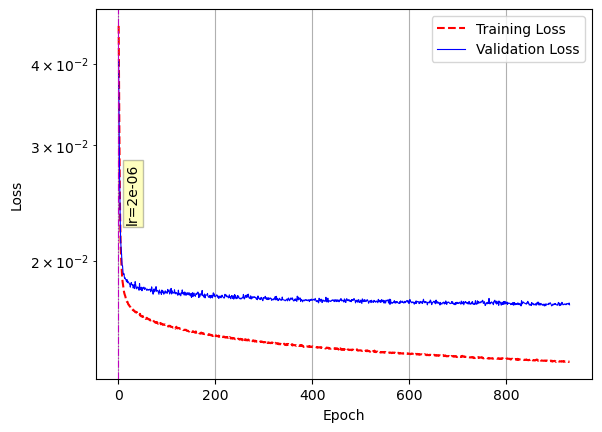

<Figure size 640x480 with 0 Axes>

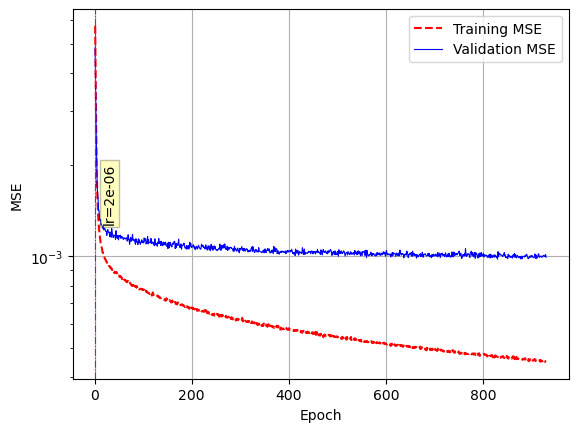

<Figure size 640x480 with 0 Axes>

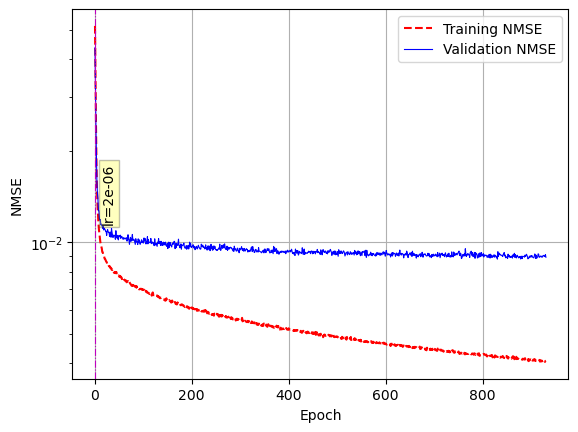

<Figure size 640x480 with 0 Axes>

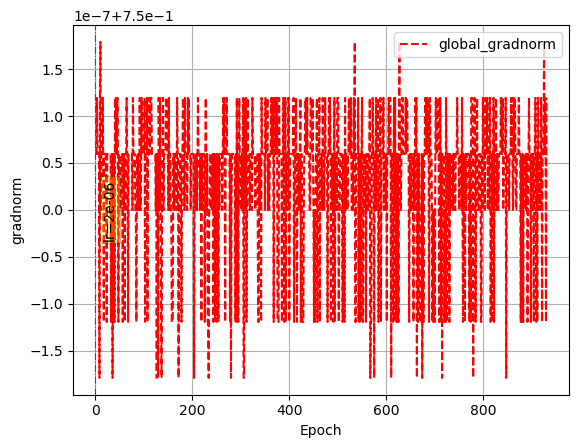

<Figure size 640x480 with 0 Axes>

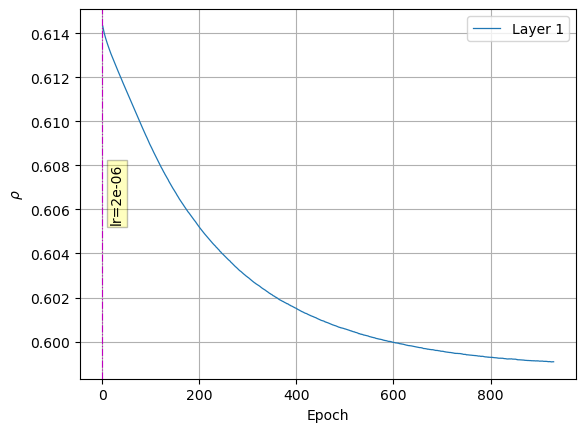

<Figure size 640x480 with 0 Axes>

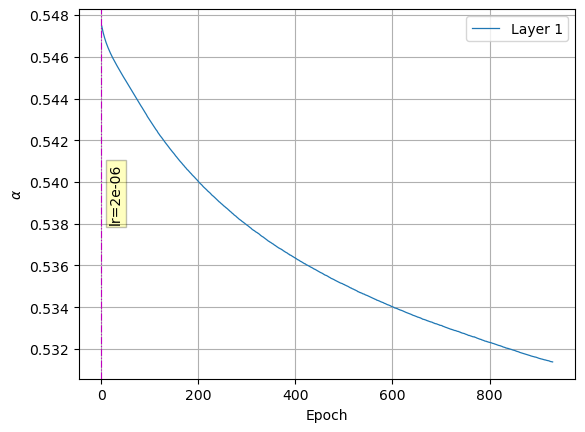

<Figure size 640x480 with 0 Axes>

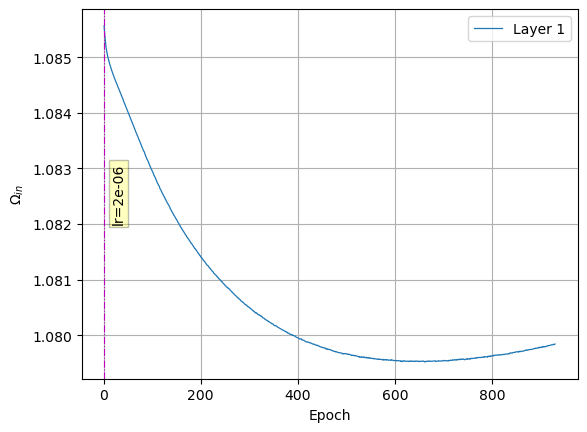



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.75
ListWrapper([True])
ListWrapper([True])
ListWrapper([True])


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
49/49 [==============================] - ETA: 0s - loss: 0.0569 - mse: 0.0103 - NMSE: 0.0930 - covmat_fro_loss: 0.0050 - global_gradnorm: 0.7500 - rho_res_0: 0.5992 - alpha_0: 0.5321 - omega_in_0: 1.0796 - tot_time: 0h 1m 46.1s

Epoch 1: val_NMSE improved from inf to 0.09809, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-50_o

Epoch 9/1000
49/49 [==============================] - ETA: 0s - loss: 0.0303 - mse: 0.0044 - NMSE: 0.0392 - covmat_fro_loss: 0.0028 - global_gradnorm: 0.7500 - rho_res_0: 0.5988 - alpha_0: 0.5317 - omega_in_0: 1.0793 - tot_time: 0h 7m 2.7s

Epoch 9: val_NMSE improved from 0.05771 to 0.05264, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 40s 814ms/step - loss: 0.0303 - mse: 0.0044 - NMSE: 0.0392 - covmat_fro_loss: 0.0028 - global_gradnorm: 0.7500 - rho_res_0: 0.5988 - alpha_0: 0.5317 - omega_in_0: 1.0793 - val_loss: 0.0366 - val_mse: 0.0058 - val_NMSE: 0.0526 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5988 - val_alpha_0: 0.5317 - val_omega_in_0: 1.0792
Epoch 10/1000
49/49 [===========

Epoch 18/1000
49/49 [==============================] - ETA: 0s - loss: 0.0231 - mse: 0.0027 - NMSE: 0.0244 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.5986 - alpha_0: 0.5314 - omega_in_0: 1.0790 - tot_time: 0h 13m 0.5s

Epoch 18: val_NMSE did not improve from 0.03950
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 791ms/step - loss: 0.0231 - mse: 0.0027 - NMSE: 0.0244 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.5986 - alpha_0: 0.5314 - omega_in_0: 1.0790 - val_loss: 0.0302 - val_mse: 0.0044 - val_NMSE: 0.0397 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5985 - val_alpha_0: 0.5314 - val_omega_in_0: 1.0790
Epoch 19/1000
49/49 [==============================] - ETA: 0s - loss: 0.0230 - mse: 0.0027 - NMSE: 0.0241 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.75

Epoch 27/1000
49/49 [==============================] - ETA: 0s - loss: 0.0216 - mse: 0.0024 - NMSE: 0.0213 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.7500 - rho_res_0: 0.5984 - alpha_0: 0.5311 - omega_in_0: 1.0788 - tot_time: 0h 18m 56.3s

Epoch 27: val_NMSE improved from 0.03517 to 0.03454, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 40s 812ms/step - loss: 0.0216 - mse: 0.0024 - NMSE: 0.0213 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.7500 - rho_res_0: 0.5984 - alpha_0: 0.5311 - omega_in_0: 1.0788 - val_loss: 0.0278 - val_mse: 0.0038 - val_NMSE: 0.0345 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5983 - val_alpha_0: 0.5311 - val_omega_in_0: 1.0788
Epoch 28/1000
49/49 [=======

Epoch 36/1000
49/49 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0022 - NMSE: 0.0200 - covmat_fro_loss: 0.0019 - global_gradnorm: 0.7500 - rho_res_0: 0.5982 - alpha_0: 0.5309 - omega_in_0: 1.0787 - tot_time: 0h 24m 49.2s

Epoch 36: val_NMSE did not improve from 0.03287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 790ms/step - loss: 0.0210 - mse: 0.0022 - NMSE: 0.0200 - covmat_fro_loss: 0.0019 - global_gradnorm: 0.7500 - rho_res_0: 0.5982 - alpha_0: 0.5309 - omega_in_0: 1.0787 - val_loss: 0.0272 - val_mse: 0.0037 - val_NMSE: 0.0333 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5982 - val_alpha_0: 0.5309 - val_omega_in_0: 1.0787
Epoch 37/1000
49/49 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0022 - NMSE: 0.0198 - covmat_fro_loss: 0.0019 - global_gradnorm: 0.7

Epoch 46/1000
49/49 [==============================] - ETA: 0s - loss: 0.0204 - mse: 0.0021 - NMSE: 0.0187 - covmat_fro_loss: 0.0019 - global_gradnorm: 0.7500 - rho_res_0: 0.5980 - alpha_0: 0.5307 - omega_in_0: 1.0785 - tot_time: 0h 31m 16.8s

Epoch 46: val_NMSE did not improve from 0.03222
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 792ms/step - loss: 0.0204 - mse: 0.0021 - NMSE: 0.0187 - covmat_fro_loss: 0.0019 - global_gradnorm: 0.7500 - rho_res_0: 0.5980 - alpha_0: 0.5307 - omega_in_0: 1.0785 - val_loss: 0.0268 - val_mse: 0.0036 - val_NMSE: 0.0323 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5980 - val_alpha_0: 0.5307 - val_omega_in_0: 1.0785
Epoch 47/1000
49/49 [==============================] - ETA: 0s - loss: 0.0204 - mse: 0.0021 - NMSE: 0.0188 - covmat_fro_loss: 0.0019 - global_gradnorm: 0.7

Epoch 56/1000
49/49 [==============================] - ETA: 0s - loss: 0.0201 - mse: 0.0020 - NMSE: 0.0181 - covmat_fro_loss: 0.0019 - global_gradnorm: 0.7500 - rho_res_0: 0.5979 - alpha_0: 0.5305 - omega_in_0: 1.0784 - tot_time: 0h 37m 43.9s

Epoch 56: val_NMSE improved from 0.03198 to 0.03187, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 40s 810ms/step - loss: 0.0201 - mse: 0.0020 - NMSE: 0.0181 - covmat_fro_loss: 0.0019 - global_gradnorm: 0.7500 - rho_res_0: 0.5979 - alpha_0: 0.5305 - omega_in_0: 1.0784 - val_loss: 0.0265 - val_mse: 0.0035 - val_NMSE: 0.0319 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5978 - val_alpha_0: 0.5304 - val_omega_in_0: 1.0784
Epoch 57/1000
49/49 [=======

49/49 [==============================] - ETA: 0s - loss: 0.0198 - mse: 0.0019 - NMSE: 0.0175 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7500 - rho_res_0: 0.5977 - alpha_0: 0.5303 - omega_in_0: 1.0783 - tot_time: 0h 43m 33.4s

Epoch 65: val_NMSE did not improve from 0.03125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 789ms/step - loss: 0.0198 - mse: 0.0019 - NMSE: 0.0175 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7500 - rho_res_0: 0.5977 - alpha_0: 0.5303 - omega_in_0: 1.0783 - val_loss: 0.0268 - val_mse: 0.0036 - val_NMSE: 0.0323 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5977 - val_alpha_0: 0.5303 - val_omega_in_0: 1.0782
Epoch 66/1000
49/49 [==============================] - ETA: 0s - loss: 0.0199 - mse: 0.0020 - NMSE: 0.0177 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7500 - rho_res_

Epoch 75/1000
49/49 [==============================] - ETA: 0s - loss: 0.0197 - mse: 0.0019 - NMSE: 0.0172 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7500 - rho_res_0: 0.5976 - alpha_0: 0.5301 - omega_in_0: 1.0781 - tot_time: 0h 49m 59.0s

Epoch 75: val_NMSE did not improve from 0.03125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 788ms/step - loss: 0.0197 - mse: 0.0019 - NMSE: 0.0172 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7500 - rho_res_0: 0.5976 - alpha_0: 0.5301 - omega_in_0: 1.0781 - val_loss: 0.0267 - val_mse: 0.0036 - val_NMSE: 0.0322 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5976 - val_alpha_0: 0.5300 - val_omega_in_0: 1.0781
Epoch 76/1000
49/49 [==============================] - ETA: 0s - loss: 0.0196 - mse: 0.0019 - NMSE: 0.0171 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7

Epoch 85/1000
49/49 [==============================] - ETA: 0s - loss: 0.0195 - mse: 0.0019 - NMSE: 0.0167 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7500 - rho_res_0: 0.5974 - alpha_0: 0.5298 - omega_in_0: 1.0780 - tot_time: 0h 56m 26.7s

Epoch 85: val_NMSE did not improve from 0.03074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 787ms/step - loss: 0.0195 - mse: 0.0019 - NMSE: 0.0167 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7500 - rho_res_0: 0.5974 - alpha_0: 0.5298 - omega_in_0: 1.0780 - val_loss: 0.0266 - val_mse: 0.0036 - val_NMSE: 0.0320 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5974 - val_alpha_0: 0.5298 - val_omega_in_0: 1.0780
Epoch 86/1000
49/49 [==============================] - ETA: 0s - loss: 0.0194 - mse: 0.0019 - NMSE: 0.0167 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7

Epoch 95/1000
49/49 [==============================] - ETA: 0s - loss: 0.0192 - mse: 0.0018 - NMSE: 0.0162 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7500 - rho_res_0: 0.5973 - alpha_0: 0.5296 - omega_in_0: 1.0778 - tot_time: 1h 2m 54.0s

Epoch 95: val_NMSE did not improve from 0.03062
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 38s 787ms/step - loss: 0.0192 - mse: 0.0018 - NMSE: 0.0162 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7500 - rho_res_0: 0.5973 - alpha_0: 0.5296 - omega_in_0: 1.0778 - val_loss: 0.0266 - val_mse: 0.0036 - val_NMSE: 0.0321 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5973 - val_alpha_0: 0.5296 - val_omega_in_0: 1.0778
Epoch 96/1000
49/49 [==============================] - ETA: 0s - loss: 0.0194 - mse: 0.0018 - NMSE: 0.0165 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.75

Epoch 105/1000
49/49 [==============================] - ETA: 0s - loss: 0.0193 - mse: 0.0018 - NMSE: 0.0163 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7500 - rho_res_0: 0.5972 - alpha_0: 0.5294 - omega_in_0: 1.0777 - tot_time: 1h 9m 19.1s

Epoch 105: val_NMSE did not improve from 0.03062
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 789ms/step - loss: 0.0193 - mse: 0.0018 - NMSE: 0.0163 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7500 - rho_res_0: 0.5972 - alpha_0: 0.5294 - omega_in_0: 1.0777 - val_loss: 0.0263 - val_mse: 0.0035 - val_NMSE: 0.0315 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5972 - val_alpha_0: 0.5294 - val_omega_in_0: 1.0777
Epoch 106/1000
49/49 [==============================] - ETA: 0s - loss: 0.0191 - mse: 0.0018 - NMSE: 0.0159 - covmat_fro_loss: 0.0018 - global_gradnorm: 0

Epoch 115/1000
49/49 [==============================] - ETA: 0s - loss: 0.0191 - mse: 0.0018 - NMSE: 0.0159 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7500 - rho_res_0: 0.5971 - alpha_0: 0.5293 - omega_in_0: 1.0775 - tot_time: 1h 15m 43.6s

Epoch 115: val_NMSE did not improve from 0.03062
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 38s 781ms/step - loss: 0.0191 - mse: 0.0018 - NMSE: 0.0159 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7500 - rho_res_0: 0.5971 - alpha_0: 0.5293 - omega_in_0: 1.0775 - val_loss: 0.0264 - val_mse: 0.0035 - val_NMSE: 0.0317 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5971 - val_alpha_0: 0.5293 - val_omega_in_0: 1.0775
Epoch 116/1000
49/49 [==============================] - ETA: 0s - loss: 0.0191 - mse: 0.0018 - NMSE: 0.0159 - covmat_fro_loss: 0.0018 - global_gradnorm: 

Epoch 125/1000
49/49 [==============================] - ETA: 0s - loss: 0.0190 - mse: 0.0017 - NMSE: 0.0157 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.7500 - rho_res_0: 0.5970 - alpha_0: 0.5291 - omega_in_0: 1.0774 - tot_time: 1h 22m 8.2s

Epoch 125: val_NMSE did not improve from 0.03062
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 38s 784ms/step - loss: 0.0190 - mse: 0.0017 - NMSE: 0.0157 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5970 - alpha_0: 0.5291 - omega_in_0: 1.0774 - val_loss: 0.0261 - val_mse: 0.0035 - val_NMSE: 0.0311 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5970 - val_alpha_0: 0.5291 - val_omega_in_0: 1.0774
Epoch 126/1000
49/49 [==============================] - ETA: 0s - loss: 0.0190 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0017 - global_gradnorm: 0

Epoch 135/1000
49/49 [==============================] - ETA: 0s - loss: 0.0189 - mse: 0.0017 - NMSE: 0.0155 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5970 - alpha_0: 0.5289 - omega_in_0: 1.0773 - tot_time: 1h 28m 36.7s

Epoch 135: val_NMSE did not improve from 0.03039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 38s 785ms/step - loss: 0.0189 - mse: 0.0017 - NMSE: 0.0155 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5970 - alpha_0: 0.5289 - omega_in_0: 1.0773 - val_loss: 0.0261 - val_mse: 0.0034 - val_NMSE: 0.0309 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5970 - val_alpha_0: 0.5289 - val_omega_in_0: 1.0773
Epoch 136/1000
49/49 [==============================] - ETA: 0s - loss: 0.0189 - mse: 0.0017 - NMSE: 0.0155 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 145/1000
49/49 [==============================] - ETA: 0s - loss: 0.0188 - mse: 0.0017 - NMSE: 0.0152 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5969 - alpha_0: 0.5288 - omega_in_0: 1.0771 - tot_time: 1h 35m 2.9s

Epoch 145: val_NMSE did not improve from 0.03039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 38s 786ms/step - loss: 0.0188 - mse: 0.0017 - NMSE: 0.0152 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5969 - alpha_0: 0.5288 - omega_in_0: 1.0771 - val_loss: 0.0261 - val_mse: 0.0035 - val_NMSE: 0.0311 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5969 - val_alpha_0: 0.5288 - val_omega_in_0: 1.0771
Epoch 146/1000
49/49 [==============================] - ETA: 0s - loss: 0.0188 - mse: 0.0017 - NMSE: 0.0154 - covmat_fro_loss: 0.0017 - global_gradnorm: 0

Epoch 155/1000
49/49 [==============================] - ETA: 0s - loss: 0.0186 - mse: 0.0017 - NMSE: 0.0149 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5968 - alpha_0: 0.5286 - omega_in_0: 1.0770 - tot_time: 1h 41m 30.4s

Epoch 155: val_NMSE did not improve from 0.03032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 792ms/step - loss: 0.0186 - mse: 0.0017 - NMSE: 0.0149 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5968 - alpha_0: 0.5286 - omega_in_0: 1.0770 - val_loss: 0.0263 - val_mse: 0.0035 - val_NMSE: 0.0313 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5968 - val_alpha_0: 0.5286 - val_omega_in_0: 1.0770
Epoch 156/1000
49/49 [==============================] - ETA: 0s - loss: 0.0187 - mse: 0.0017 - NMSE: 0.0151 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 165/1000
49/49 [==============================] - ETA: 0s - loss: 0.0187 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5967 - alpha_0: 0.5285 - omega_in_0: 1.0769 - tot_time: 1h 47m 56.2s

Epoch 165: val_NMSE did not improve from 0.03032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 38s 784ms/step - loss: 0.0187 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5967 - alpha_0: 0.5285 - omega_in_0: 1.0769 - val_loss: 0.0260 - val_mse: 0.0034 - val_NMSE: 0.0307 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5967 - val_alpha_0: 0.5285 - val_omega_in_0: 1.0769
Epoch 166/1000
49/49 [==============================] - ETA: 0s - loss: 0.0186 - mse: 0.0017 - NMSE: 0.0149 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 175/1000
49/49 [==============================] - ETA: 0s - loss: 0.0186 - mse: 0.0016 - NMSE: 0.0148 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5967 - alpha_0: 0.5283 - omega_in_0: 1.0768 - tot_time: 1h 54m 27.4s

Epoch 175: val_NMSE did not improve from 0.03032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 38s 781ms/step - loss: 0.0186 - mse: 0.0016 - NMSE: 0.0148 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5967 - alpha_0: 0.5283 - omega_in_0: 1.0768 - val_loss: 0.0262 - val_mse: 0.0035 - val_NMSE: 0.0312 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5967 - val_alpha_0: 0.5283 - val_omega_in_0: 1.0767
Epoch 176/1000
49/49 [==============================] - ETA: 0s - loss: 0.0185 - mse: 0.0016 - NMSE: 0.0146 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 185/1000
49/49 [==============================] - ETA: 0s - loss: 0.0185 - mse: 0.0016 - NMSE: 0.0147 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5966 - alpha_0: 0.5282 - omega_in_0: 1.0766 - tot_time: 2h 0m 60.0s

Epoch 185: val_NMSE did not improve from 0.02984
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 798ms/step - loss: 0.0185 - mse: 0.0016 - NMSE: 0.0147 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5966 - alpha_0: 0.5282 - omega_in_0: 1.0766 - val_loss: 0.0258 - val_mse: 0.0034 - val_NMSE: 0.0304 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5966 - val_alpha_0: 0.5282 - val_omega_in_0: 1.0766
Epoch 186/1000
49/49 [==============================] - ETA: 0s - loss: 0.0185 - mse: 0.0016 - NMSE: 0.0146 - covmat_fro_loss: 0.0017 - global_gradnorm: 0

Epoch 195/1000
49/49 [==============================] - ETA: 0s - loss: 0.0184 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5965 - alpha_0: 0.5281 - omega_in_0: 1.0765 - tot_time: 2h 7m 30.0s

Epoch 195: val_NMSE did not improve from 0.02984
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 798ms/step - loss: 0.0184 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5965 - alpha_0: 0.5281 - omega_in_0: 1.0765 - val_loss: 0.0264 - val_mse: 0.0035 - val_NMSE: 0.0317 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5965 - val_alpha_0: 0.5281 - val_omega_in_0: 1.0765
Epoch 196/1000
49/49 [==============================] - ETA: 0s - loss: 0.0184 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0017 - global_gradnorm: 0

Epoch 205/1000
49/49 [==============================] - ETA: 0s - loss: 0.0184 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5965 - alpha_0: 0.5280 - omega_in_0: 1.0764 - tot_time: 2h 13m 59.9s

Epoch 205: val_NMSE did not improve from 0.02984
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 796ms/step - loss: 0.0184 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5965 - alpha_0: 0.5280 - omega_in_0: 1.0764 - val_loss: 0.0257 - val_mse: 0.0034 - val_NMSE: 0.0302 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5965 - val_alpha_0: 0.5280 - val_omega_in_0: 1.0764
Epoch 206/1000
49/49 [==============================] - ETA: 0s - loss: 0.0183 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 215/1000
49/49 [==============================] - ETA: 0s - loss: 0.0183 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5964 - alpha_0: 0.5278 - omega_in_0: 1.0763 - tot_time: 2h 20m 30.7s

Epoch 215: val_NMSE did not improve from 0.02980
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 797ms/step - loss: 0.0183 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5964 - alpha_0: 0.5278 - omega_in_0: 1.0763 - val_loss: 0.0262 - val_mse: 0.0035 - val_NMSE: 0.0312 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5964 - val_alpha_0: 0.5278 - val_omega_in_0: 1.0763
Epoch 216/1000
49/49 [==============================] - ETA: 0s - loss: 0.0183 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 225/1000
49/49 [==============================] - ETA: 0s - loss: 0.0182 - mse: 0.0015 - NMSE: 0.0139 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5964 - alpha_0: 0.5277 - omega_in_0: 1.0762 - tot_time: 2h 26m 59.8s

Epoch 225: val_NMSE did not improve from 0.02980
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 796ms/step - loss: 0.0182 - mse: 0.0015 - NMSE: 0.0139 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5964 - alpha_0: 0.5277 - omega_in_0: 1.0762 - val_loss: 0.0258 - val_mse: 0.0034 - val_NMSE: 0.0304 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5964 - val_alpha_0: 0.5277 - val_omega_in_0: 1.0762
Epoch 226/1000
49/49 [==============================] - ETA: 0s - loss: 0.0182 - mse: 0.0015 - NMSE: 0.0139 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 235/1000
49/49 [==============================] - ETA: 0s - loss: 0.0182 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5963 - alpha_0: 0.5276 - omega_in_0: 1.0761 - tot_time: 2h 33m 28.7s

Epoch 235: val_NMSE did not improve from 0.02980
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 794ms/step - loss: 0.0182 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5963 - alpha_0: 0.5276 - omega_in_0: 1.0761 - val_loss: 0.0260 - val_mse: 0.0034 - val_NMSE: 0.0308 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5963 - val_alpha_0: 0.5276 - val_omega_in_0: 1.0761
Epoch 236/1000
49/49 [==============================] - ETA: 0s - loss: 0.0182 - mse: 0.0015 - NMSE: 0.0139 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 245/1000
49/49 [==============================] - ETA: 0s - loss: 0.0181 - mse: 0.0015 - NMSE: 0.0138 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5963 - alpha_0: 0.5275 - omega_in_0: 1.0760 - tot_time: 2h 39m 57.2s

Epoch 245: val_NMSE did not improve from 0.02980
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 797ms/step - loss: 0.0181 - mse: 0.0015 - NMSE: 0.0138 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5963 - alpha_0: 0.5275 - omega_in_0: 1.0760 - val_loss: 0.0260 - val_mse: 0.0034 - val_NMSE: 0.0307 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5963 - val_alpha_0: 0.5275 - val_omega_in_0: 1.0760
Epoch 246/1000
49/49 [==============================] - ETA: 0s - loss: 0.0181 - mse: 0.0015 - NMSE: 0.0137 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 255/1000
49/49 [==============================] - ETA: 0s - loss: 0.0182 - mse: 0.0015 - NMSE: 0.0139 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5963 - alpha_0: 0.5274 - omega_in_0: 1.0759 - tot_time: 2h 46m 26.7s

Epoch 255: val_NMSE did not improve from 0.02980
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 798ms/step - loss: 0.0182 - mse: 0.0015 - NMSE: 0.0139 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5963 - alpha_0: 0.5274 - omega_in_0: 1.0759 - val_loss: 0.0261 - val_mse: 0.0034 - val_NMSE: 0.0310 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5962 - val_alpha_0: 0.5274 - val_omega_in_0: 1.0759
Epoch 256/1000
49/49 [==============================] - ETA: 0s - loss: 0.0181 - mse: 0.0015 - NMSE: 0.0138 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 265/1000
49/49 [==============================] - ETA: 0s - loss: 0.0180 - mse: 0.0015 - NMSE: 0.0136 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5962 - alpha_0: 0.5273 - omega_in_0: 1.0758 - tot_time: 2h 52m 54.9s

Epoch 265: val_NMSE did not improve from 0.02980
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 795ms/step - loss: 0.0180 - mse: 0.0015 - NMSE: 0.0136 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5962 - alpha_0: 0.5273 - omega_in_0: 1.0758 - val_loss: 0.0259 - val_mse: 0.0034 - val_NMSE: 0.0306 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5962 - val_alpha_0: 0.5273 - val_omega_in_0: 1.0758
Epoch 266/1000
49/49 [==============================] - ETA: 0s - loss: 0.0180 - mse: 0.0015 - NMSE: 0.0136 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 275/1000
49/49 [==============================] - ETA: 0s - loss: 0.0180 - mse: 0.0015 - NMSE: 0.0135 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.7500 - rho_res_0: 0.5962 - alpha_0: 0.5272 - omega_in_0: 1.0757 - tot_time: 2h 59m 21.2s

Epoch 275: val_NMSE did not improve from 0.02980
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 789ms/step - loss: 0.0180 - mse: 0.0015 - NMSE: 0.0135 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.7500 - rho_res_0: 0.5962 - alpha_0: 0.5272 - omega_in_0: 1.0757 - val_loss: 0.0259 - val_mse: 0.0034 - val_NMSE: 0.0305 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5962 - val_alpha_0: 0.5272 - val_omega_in_0: 1.0757
Epoch 276/1000
49/49 [==============================] - ETA: 0s - loss: 0.0179 - mse: 0.0015 - NMSE: 0.0134 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 285/1000
49/49 [==============================] - ETA: 0s - loss: 0.0179 - mse: 0.0015 - NMSE: 0.0133 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.7500 - rho_res_0: 0.5961 - alpha_0: 0.5271 - omega_in_0: 1.0756 - tot_time: 3h 5m 47.1s

Epoch 285: val_NMSE did not improve from 0.02980
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 788ms/step - loss: 0.0179 - mse: 0.0015 - NMSE: 0.0133 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.7500 - rho_res_0: 0.5961 - alpha_0: 0.5271 - omega_in_0: 1.0756 - val_loss: 0.0262 - val_mse: 0.0035 - val_NMSE: 0.0312 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5961 - val_alpha_0: 0.5271 - val_omega_in_0: 1.0756
Epoch 286/1000
49/49 [==============================] - ETA: 0s - loss: 0.0179 - mse: 0.0015 - NMSE: 0.0134 - covmat_fro_loss: 0.0016 - global_gradnorm: 0

Epoch 295/1000
49/49 [==============================] - ETA: 0s - loss: 0.0178 - mse: 0.0015 - NMSE: 0.0131 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.7500 - rho_res_0: 0.5961 - alpha_0: 0.5270 - omega_in_0: 1.0755 - tot_time: 3h 12m 13.8s

Epoch 295: val_NMSE did not improve from 0.02980
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 791ms/step - loss: 0.0178 - mse: 0.0015 - NMSE: 0.0131 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.7500 - rho_res_0: 0.5961 - alpha_0: 0.5270 - omega_in_0: 1.0755 - val_loss: 0.0259 - val_mse: 0.0034 - val_NMSE: 0.0305 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5961 - val_alpha_0: 0.5270 - val_omega_in_0: 1.0755
Epoch 296/1000
49/49 [==============================] - ETA: 0s - loss: 0.0179 - mse: 0.0015 - NMSE: 0.0134 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 305/1000
49/49 [==============================] - ETA: 0s - loss: 0.0178 - mse: 0.0015 - NMSE: 0.0131 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.7500 - rho_res_0: 0.5961 - alpha_0: 0.5269 - omega_in_0: 1.0754 - tot_time: 3h 18m 40.5s

Epoch 305: val_NMSE did not improve from 0.02980
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 39s 792ms/step - loss: 0.0178 - mse: 0.0015 - NMSE: 0.0131 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.7500 - rho_res_0: 0.5961 - alpha_0: 0.5269 - omega_in_0: 1.0754 - val_loss: 0.0261 - val_mse: 0.0034 - val_NMSE: 0.0310 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5961 - val_alpha_0: 0.5269 - val_omega_in_0: 1.0754
Epoch 306/1000
49/49 [==============================] - ETA: 0s - loss: 0.0178 - mse: 0.0015 - NMSE: 0.0131 - covmat_fro_loss: 0.0016 - global_gradnorm: 

<Figure size 640x480 with 0 Axes>

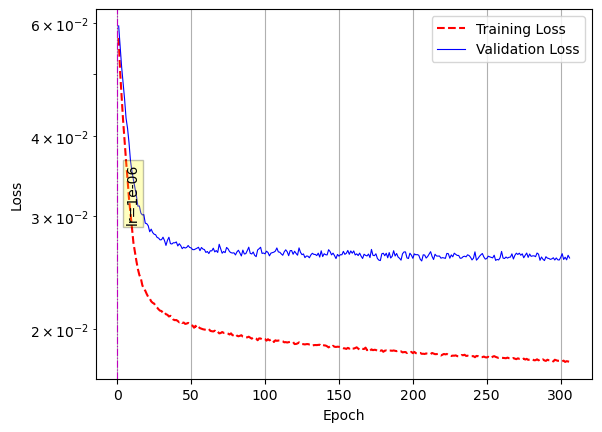

<Figure size 640x480 with 0 Axes>

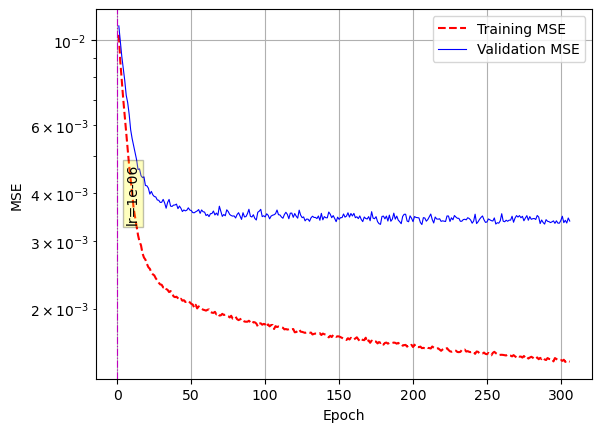

<Figure size 640x480 with 0 Axes>

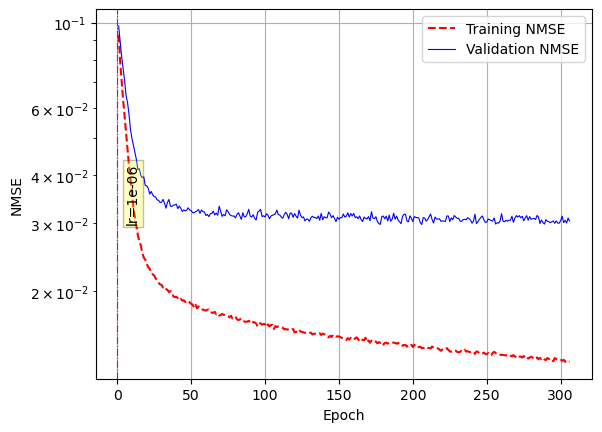

<Figure size 640x480 with 0 Axes>

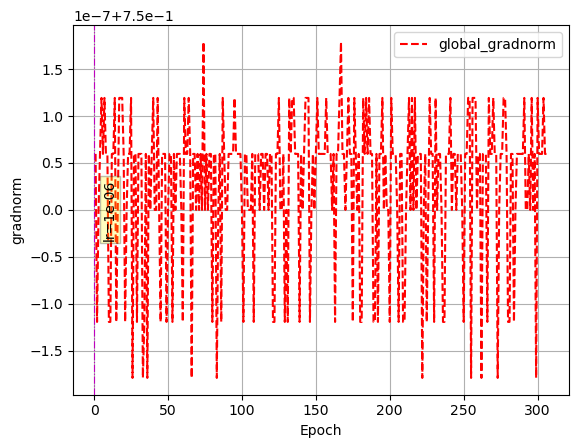

<Figure size 640x480 with 0 Axes>

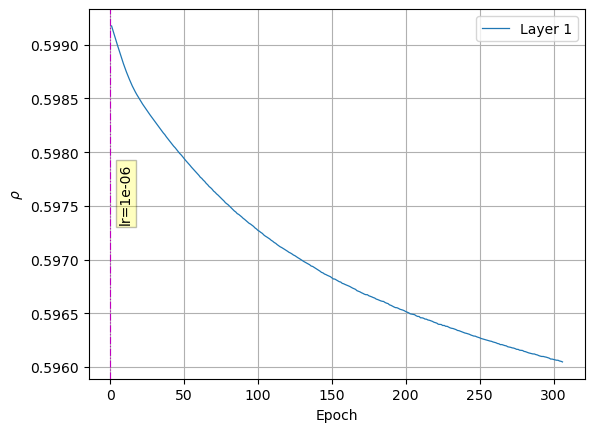

<Figure size 640x480 with 0 Axes>

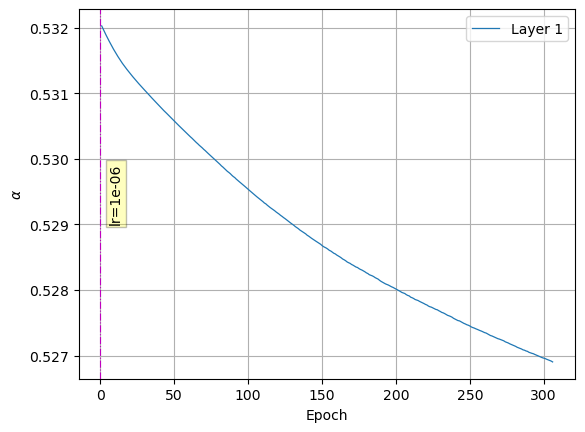

<Figure size 640x480 with 0 Axes>

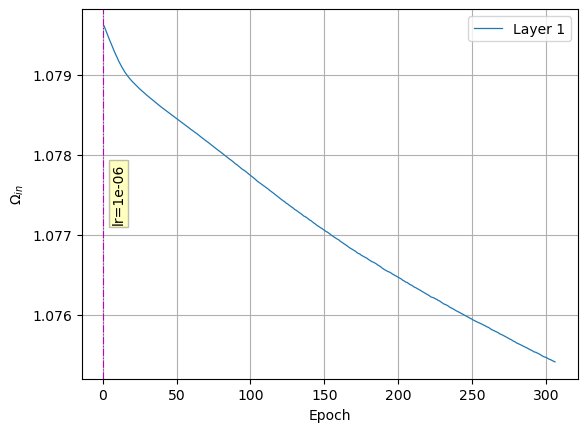



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 100 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.75
ListWrapper([True])
ListWrapper([True])
ListWrapper([True])


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-07 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
35/35 [==============================] - ETA: 0s - loss: 0.1095 - mse: 0.0457 - NMSE: 0.4116 - covmat_fro_loss: 0.0076 - global_gradnorm: 0.7500 - rho_res_0: 0.5965 - alpha_0: 0.5279 - omega_in_0: 1.0764 - tot_time: 0h 3m 0.8s

Epoch 1: val_NMSE improved from inf to 0.44143, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-100_o

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 42s 1s/step - loss: 0.0878 - mse: 0.0357 - NMSE: 0.3214 - covmat_fro_loss: 0.0067 - global_gradnorm: 0.7500 - rho_res_0: 0.5964 - alpha_0: 0.5278 - omega_in_0: 1.0763 - val_loss: 0.1046 - val_mse: 0.0437 - val_NMSE: 0.3936 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5964 - val_alpha_0: 0.5278 - val_omega_in_0: 1.0763
Epoch 9/1000
35/35 [==============================] - ETA: 0s - loss: 0.0863 - mse: 0.0350 - NMSE: 0.3151 - covmat_fro_loss: 0.0067 - global_gradnorm: 0.7500 - rho_res_0: 0.5964 - alpha_0: 0.5278 - omega_in_0: 1.0763 - tot_time: 0h 8m 27.4s

Epoch 9: val_NMSE improved from 0.39360 to 0.38891, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-100_outsteps
 - saving loss histories at /hom

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 42s 1s/step - loss: 0.0755 - mse: 0.0302 - NMSE: 0.2718 - covmat_fro_loss: 0.0061 - global_gradnorm: 0.7500 - rho_res_0: 0.5963 - alpha_0: 0.5277 - omega_in_0: 1.0761 - val_loss: 0.0938 - val_mse: 0.0388 - val_NMSE: 0.3491 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5963 - val_alpha_0: 0.5277 - val_omega_in_0: 1.0761
Epoch 18/1000
35/35 [==============================] - ETA: 0s - loss: 0.0737 - mse: 0.0293 - NMSE: 0.2634 - covmat_fro_loss: 0.0060 - global_gradnorm: 0.7500 - rho_res_0: 0.5962 - alpha_0: 0.5277 - omega_in_0: 1.0761 - tot_time: 0h 14m 32.4s

Epoch 18: val_NMSE improved from 0.34910 to 0.34701, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-100_outsteps
 - saving loss histories at /

35/35 [==============================] - ETA: 0s - loss: 0.0657 - mse: 0.0259 - NMSE: 0.2327 - covmat_fro_loss: 0.0055 - global_gradnorm: 0.7500 - rho_res_0: 0.5961 - alpha_0: 0.5275 - omega_in_0: 1.0760 - tot_time: 0h 19m 58.9s

Epoch 26: val_NMSE did not improve from 0.31813
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0657 - mse: 0.0259 - NMSE: 0.2327 - covmat_fro_loss: 0.0055 - global_gradnorm: 0.7500 - rho_res_0: 0.5961 - alpha_0: 0.5275 - omega_in_0: 1.0760 - val_loss: 0.0861 - val_mse: 0.0356 - val_NMSE: 0.3206 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5961 - val_alpha_0: 0.5275 - val_omega_in_0: 1.0760
Epoch 27/1000
35/35 [==============================] - ETA: 0s - loss: 0.0645 - mse: 0.0253 - NMSE: 0.2275 - covmat_fro_loss: 0.0054 - global_gradnorm: 0.7500 - rho_res_0:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 41s 1s/step - loss: 0.0579 - mse: 0.0223 - NMSE: 0.2007 - covmat_fro_loss: 0.0049 - global_gradnorm: 0.7500 - rho_res_0: 0.5960 - alpha_0: 0.5274 - omega_in_0: 1.0758 - val_loss: 0.0782 - val_mse: 0.0322 - val_NMSE: 0.2898 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5960 - val_alpha_0: 0.5274 - val_omega_in_0: 1.0758
Epoch 36/1000
35/35 [==============================] - ETA: 0s - loss: 0.0572 - mse: 0.0220 - NMSE: 0.1978 - covmat_fro_loss: 0.0049 - global_gradnorm: 0.7500 - rho_res_0: 0.5960 - alpha_0: 0.5274 - omega_in_0: 1.0758 - tot_time: 0h 26m 40.9s

Epoch 36: val_NMSE did not improve from 0.28980
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==

Epoch 45/1000
35/35 [==============================] - ETA: 0s - loss: 0.0515 - mse: 0.0193 - NMSE: 0.1737 - covmat_fro_loss: 0.0045 - global_gradnorm: 0.7500 - rho_res_0: 0.5959 - alpha_0: 0.5273 - omega_in_0: 1.0757 - tot_time: 0h 32m 39.3s

Epoch 45: val_NMSE did not improve from 0.27575
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0515 - mse: 0.0193 - NMSE: 0.1737 - covmat_fro_loss: 0.0045 - global_gradnorm: 0.7500 - rho_res_0: 0.5959 - alpha_0: 0.5273 - omega_in_0: 1.0757 - val_loss: 0.0752 - val_mse: 0.0312 - val_NMSE: 0.2811 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5959 - val_alpha_0: 0.5273 - val_omega_in_0: 1.0757
Epoch 46/1000
35/35 [==============================] - ETA: 0s - loss: 0.0505 - mse: 0.0189 - NMSE: 0.1701 - covmat_fro_loss: 0.0044 - global_gradnorm: 0.750

Epoch 54/1000
35/35 [==============================] - ETA: 0s - loss: 0.0472 - mse: 0.0173 - NMSE: 0.1559 - covmat_fro_loss: 0.0042 - global_gradnorm: 0.7500 - rho_res_0: 0.5958 - alpha_0: 0.5272 - omega_in_0: 1.0756 - tot_time: 0h 38m 43.8s

Epoch 54: val_NMSE did not improve from 0.26228
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0472 - mse: 0.0173 - NMSE: 0.1559 - covmat_fro_loss: 0.0042 - global_gradnorm: 0.7500 - rho_res_0: 0.5958 - alpha_0: 0.5272 - omega_in_0: 1.0756 - val_loss: 0.0708 - val_mse: 0.0293 - val_NMSE: 0.2638 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5958 - val_alpha_0: 0.5271 - val_omega_in_0: 1.0756
Epoch 55/1000
35/35 [==============================] - ETA: 0s - loss: 0.0468 - mse: 0.0172 - NMSE: 0.1546 - covmat_fro_loss: 0.0041 - global_gradnorm: 0.750

Epoch 63/1000
35/35 [==============================] - ETA: 0s - loss: 0.0442 - mse: 0.0159 - NMSE: 0.1435 - covmat_fro_loss: 0.0040 - global_gradnorm: 0.7500 - rho_res_0: 0.5957 - alpha_0: 0.5270 - omega_in_0: 1.0755 - tot_time: 0h 44m 44.0s

Epoch 63: val_NMSE did not improve from 0.24415
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0442 - mse: 0.0159 - NMSE: 0.1435 - covmat_fro_loss: 0.0039 - global_gradnorm: 0.7500 - rho_res_0: 0.5957 - alpha_0: 0.5270 - omega_in_0: 1.0755 - val_loss: 0.0669 - val_mse: 0.0273 - val_NMSE: 0.2455 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5957 - val_alpha_0: 0.5270 - val_omega_in_0: 1.0755
Epoch 64/1000
35/35 [==============================] - ETA: 0s - loss: 0.0435 - mse: 0.0156 - NMSE: 0.1405 - covmat_fro_loss: 0.0039 - global_gradnorm: 0.750

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0419 - mse: 0.0149 - NMSE: 0.1337 - covmat_fro_loss: 0.0038 - global_gradnorm: 0.7500 - rho_res_0: 0.5956 - alpha_0: 0.5269 - omega_in_0: 1.0754 - val_loss: 0.0654 - val_mse: 0.0266 - val_NMSE: 0.2397 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5956 - val_alpha_0: 0.5269 - val_omega_in_0: 1.0754
Epoch 73/1000
35/35 [==============================] - ETA: 0s - loss: 0.0419 - mse: 0.0149 - NMSE: 0.1337 - covmat_fro_loss: 0.0038 - global_gradnorm: 0.7500 - rho_res_0: 0.5956 - alpha_0: 0.5269 - omega_in_0: 1.0754 - tot_time: 0h 51m 19.9s

Epoch 73: val_NMSE improved from 0.23750 to 0.23394, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-100_outsteps
 - saving loss histories at /

Epoch 82/1000
35/35 [==============================] - ETA: 0s - loss: 0.0401 - mse: 0.0140 - NMSE: 0.1261 - covmat_fro_loss: 0.0037 - global_gradnorm: 0.7500 - rho_res_0: 0.5955 - alpha_0: 0.5268 - omega_in_0: 1.0753 - tot_time: 0h 57m 17.0s

Epoch 82: val_NMSE did not improve from 0.22950
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0401 - mse: 0.0140 - NMSE: 0.1261 - covmat_fro_loss: 0.0037 - global_gradnorm: 0.7500 - rho_res_0: 0.5955 - alpha_0: 0.5268 - omega_in_0: 1.0753 - val_loss: 0.0652 - val_mse: 0.0265 - val_NMSE: 0.2383 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5955 - val_alpha_0: 0.5268 - val_omega_in_0: 1.0753
Epoch 83/1000
35/35 [==============================] - ETA: 0s - loss: 0.0401 - mse: 0.0140 - NMSE: 0.1260 - covmat_fro_loss: 0.0037 - global_gradnorm: 0.750

Epoch 92/1000
35/35 [==============================] - ETA: 0s - loss: 0.0387 - mse: 0.0133 - NMSE: 0.1195 - covmat_fro_loss: 0.0036 - global_gradnorm: 0.7500 - rho_res_0: 0.5955 - alpha_0: 0.5267 - omega_in_0: 1.0752 - tot_time: 1h 3m 53.7s

Epoch 92: val_NMSE did not improve from 0.22865
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0387 - mse: 0.0133 - NMSE: 0.1195 - covmat_fro_loss: 0.0036 - global_gradnorm: 0.7500 - rho_res_0: 0.5955 - alpha_0: 0.5267 - omega_in_0: 1.0752 - val_loss: 0.0632 - val_mse: 0.0255 - val_NMSE: 0.2291 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5955 - val_alpha_0: 0.5267 - val_omega_in_0: 1.0752
Epoch 93/1000
35/35 [==============================] - ETA: 0s - loss: 0.0383 - mse: 0.0130 - NMSE: 0.1173 - covmat_fro_loss: 0.0036 - global_gradnorm: 0.7500

Epoch 102/1000
35/35 [==============================] - ETA: 0s - loss: 0.0376 - mse: 0.0127 - NMSE: 0.1147 - covmat_fro_loss: 0.0035 - global_gradnorm: 0.7500 - rho_res_0: 0.5954 - alpha_0: 0.5266 - omega_in_0: 1.0751 - tot_time: 1h 10m 30.0s

Epoch 102: val_NMSE did not improve from 0.21861
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0376 - mse: 0.0127 - NMSE: 0.1147 - covmat_fro_loss: 0.0035 - global_gradnorm: 0.7500 - rho_res_0: 0.5954 - alpha_0: 0.5266 - omega_in_0: 1.0751 - val_loss: 0.0611 - val_mse: 0.0243 - val_NMSE: 0.2191 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5954 - val_alpha_0: 0.5266 - val_omega_in_0: 1.0751
Epoch 103/1000
35/35 [==============================] - ETA: 0s - loss: 0.0376 - mse: 0.0127 - NMSE: 0.1144 - covmat_fro_loss: 0.0035 - global_gradnorm: 0.

Epoch 112/1000
35/35 [==============================] - ETA: 0s - loss: 0.0369 - mse: 0.0124 - NMSE: 0.1117 - covmat_fro_loss: 0.0035 - global_gradnorm: 0.7500 - rho_res_0: 0.5953 - alpha_0: 0.5265 - omega_in_0: 1.0750 - tot_time: 1h 17m 5.5s

Epoch 112: val_NMSE did not improve from 0.21802
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0369 - mse: 0.0124 - NMSE: 0.1117 - covmat_fro_loss: 0.0035 - global_gradnorm: 0.7500 - rho_res_0: 0.5953 - alpha_0: 0.5265 - omega_in_0: 1.0750 - val_loss: 0.0605 - val_mse: 0.0243 - val_NMSE: 0.2184 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5953 - val_alpha_0: 0.5265 - val_omega_in_0: 1.0750
Epoch 113/1000
35/35 [==============================] - ETA: 0s - loss: 0.0367 - mse: 0.0123 - NMSE: 0.1109 - covmat_fro_loss: 0.0035 - global_gradnorm: 0.7

35/35 [==============================] - ETA: 0s - loss: 0.0362 - mse: 0.0121 - NMSE: 0.1087 - covmat_fro_loss: 0.0034 - global_gradnorm: 0.7500 - rho_res_0: 0.5953 - alpha_0: 0.5264 - omega_in_0: 1.0749 - tot_time: 1h 23m 4.2s

Epoch 121: val_NMSE did not improve from 0.21483
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0362 - mse: 0.0121 - NMSE: 0.1087 - covmat_fro_loss: 0.0034 - global_gradnorm: 0.7500 - rho_res_0: 0.5953 - alpha_0: 0.5264 - omega_in_0: 1.0749 - val_loss: 0.0611 - val_mse: 0.0245 - val_NMSE: 0.2205 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5953 - val_alpha_0: 0.5264 - val_omega_in_0: 1.0749
Epoch 122/1000
35/35 [==============================] - ETA: 0s - loss: 0.0359 - mse: 0.0119 - NMSE: 0.1070 - covmat_fro_loss: 0.0034 - global_gradnorm: 0.7500 - rho_res_0

Epoch 131/1000
35/35 [==============================] - ETA: 0s - loss: 0.0355 - mse: 0.0117 - NMSE: 0.1049 - covmat_fro_loss: 0.0034 - global_gradnorm: 0.7500 - rho_res_0: 0.5952 - alpha_0: 0.5263 - omega_in_0: 1.0749 - tot_time: 1h 29m 39.7s

Epoch 131: val_NMSE did not improve from 0.21258
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0355 - mse: 0.0117 - NMSE: 0.1049 - covmat_fro_loss: 0.0034 - global_gradnorm: 0.7500 - rho_res_0: 0.5952 - alpha_0: 0.5263 - omega_in_0: 1.0749 - val_loss: 0.0604 - val_mse: 0.0240 - val_NMSE: 0.2160 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5952 - val_alpha_0: 0.5263 - val_omega_in_0: 1.0748
Epoch 132/1000
35/35 [==============================] - ETA: 0s - loss: 0.0356 - mse: 0.0117 - NMSE: 0.1056 - covmat_fro_loss: 0.0034 - global_gradnorm: 0.

Epoch 141/1000
35/35 [==============================] - ETA: 0s - loss: 0.0349 - mse: 0.0114 - NMSE: 0.1026 - covmat_fro_loss: 0.0034 - global_gradnorm: 0.7500 - rho_res_0: 0.5952 - alpha_0: 0.5262 - omega_in_0: 1.0748 - tot_time: 1h 36m 36.1s

Epoch 141: val_NMSE did not improve from 0.21150
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 42s 1s/step - loss: 0.0349 - mse: 0.0114 - NMSE: 0.1026 - covmat_fro_loss: 0.0034 - global_gradnorm: 0.7500 - rho_res_0: 0.5952 - alpha_0: 0.5262 - omega_in_0: 1.0748 - val_loss: 0.0593 - val_mse: 0.0236 - val_NMSE: 0.2124 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5952 - val_alpha_0: 0.5262 - val_omega_in_0: 1.0748
Epoch 142/1000
35/35 [==============================] - ETA: 0s - loss: 0.0348 - mse: 0.0113 - NMSE: 0.1017 - covmat_fro_loss: 0.0034 - global_gradnorm: 0.

Epoch 151/1000
35/35 [==============================] - ETA: 0s - loss: 0.0344 - mse: 0.0112 - NMSE: 0.1006 - covmat_fro_loss: 0.0033 - global_gradnorm: 0.7500 - rho_res_0: 0.5951 - alpha_0: 0.5261 - omega_in_0: 1.0747 - tot_time: 1h 43m 20.1s

Epoch 151: val_NMSE did not improve from 0.21063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0344 - mse: 0.0112 - NMSE: 0.1006 - covmat_fro_loss: 0.0033 - global_gradnorm: 0.7500 - rho_res_0: 0.5951 - alpha_0: 0.5261 - omega_in_0: 1.0747 - val_loss: 0.0597 - val_mse: 0.0238 - val_NMSE: 0.2142 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5951 - val_alpha_0: 0.5261 - val_omega_in_0: 1.0747
Epoch 152/1000
35/35 [==============================] - ETA: 0s - loss: 0.0342 - mse: 0.0110 - NMSE: 0.0991 - covmat_fro_loss: 0.0033 - global_gradnorm: 0.

Epoch 161/1000
35/35 [==============================] - ETA: 0s - loss: 0.0340 - mse: 0.0109 - NMSE: 0.0985 - covmat_fro_loss: 0.0033 - global_gradnorm: 0.7500 - rho_res_0: 0.5951 - alpha_0: 0.5259 - omega_in_0: 1.0746 - tot_time: 1h 49m 54.7s

Epoch 161: val_NMSE did not improve from 0.21063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0340 - mse: 0.0109 - NMSE: 0.0985 - covmat_fro_loss: 0.0033 - global_gradnorm: 0.7500 - rho_res_0: 0.5951 - alpha_0: 0.5259 - omega_in_0: 1.0746 - val_loss: 0.0592 - val_mse: 0.0235 - val_NMSE: 0.2115 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5951 - val_alpha_0: 0.5259 - val_omega_in_0: 1.0746
Epoch 162/1000
35/35 [==============================] - ETA: 0s - loss: 0.0340 - mse: 0.0109 - NMSE: 0.0981 - covmat_fro_loss: 0.0033 - global_gradnorm: 0.

Epoch 171/1000
35/35 [==============================] - ETA: 0s - loss: 0.0335 - mse: 0.0107 - NMSE: 0.0960 - covmat_fro_loss: 0.0033 - global_gradnorm: 0.7500 - rho_res_0: 0.5951 - alpha_0: 0.5258 - omega_in_0: 1.0745 - tot_time: 1h 56m 31.4s

Epoch 171: val_NMSE did not improve from 0.20873
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0335 - mse: 0.0107 - NMSE: 0.0960 - covmat_fro_loss: 0.0033 - global_gradnorm: 0.7500 - rho_res_0: 0.5951 - alpha_0: 0.5258 - omega_in_0: 1.0745 - val_loss: 0.0590 - val_mse: 0.0235 - val_NMSE: 0.2116 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5951 - val_alpha_0: 0.5258 - val_omega_in_0: 1.0745
Epoch 172/1000
35/35 [==============================] - ETA: 0s - loss: 0.0334 - mse: 0.0106 - NMSE: 0.0954 - covmat_fro_loss: 0.0033 - global_gradnorm: 0.

Epoch 181/1000
35/35 [==============================] - ETA: 0s - loss: 0.0334 - mse: 0.0106 - NMSE: 0.0955 - covmat_fro_loss: 0.0033 - global_gradnorm: 0.7500 - rho_res_0: 0.5950 - alpha_0: 0.5257 - omega_in_0: 1.0744 - tot_time: 2h 3m 5.7s

Epoch 181: val_NMSE improved from 0.20873 to 0.20668, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-100_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 41s 1s/step - loss: 0.0334 - mse: 0.0106 - NMSE: 0.0955 - covmat_fro_loss: 0.0033 - global_gradnorm: 0.7500 - rho_res_0: 0.5950 - alpha_0: 0.5257 - omega_in_0: 1.0744 - val_loss: 0.0581 - val_mse: 0.0230 - val_NMSE: 0.2067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5950 - val_alpha_0: 0.5257 - val_omega_in_0: 1.0744
Epoch 182/1000
35/35 [=======

Epoch 191/1000
35/35 [==============================] - ETA: 0s - loss: 0.0328 - mse: 0.0103 - NMSE: 0.0926 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.7500 - rho_res_0: 0.5950 - alpha_0: 0.5256 - omega_in_0: 1.0744 - tot_time: 2h 9m 41.6s

Epoch 191: val_NMSE did not improve from 0.20668
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0328 - mse: 0.0103 - NMSE: 0.0926 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.7500 - rho_res_0: 0.5950 - alpha_0: 0.5256 - omega_in_0: 1.0744 - val_loss: 0.0590 - val_mse: 0.0237 - val_NMSE: 0.2129 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5950 - val_alpha_0: 0.5256 - val_omega_in_0: 1.0744
Epoch 192/1000
35/35 [==============================] - ETA: 0s - loss: 0.0329 - mse: 0.0104 - NMSE: 0.0934 - covmat_fro_loss: 0.0033 - global_gradnorm: 0.7

Epoch 201/1000
35/35 [==============================] - ETA: 0s - loss: 0.0324 - mse: 0.0101 - NMSE: 0.0909 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.7500 - rho_res_0: 0.5950 - alpha_0: 0.5255 - omega_in_0: 1.0743 - tot_time: 2h 16m 16.0s

Epoch 201: val_NMSE did not improve from 0.20668
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0324 - mse: 0.0101 - NMSE: 0.0909 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.7500 - rho_res_0: 0.5950 - alpha_0: 0.5255 - omega_in_0: 1.0743 - val_loss: 0.0586 - val_mse: 0.0232 - val_NMSE: 0.2088 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5950 - val_alpha_0: 0.5255 - val_omega_in_0: 1.0743
Epoch 202/1000
35/35 [==============================] - ETA: 0s - loss: 0.0325 - mse: 0.0101 - NMSE: 0.0913 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.

Epoch 211/1000
35/35 [==============================] - ETA: 0s - loss: 0.0323 - mse: 0.0100 - NMSE: 0.0903 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.7500 - rho_res_0: 0.5949 - alpha_0: 0.5254 - omega_in_0: 1.0742 - tot_time: 2h 22m 50.8s

Epoch 211: val_NMSE did not improve from 0.20629
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0323 - mse: 0.0100 - NMSE: 0.0903 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.7500 - rho_res_0: 0.5949 - alpha_0: 0.5254 - omega_in_0: 1.0742 - val_loss: 0.0583 - val_mse: 0.0231 - val_NMSE: 0.2082 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5949 - val_alpha_0: 0.5253 - val_omega_in_0: 1.0742
Epoch 212/1000
35/35 [==============================] - ETA: 0s - loss: 0.0322 - mse: 0.0100 - NMSE: 0.0901 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.

Epoch 221/1000
35/35 [==============================] - ETA: 0s - loss: 0.0320 - mse: 0.0099 - NMSE: 0.0890 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.7500 - rho_res_0: 0.5949 - alpha_0: 0.5252 - omega_in_0: 1.0741 - tot_time: 2h 29m 25.4s

Epoch 221: val_NMSE did not improve from 0.20282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0320 - mse: 0.0099 - NMSE: 0.0890 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.7500 - rho_res_0: 0.5949 - alpha_0: 0.5252 - omega_in_0: 1.0741 - val_loss: 0.0578 - val_mse: 0.0229 - val_NMSE: 0.2063 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5949 - val_alpha_0: 0.5252 - val_omega_in_0: 1.0741
Epoch 222/1000
35/35 [==============================] - ETA: 0s - loss: 0.0317 - mse: 0.0097 - NMSE: 0.0876 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.

Epoch 231/1000
35/35 [==============================] - ETA: 0s - loss: 0.0315 - mse: 0.0096 - NMSE: 0.0866 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.7500 - rho_res_0: 0.5949 - alpha_0: 0.5251 - omega_in_0: 1.0741 - tot_time: 2h 35m 59.5s

Epoch 231: val_NMSE did not improve from 0.20282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0315 - mse: 0.0096 - NMSE: 0.0866 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.7500 - rho_res_0: 0.5949 - alpha_0: 0.5251 - omega_in_0: 1.0741 - val_loss: 0.0579 - val_mse: 0.0230 - val_NMSE: 0.2072 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5949 - val_alpha_0: 0.5251 - val_omega_in_0: 1.0741
Epoch 232/1000
35/35 [==============================] - ETA: 0s - loss: 0.0314 - mse: 0.0096 - NMSE: 0.0860 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.

Epoch 241/1000
35/35 [==============================] - ETA: 0s - loss: 0.0314 - mse: 0.0096 - NMSE: 0.0861 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.7500 - rho_res_0: 0.5949 - alpha_0: 0.5250 - omega_in_0: 1.0740 - tot_time: 2h 42m 34.4s

Epoch 241: val_NMSE did not improve from 0.20198
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0314 - mse: 0.0096 - NMSE: 0.0861 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5949 - alpha_0: 0.5250 - omega_in_0: 1.0740 - val_loss: 0.0579 - val_mse: 0.0230 - val_NMSE: 0.2073 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5949 - val_alpha_0: 0.5250 - val_omega_in_0: 1.0740
Epoch 242/1000
35/35 [==============================] - ETA: 0s - loss: 0.0313 - mse: 0.0095 - NMSE: 0.0857 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.

Epoch 251/1000
35/35 [==============================] - ETA: 0s - loss: 0.0310 - mse: 0.0094 - NMSE: 0.0842 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5949 - alpha_0: 0.5249 - omega_in_0: 1.0739 - tot_time: 2h 49m 10.1s

Epoch 251: val_NMSE did not improve from 0.20097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0310 - mse: 0.0094 - NMSE: 0.0842 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5949 - alpha_0: 0.5249 - omega_in_0: 1.0739 - val_loss: 0.0573 - val_mse: 0.0226 - val_NMSE: 0.2034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5949 - val_alpha_0: 0.5249 - val_omega_in_0: 1.0739
Epoch 252/1000
35/35 [==============================] - ETA: 0s - loss: 0.0309 - mse: 0.0093 - NMSE: 0.0837 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.

Epoch 261/1000
35/35 [==============================] - ETA: 0s - loss: 0.0308 - mse: 0.0092 - NMSE: 0.0832 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5948 - alpha_0: 0.5248 - omega_in_0: 1.0739 - tot_time: 2h 55m 44.0s

Epoch 261: val_NMSE did not improve from 0.20097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0308 - mse: 0.0092 - NMSE: 0.0832 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5948 - alpha_0: 0.5248 - omega_in_0: 1.0739 - val_loss: 0.0568 - val_mse: 0.0225 - val_NMSE: 0.2022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5948 - val_alpha_0: 0.5248 - val_omega_in_0: 1.0739
Epoch 262/1000
35/35 [==============================] - ETA: 0s - loss: 0.0307 - mse: 0.0092 - NMSE: 0.0827 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.

Epoch 271/1000
35/35 [==============================] - ETA: 0s - loss: 0.0306 - mse: 0.0092 - NMSE: 0.0824 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5948 - alpha_0: 0.5247 - omega_in_0: 1.0738 - tot_time: 3h 2m 18.8s

Epoch 271: val_NMSE did not improve from 0.20097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0306 - mse: 0.0092 - NMSE: 0.0824 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5948 - alpha_0: 0.5247 - omega_in_0: 1.0738 - val_loss: 0.0569 - val_mse: 0.0225 - val_NMSE: 0.2028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5948 - val_alpha_0: 0.5246 - val_omega_in_0: 1.0738
Epoch 272/1000
35/35 [==============================] - ETA: 0s - loss: 0.0309 - mse: 0.0094 - NMSE: 0.0842 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7

Epoch 281/1000
35/35 [==============================] - ETA: 0s - loss: 0.0303 - mse: 0.0090 - NMSE: 0.0810 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5948 - alpha_0: 0.5245 - omega_in_0: 1.0737 - tot_time: 3h 8m 53.9s

Epoch 281: val_NMSE did not improve from 0.20065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0303 - mse: 0.0090 - NMSE: 0.0810 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5948 - alpha_0: 0.5245 - omega_in_0: 1.0737 - val_loss: 0.0569 - val_mse: 0.0225 - val_NMSE: 0.2028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5948 - val_alpha_0: 0.5245 - val_omega_in_0: 1.0737
Epoch 282/1000
35/35 [==============================] - ETA: 0s - loss: 0.0301 - mse: 0.0089 - NMSE: 0.0800 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7

Epoch 291/1000
35/35 [==============================] - ETA: 0s - loss: 0.0301 - mse: 0.0089 - NMSE: 0.0800 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5948 - alpha_0: 0.5244 - omega_in_0: 1.0737 - tot_time: 3h 15m 29.8s

Epoch 291: val_NMSE did not improve from 0.20055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0301 - mse: 0.0089 - NMSE: 0.0800 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5948 - alpha_0: 0.5244 - omega_in_0: 1.0737 - val_loss: 0.0564 - val_mse: 0.0223 - val_NMSE: 0.2010 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5948 - val_alpha_0: 0.5244 - val_omega_in_0: 1.0737
Epoch 292/1000
35/35 [==============================] - ETA: 0s - loss: 0.0303 - mse: 0.0090 - NMSE: 0.0812 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.

Epoch 301/1000
35/35 [==============================] - ETA: 0s - loss: 0.0302 - mse: 0.0090 - NMSE: 0.0806 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5948 - alpha_0: 0.5243 - omega_in_0: 1.0736 - tot_time: 3h 22m 5.8s

Epoch 301: val_NMSE did not improve from 0.20055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0302 - mse: 0.0090 - NMSE: 0.0806 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5948 - alpha_0: 0.5243 - omega_in_0: 1.0736 - val_loss: 0.0573 - val_mse: 0.0228 - val_NMSE: 0.2053 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5948 - val_alpha_0: 0.5243 - val_omega_in_0: 1.0736
Epoch 302/1000
35/35 [==============================] - ETA: 0s - loss: 0.0300 - mse: 0.0089 - NMSE: 0.0800 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7

Epoch 311/1000
35/35 [==============================] - ETA: 0s - loss: 0.0301 - mse: 0.0089 - NMSE: 0.0799 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5948 - alpha_0: 0.5242 - omega_in_0: 1.0735 - tot_time: 3h 28m 40.6s

Epoch 311: val_NMSE did not improve from 0.20051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0301 - mse: 0.0089 - NMSE: 0.0799 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5948 - alpha_0: 0.5242 - omega_in_0: 1.0735 - val_loss: 0.0569 - val_mse: 0.0225 - val_NMSE: 0.2029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5948 - val_alpha_0: 0.5242 - val_omega_in_0: 1.0735
Epoch 312/1000
35/35 [==============================] - ETA: 0s - loss: 0.0300 - mse: 0.0088 - NMSE: 0.0793 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.

Epoch 321/1000
35/35 [==============================] - ETA: 0s - loss: 0.0297 - mse: 0.0087 - NMSE: 0.0780 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5948 - alpha_0: 0.5241 - omega_in_0: 1.0735 - tot_time: 3h 35m 16.3s

Epoch 321: val_NMSE did not improve from 0.19783
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0297 - mse: 0.0087 - NMSE: 0.0780 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.7500 - rho_res_0: 0.5948 - alpha_0: 0.5241 - omega_in_0: 1.0735 - val_loss: 0.0563 - val_mse: 0.0223 - val_NMSE: 0.2004 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5948 - val_alpha_0: 0.5241 - val_omega_in_0: 1.0735
Epoch 322/1000
35/35 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0086 - NMSE: 0.0772 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.

Epoch 331/1000
35/35 [==============================] - ETA: 0s - loss: 0.0293 - mse: 0.0085 - NMSE: 0.0765 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5240 - omega_in_0: 1.0734 - tot_time: 3h 41m 51.1s

Epoch 331: val_NMSE did not improve from 0.19783
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0293 - mse: 0.0085 - NMSE: 0.0765 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5240 - omega_in_0: 1.0734 - val_loss: 0.0563 - val_mse: 0.0222 - val_NMSE: 0.1994 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5947 - val_alpha_0: 0.5240 - val_omega_in_0: 1.0734
Epoch 332/1000
35/35 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0086 - NMSE: 0.0776 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.

Epoch 341/1000
35/35 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0086 - NMSE: 0.0775 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5239 - omega_in_0: 1.0734 - tot_time: 3h 48m 26.3s

Epoch 341: val_NMSE did not improve from 0.19764
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0295 - mse: 0.0086 - NMSE: 0.0775 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5239 - omega_in_0: 1.0734 - val_loss: 0.0564 - val_mse: 0.0222 - val_NMSE: 0.1996 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5947 - val_alpha_0: 0.5239 - val_omega_in_0: 1.0734
Epoch 342/1000
35/35 [==============================] - ETA: 0s - loss: 0.0294 - mse: 0.0085 - NMSE: 0.0768 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.

Epoch 351/1000
35/35 [==============================] - ETA: 0s - loss: 0.0292 - mse: 0.0085 - NMSE: 0.0761 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5238 - omega_in_0: 1.0733 - tot_time: 3h 55m 1.2s

Epoch 351: val_NMSE did not improve from 0.19764
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0292 - mse: 0.0085 - NMSE: 0.0761 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5238 - omega_in_0: 1.0733 - val_loss: 0.0568 - val_mse: 0.0224 - val_NMSE: 0.2015 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5947 - val_alpha_0: 0.5238 - val_omega_in_0: 1.0733
Epoch 352/1000
35/35 [==============================] - ETA: 0s - loss: 0.0290 - mse: 0.0083 - NMSE: 0.0749 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7

Epoch 361/1000
35/35 [==============================] - ETA: 0s - loss: 0.0291 - mse: 0.0084 - NMSE: 0.0757 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5237 - omega_in_0: 1.0733 - tot_time: 4h 1m 36.2s

Epoch 361: val_NMSE improved from 0.19764 to 0.19524, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/checkpoint-100_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 41s 1s/step - loss: 0.0291 - mse: 0.0084 - NMSE: 0.0757 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5237 - omega_in_0: 1.0733 - val_loss: 0.0554 - val_mse: 0.0217 - val_NMSE: 0.1952 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5947 - val_alpha_0: 0.5237 - val_omega_in_0: 1.0732
Epoch 362/1000
35/35 [======

Epoch 371/1000
35/35 [==============================] - ETA: 0s - loss: 0.0289 - mse: 0.0083 - NMSE: 0.0745 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5236 - omega_in_0: 1.0732 - tot_time: 4h 8m 11.9s

Epoch 371: val_NMSE did not improve from 0.19524
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0289 - mse: 0.0083 - NMSE: 0.0745 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5236 - omega_in_0: 1.0732 - val_loss: 0.0562 - val_mse: 0.0222 - val_NMSE: 0.1998 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5947 - val_alpha_0: 0.5236 - val_omega_in_0: 1.0732
Epoch 372/1000
35/35 [==============================] - ETA: 0s - loss: 0.0289 - mse: 0.0083 - NMSE: 0.0743 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7

Epoch 381/1000
35/35 [==============================] - ETA: 0s - loss: 0.0288 - mse: 0.0082 - NMSE: 0.0738 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5235 - omega_in_0: 1.0731 - tot_time: 4h 14m 45.9s

Epoch 381: val_NMSE did not improve from 0.19524
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0288 - mse: 0.0082 - NMSE: 0.0738 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5235 - omega_in_0: 1.0731 - val_loss: 0.0563 - val_mse: 0.0222 - val_NMSE: 0.2001 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5947 - val_alpha_0: 0.5235 - val_omega_in_0: 1.0731
Epoch 382/1000
35/35 [==============================] - ETA: 0s - loss: 0.0289 - mse: 0.0083 - NMSE: 0.0746 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.

Epoch 391/1000
35/35 [==============================] - ETA: 0s - loss: 0.0287 - mse: 0.0082 - NMSE: 0.0736 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5234 - omega_in_0: 1.0731 - tot_time: 4h 21m 20.4s

Epoch 391: val_NMSE did not improve from 0.19524
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0287 - mse: 0.0082 - NMSE: 0.0736 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5234 - omega_in_0: 1.0731 - val_loss: 0.0566 - val_mse: 0.0224 - val_NMSE: 0.2017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5947 - val_alpha_0: 0.5234 - val_omega_in_0: 1.0731
Epoch 392/1000
35/35 [==============================] - ETA: 0s - loss: 0.0289 - mse: 0.0083 - NMSE: 0.0743 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.

Epoch 401/1000
35/35 [==============================] - ETA: 0s - loss: 0.0286 - mse: 0.0081 - NMSE: 0.0733 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5233 - omega_in_0: 1.0730 - tot_time: 4h 27m 55.1s

Epoch 401: val_NMSE did not improve from 0.19524
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0286 - mse: 0.0081 - NMSE: 0.0733 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5233 - omega_in_0: 1.0730 - val_loss: 0.0562 - val_mse: 0.0222 - val_NMSE: 0.1994 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5947 - val_alpha_0: 0.5233 - val_omega_in_0: 1.0730
Epoch 402/1000
35/35 [==============================] - ETA: 0s - loss: 0.0286 - mse: 0.0081 - NMSE: 0.0732 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.

Epoch 411/1000
35/35 [==============================] - ETA: 0s - loss: 0.0286 - mse: 0.0081 - NMSE: 0.0732 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5232 - omega_in_0: 1.0730 - tot_time: 4h 34m 30.2s

Epoch 411: val_NMSE did not improve from 0.19456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0286 - mse: 0.0081 - NMSE: 0.0732 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5232 - omega_in_0: 1.0730 - val_loss: 0.0555 - val_mse: 0.0218 - val_NMSE: 0.1958 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5947 - val_alpha_0: 0.5232 - val_omega_in_0: 1.0730
Epoch 412/1000
35/35 [==============================] - ETA: 0s - loss: 0.0284 - mse: 0.0080 - NMSE: 0.0722 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.

Epoch 421/1000
35/35 [==============================] - ETA: 0s - loss: 0.0287 - mse: 0.0082 - NMSE: 0.0739 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5231 - omega_in_0: 1.0729 - tot_time: 4h 41m 5.1s

Epoch 421: val_NMSE did not improve from 0.19456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0287 - mse: 0.0082 - NMSE: 0.0739 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5231 - omega_in_0: 1.0729 - val_loss: 0.0562 - val_mse: 0.0222 - val_NMSE: 0.2001 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5947 - val_alpha_0: 0.5231 - val_omega_in_0: 1.0729
Epoch 422/1000
35/35 [==============================] - ETA: 0s - loss: 0.0285 - mse: 0.0081 - NMSE: 0.0727 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7

Epoch 431/1000
35/35 [==============================] - ETA: 0s - loss: 0.0283 - mse: 0.0080 - NMSE: 0.0718 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5230 - omega_in_0: 1.0729 - tot_time: 4h 47m 41.0s

Epoch 431: val_NMSE did not improve from 0.19456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0283 - mse: 0.0080 - NMSE: 0.0718 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5230 - omega_in_0: 1.0729 - val_loss: 0.0561 - val_mse: 0.0222 - val_NMSE: 0.1997 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5947 - val_alpha_0: 0.5230 - val_omega_in_0: 1.0729
Epoch 432/1000
35/35 [==============================] - ETA: 0s - loss: 0.0282 - mse: 0.0079 - NMSE: 0.0714 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.

Epoch 441/1000
35/35 [==============================] - ETA: 0s - loss: 0.0279 - mse: 0.0077 - NMSE: 0.0695 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5229 - omega_in_0: 1.0728 - tot_time: 4h 54m 15.8s

Epoch 441: val_NMSE did not improve from 0.19456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0279 - mse: 0.0077 - NMSE: 0.0695 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5229 - omega_in_0: 1.0728 - val_loss: 0.0559 - val_mse: 0.0221 - val_NMSE: 0.1985 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5947 - val_alpha_0: 0.5229 - val_omega_in_0: 1.0728
Epoch 442/1000
35/35 [==============================] - ETA: 0s - loss: 0.0283 - mse: 0.0080 - NMSE: 0.0721 - covmat_fro_loss: 0.0030 - global_gradnorm: 0.

Epoch 451/1000
35/35 [==============================] - ETA: 0s - loss: 0.0279 - mse: 0.0077 - NMSE: 0.0695 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5228 - omega_in_0: 1.0728 - tot_time: 5h 0m 50.1s

Epoch 451: val_NMSE did not improve from 0.19456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0279 - mse: 0.0077 - NMSE: 0.0695 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5947 - alpha_0: 0.5228 - omega_in_0: 1.0728 - val_loss: 0.0560 - val_mse: 0.0221 - val_NMSE: 0.1992 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5947 - val_alpha_0: 0.5228 - val_omega_in_0: 1.0728
Epoch 452/1000
35/35 [==============================] - ETA: 0s - loss: 0.0279 - mse: 0.0078 - NMSE: 0.0699 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7

Epoch 461/1000
35/35 [==============================] - ETA: 0s - loss: 0.0278 - mse: 0.0077 - NMSE: 0.0697 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5228 - omega_in_0: 1.0727 - tot_time: 5h 7m 25.7s

Epoch 461: val_NMSE did not improve from 0.19417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0278 - mse: 0.0077 - NMSE: 0.0697 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5228 - omega_in_0: 1.0727 - val_loss: 0.0556 - val_mse: 0.0218 - val_NMSE: 0.1964 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5946 - val_alpha_0: 0.5228 - val_omega_in_0: 1.0727
Epoch 462/1000
35/35 [==============================] - ETA: 0s - loss: 0.0280 - mse: 0.0078 - NMSE: 0.0705 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7

Epoch 471/1000
35/35 [==============================] - ETA: 0s - loss: 0.0278 - mse: 0.0077 - NMSE: 0.0694 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5227 - omega_in_0: 1.0727 - tot_time: 5h 13m 59.6s

Epoch 471: val_NMSE did not improve from 0.19417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0278 - mse: 0.0077 - NMSE: 0.0694 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5227 - omega_in_0: 1.0727 - val_loss: 0.0557 - val_mse: 0.0219 - val_NMSE: 0.1974 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5946 - val_alpha_0: 0.5227 - val_omega_in_0: 1.0727
Epoch 472/1000
35/35 [==============================] - ETA: 0s - loss: 0.0278 - mse: 0.0077 - NMSE: 0.0692 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.

Epoch 481/1000
35/35 [==============================] - ETA: 0s - loss: 0.0276 - mse: 0.0076 - NMSE: 0.0686 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5226 - omega_in_0: 1.0726 - tot_time: 5h 20m 34.3s

Epoch 481: val_NMSE did not improve from 0.19417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0276 - mse: 0.0076 - NMSE: 0.0686 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5226 - omega_in_0: 1.0726 - val_loss: 0.0563 - val_mse: 0.0222 - val_NMSE: 0.2000 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5946 - val_alpha_0: 0.5226 - val_omega_in_0: 1.0726
Epoch 482/1000
35/35 [==============================] - ETA: 0s - loss: 0.0276 - mse: 0.0077 - NMSE: 0.0689 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.

Epoch 491/1000
35/35 [==============================] - ETA: 0s - loss: 0.0275 - mse: 0.0076 - NMSE: 0.0682 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5225 - omega_in_0: 1.0726 - tot_time: 5h 27m 9.1s

Epoch 491: val_NMSE did not improve from 0.19417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0275 - mse: 0.0076 - NMSE: 0.0682 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5225 - omega_in_0: 1.0726 - val_loss: 0.0554 - val_mse: 0.0217 - val_NMSE: 0.1956 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5946 - val_alpha_0: 0.5225 - val_omega_in_0: 1.0726
Epoch 492/1000
35/35 [==============================] - ETA: 0s - loss: 0.0277 - mse: 0.0077 - NMSE: 0.0689 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7

Epoch 501/1000
35/35 [==============================] - ETA: 0s - loss: 0.0275 - mse: 0.0076 - NMSE: 0.0680 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5224 - omega_in_0: 1.0725 - tot_time: 5h 33m 42.9s

Epoch 501: val_NMSE did not improve from 0.19417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0275 - mse: 0.0076 - NMSE: 0.0680 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5224 - omega_in_0: 1.0725 - val_loss: 0.0562 - val_mse: 0.0223 - val_NMSE: 0.2003 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5946 - val_alpha_0: 0.5224 - val_omega_in_0: 1.0725
Epoch 502/1000
35/35 [==============================] - ETA: 0s - loss: 0.0274 - mse: 0.0075 - NMSE: 0.0679 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.

Epoch 511/1000
35/35 [==============================] - ETA: 0s - loss: 0.0273 - mse: 0.0074 - NMSE: 0.0669 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5224 - omega_in_0: 1.0725 - tot_time: 5h 40m 16.7s

Epoch 511: val_NMSE did not improve from 0.19417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0273 - mse: 0.0074 - NMSE: 0.0669 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5224 - omega_in_0: 1.0725 - val_loss: 0.0556 - val_mse: 0.0219 - val_NMSE: 0.1968 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5946 - val_alpha_0: 0.5224 - val_omega_in_0: 1.0725
Epoch 512/1000
35/35 [==============================] - ETA: 0s - loss: 0.0273 - mse: 0.0075 - NMSE: 0.0673 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.

Epoch 521/1000
35/35 [==============================] - ETA: 0s - loss: 0.0276 - mse: 0.0076 - NMSE: 0.0685 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5223 - omega_in_0: 1.0725 - tot_time: 5h 46m 51.5s

Epoch 521: val_NMSE did not improve from 0.19417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0276 - mse: 0.0076 - NMSE: 0.0685 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5223 - omega_in_0: 1.0725 - val_loss: 0.0558 - val_mse: 0.0220 - val_NMSE: 0.1977 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5946 - val_alpha_0: 0.5223 - val_omega_in_0: 1.0725
Epoch 522/1000
35/35 [==============================] - ETA: 0s - loss: 0.0271 - mse: 0.0073 - NMSE: 0.0658 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.

Epoch 531/1000
35/35 [==============================] - ETA: 0s - loss: 0.0270 - mse: 0.0073 - NMSE: 0.0657 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5222 - omega_in_0: 1.0724 - tot_time: 5h 53m 25.5s

Epoch 531: val_NMSE did not improve from 0.19417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 40s 1s/step - loss: 0.0270 - mse: 0.0073 - NMSE: 0.0657 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5222 - omega_in_0: 1.0724 - val_loss: 0.0557 - val_mse: 0.0219 - val_NMSE: 0.1970 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5946 - val_alpha_0: 0.5222 - val_omega_in_0: 1.0724
Epoch 532/1000
35/35 [==============================] - ETA: 0s - loss: 0.0272 - mse: 0.0074 - NMSE: 0.0666 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.

Epoch 541/1000
35/35 [==============================] - ETA: 0s - loss: 0.0270 - mse: 0.0073 - NMSE: 0.0655 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5221 - omega_in_0: 1.0724 - tot_time: 5h 59m 59.3s

Epoch 541: val_NMSE did not improve from 0.19417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0270 - mse: 0.0073 - NMSE: 0.0655 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5221 - omega_in_0: 1.0724 - val_loss: 0.0563 - val_mse: 0.0222 - val_NMSE: 0.2001 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5946 - val_alpha_0: 0.5221 - val_omega_in_0: 1.0724
Epoch 542/1000
35/35 [==============================] - ETA: 0s - loss: 0.0271 - mse: 0.0073 - NMSE: 0.0660 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.

Epoch 551/1000
35/35 [==============================] - ETA: 0s - loss: 0.0273 - mse: 0.0075 - NMSE: 0.0676 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5221 - omega_in_0: 1.0723 - tot_time: 6h 6m 33.8s

Epoch 551: val_NMSE did not improve from 0.19417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_018/checkpoints/LossHistoriesCheckpoint-100_outsteps
35/35 [==============================] - 39s 1s/step - loss: 0.0273 - mse: 0.0075 - NMSE: 0.0676 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7500 - rho_res_0: 0.5946 - alpha_0: 0.5221 - omega_in_0: 1.0723 - val_loss: 0.0555 - val_mse: 0.0218 - val_NMSE: 0.1966 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.5946 - val_alpha_0: 0.5221 - val_omega_in_0: 1.0723
Epoch 552/1000
35/35 [==============================] - ETA: 0s - loss: 0.0269 - mse: 0.0073 - NMSE: 0.0656 - covmat_fro_loss: 0.0029 - global_gradnorm: 0.7

<Figure size 640x480 with 0 Axes>

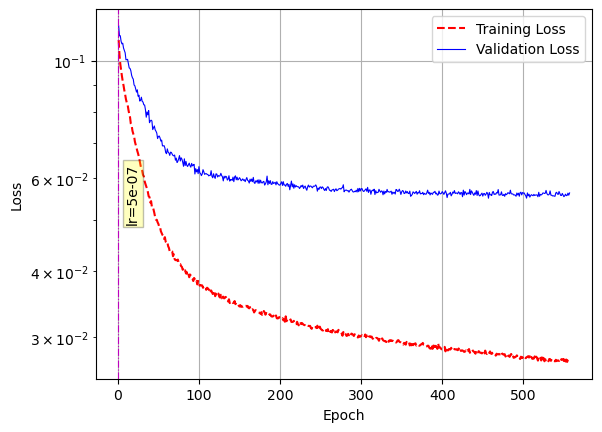

<Figure size 640x480 with 0 Axes>

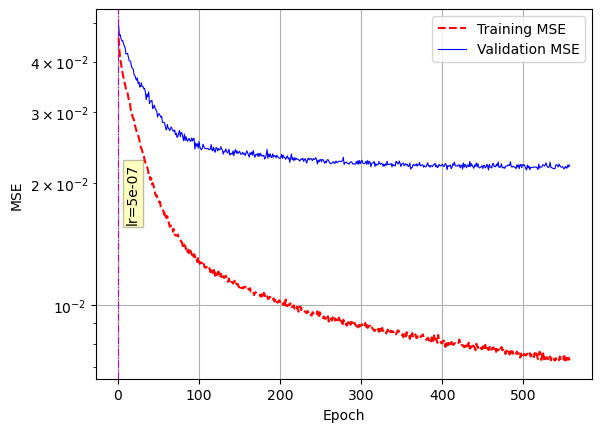

<Figure size 640x480 with 0 Axes>

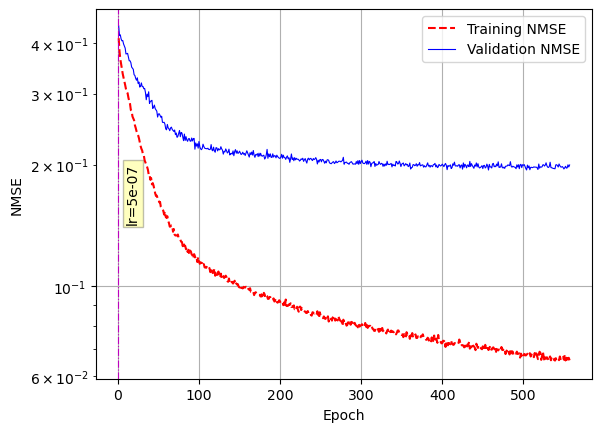

<Figure size 640x480 with 0 Axes>

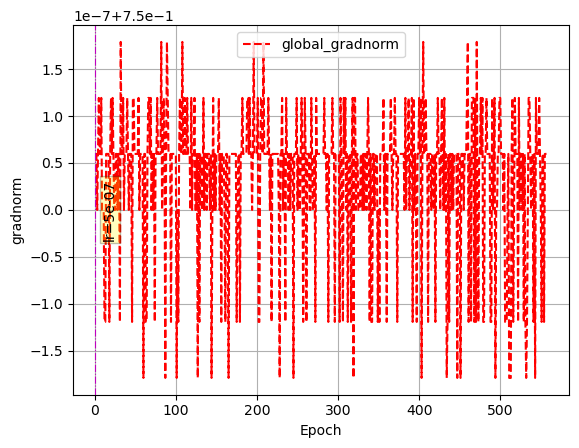

<Figure size 640x480 with 0 Axes>

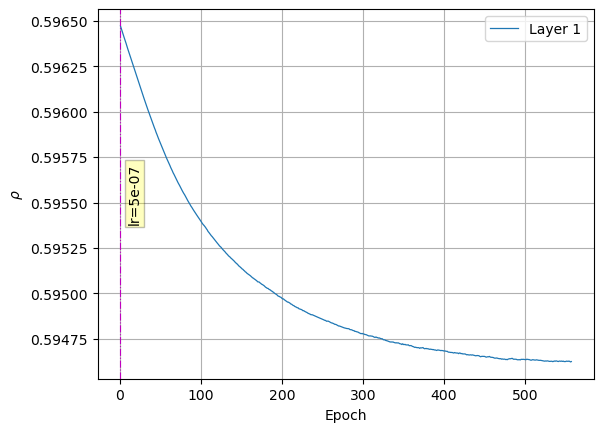

<Figure size 640x480 with 0 Axes>

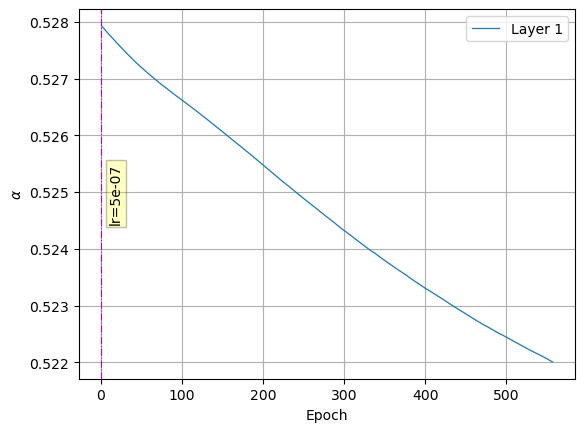

<Figure size 640x480 with 0 Axes>

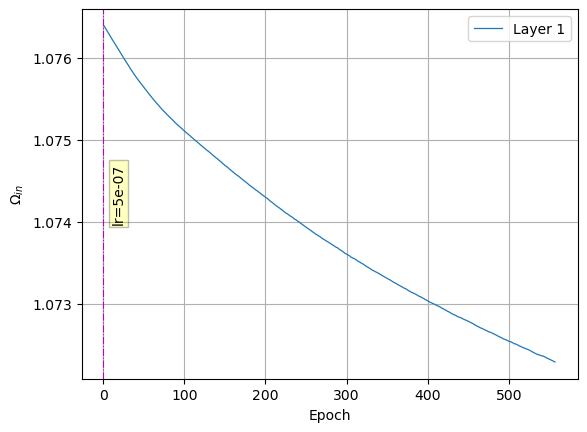

<Figure size 640x480 with 0 Axes>

In [22]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    if behaviour == 'loadCheckpointAndContinueTraining':
        if kk < len(T_sample_output) - 1:
            temp = int((T_sample_output[kk+1] + 0.5*dt_rnn)//dt_rnn)
        else:
            temp = num_outsteps
        checkfile1 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(temp)
        checkfile2 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(temp)
        check1 = os.path.exists(checkfile1)
        check2 = os.path.exists(checkfile2)
        if check1 and check2:
            # move on to checking the next time-step
            continue
        else:
            pass
    
    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN_ESN,
        all_data,
        AR_AERNN_ESN,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        ESN_flag=True,
        rnn_kwargs=rnn_kwargs,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    idxs_to_ignore = 0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.25 * np.round(4*global_clipnorm)

In [23]:
### Training the combined AE-RNN


# 